# Цель / задача работы

Задача - построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. 

Первая и самая важная цель банка — заработать деньги. Если банк будет вести слишком жесткую политику, не выдавая кредиты даже тем, кто вернул бы деньги, то он не заработает на процентах. Отказ в кредите хорошему заемщику — ошибка первого рода. Риск, с которым сталкивается кредитная организация — дать кредит неблагонадёжному заёмщику, который впоследствии может допустить дефолт, а банк потеряет деньги — ошибка второго рода.

Чтобы соблюсти баланс, используется кредитный скоринг, который позволяет спрогнозировать вероятность невозврата кредита.

# Описание признаков

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

# Импорты библиотек

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from numpy import linalg as LA
from sklearn.feature_selection import f_classif, mutual_info_classif
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
from sklearn.preprocessing import PolynomialFeatures

from sklearn.decomposition import PCA
from sklearn import metrics

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralBiclustering

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.inspection import permutation_importance

In [2]:
# !pip install shap

In [3]:
RANDOM_SEED = 5

# Импорт данных

In [4]:
df = pd.read_csv('train.csv')
df

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0          25905  01FEB2014       SCH   M   62   Y        Y                0   
1          63161  12MAR2014       SCH   F   59   N        N                0   
2          25887  01FEB2014       SCH   M   25   Y        N                2   
3          16222  23JAN2014       SCH   F   53   N        N                0   
4         101655  18APR2014       GRD   M   48   N        N                0   
...          ...        ...       ...  ..  ...  ..      ...              ...   
73794      54887  04MAR2014       GRD   F   45   N        N                0   
73795      76821  24MAR2014       SCH   M   41   Y        Y                0   
73796     103695  22APR2014       SCH   M   31   N        N                0   
73797        861  04JAN2014       SCH   F   29   N        N                0   
73798      15796  23JAN2014       GRD   M   34   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0              0  -2.008753                1             50             1   
1              0  -1.532276                3             50             2   
2              0  -1.408142                1             80             1   
3              0  -2.057471                2             50             2   
4              1  -1.244723                1             60             2   
...          ...        ...              ...            ...           ...   
73794          0  -1.792064                3             50             1   
73795          0  -2.058029                1             50             2   
73796          0  -1.512635                4             80             2   
73797          1  -1.479334                3             50             1   
73798          0  -1.764711                2             50             2   

       work_address  income  sna  first_time foreign_passport  default  
0                 2   18000    4           1                N        0  
1                 3   19000    4           1                N        0  
2                 2   30000    1           4                Y        0  
3                 3   10000    1           3                N        0  
4                 3   30000    1           4                Y        0  
...             ...     ...  ...         ...              ...      ...  
73794             2   17000    4           4                N        0  
73795             2   70000    1           4                N        0  
73796             3   45000    2           2                N        0  
73797             3   13000    2           3                N        1  
73798             3   25000    1           3                N        0  

[73799 rows x 19 columns]

In [5]:
df.info()
# Датасет содержит 12 признаков в виде чисел int, 1 признак в виде float и 6 признаков в виде строк. 
# Пропуски содержит только признак education - non-null 73 492 строк из 73 799.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

## Обработка пропусков

In [6]:
df.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', nan], dtype=object)

- SCH - school, школьное образование

- GRD - graduate, выпускник

- UGR - undergraduates, старшекурсники

- PGR - аспирант

- ACD - академик

In [7]:
df['education'].value_counts(dropna=False)

SCH    38860
GRD    23365
UGR     9816
PGR     1257
NaN      307
ACD      194
Name: education, dtype: int64

In [8]:
print(f'Пустых значений: {df["education"].isna().sum()}, ' +
      f'это {100*df["education"].isna().sum() / len(df):0.2f}% от общего количества строк.')

Пустых значений: 307, это 0.42% от общего количества строк.


In [9]:
# Посмотрим, какое образование является модой
df["education"].mode()[0]

'SCH'

In [10]:
# Заполним пропуски значением, которое встречается чаще всего
df["education"].fillna('SCH', inplace=True)
# Теперь пропусков больше нет
df.isnull().sum() 

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
dtype: int64

In [11]:
# Дубликатов нет
df[df.duplicated(keep=False)]

Empty DataFrame
Columns: [client_id, app_date, education, sex, age, car, car_type, decline_app_cnt, good_work, score_bki, bki_request_cnt, region_rating, home_address, work_address, income, sna, first_time, foreign_passport, default]
Index: []

## Обработка числовых, бинарных и категор. признаков

In [12]:
# определим, какие признаки являются числовыми, какие - категориальные, и какие - бинарные
df.nunique()

client_id           73799
app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
default                 2
dtype: int64

In [13]:
# Признаки с большим количеством уникальных значений отнесем к числовым, за исключением app_date,
# так как он содержит дату в виде строки. Данный признак необходимо преобразовать.
# Также не будем использовать признак client_id, так как все его значения уникальны и он никак не повлияет на модель.
num_cols = ["age", "decline_app_cnt", "score_bki",
            "bki_request_cnt", "region_rating", "income"]

# К бинарным отнесем остальные признаки, количество уникальных значений которых равно 2:
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"] # 'default' - target

# Все остальные - категориальные:
cat_cols = ["education", "home_address", "work_address", "sna", "first_time"]

In [14]:
# Уникальные значения признака app_date
df["app_date"].unique()

array(['01FEB2014', '12MAR2014', '23JAN2014', '18APR2014', '18FEB2014',
       '04FEB2014', '17MAR2014', '14FEB2014', '10JAN2014', '03FEB2014',
       '08APR2014', '08JAN2014', '19MAR2014', '22JAN2014', '30JAN2014',
       '11MAR2014', '02FEB2014', '14APR2014', '06JAN2014', '24MAR2014',
       '15APR2014', '28FEB2014', '11FEB2014', '30MAR2014', '23MAR2014',
       '09MAR2014', '02MAR2014', '31JAN2014', '14MAR2014', '26JAN2014',
       '03APR2014', '22MAR2014', '11JAN2014', '17FEB2014', '13FEB2014',
       '17APR2014', '25FEB2014', '10APR2014', '01APR2014', '21APR2014',
       '20MAR2014', '03MAR2014', '25MAR2014', '24FEB2014', '16APR2014',
       '27FEB2014', '18MAR2014', '19FEB2014', '20FEB2014', '31MAR2014',
       '04MAR2014', '25JAN2014', '07JAN2014', '07MAR2014', '26MAR2014',
       '05FEB2014', '06MAR2014', '08FEB2014', '21JAN2014', '13MAR2014',
       '09JAN2014', '07FEB2014', '29JAN2014', '27JAN2014', '15FEB2014',
       '29APR2014', '04APR2014', '16JAN2014', '07APR2014', '13JA

In [15]:
# Данный признак в формате "ДДМММГГГГ"
# Извлекаем число, месяц и год из признака и преобразовываем его в формат datetime:
extracted_app_date_df = df["app_date"].str.extract("(\d{2})(\w{3})(\d{4})")
df["app_date"] = extracted_app_date_df.apply(lambda x: datetime.strptime(x[0]+x[1]+x[2], "%d%b%Y"),
                                             axis=1)

In [16]:
# Преобразовываем значение месяца в числовой формат и добавим новые признаки в наш датафрейм
extracted_app_date_df.columns = ["app_day", "app_month", "app_year"]
extracted_app_date_df["app_month"] = pd.to_datetime(extracted_app_date_df["app_month"],
                                                    format="%b").dt.month
extracted_app_date_df["app_day"] = extracted_app_date_df["app_day"].astype(int)
extracted_app_date_df["app_year"] = extracted_app_date_df["app_year"].astype(
    int)
df = pd.concat([df, extracted_app_date_df], axis=1)
df["app_weekday"] = df["app_date"].dt.weekday

df["app_year"].unique()

array([2014])

In [17]:
# В нашем датасете присутствуют только записи, где год подачи заявки - 2014
# Добавим новый признак, обозначающий количество дней прошедших с начала 2014 года
df["app_passed_days"] = (df["app_date"] - datetime(2014, 1, 1)).dt.days

# Распределим новые признаки к числовым переменным
num_cols.extend(["app_day", "app_month", "app_weekday", "app_passed_days"])

# Признак app_year не добавили, потому что это константа и он не поможет нам в предсказании целевой переменной. 
# app_date нам также не нужен, так как вся содержащаяся в нем информация уже есть в других признаках
df.drop(["app_date", "app_year"], axis=1, inplace=True)

# Обновленный датафрейм
df.head()

client_id education sex  age car car_type  decline_app_cnt  good_work  \
0      25905       SCH   M   62   Y        Y                0          0   
1      63161       SCH   F   59   N        N                0          0   
2      25887       SCH   M   25   Y        N                2          0   
3      16222       SCH   F   53   N        N                0          0   
4     101655       GRD   M   48   N        N                0          1   

   score_bki  bki_request_cnt  ...  work_address  income  sna  first_time  \
0  -2.008753                1  ...             2   18000    4           1   
1  -1.532276                3  ...             3   19000    4           1   
2  -1.408142                1  ...             2   30000    1           4   
3  -2.057471                2  ...             3   10000    1           3   
4  -1.244723                1  ...             3   30000    1           4   

   foreign_passport  default app_day  app_month  app_weekday  app_passed_days  
0                 N        0       1          2            5               31  
1                 N        0      12          3            2               70  
2                 Y        0       1          2            5               31  
3                 N        0      23          1            3               22  
4                 Y        0      18          4            4              107  

[5 rows x 22 columns]

In [18]:
# num_cols = 10
# num_cols = ["age", "decline_app_cnt", "score_bki",
#             "bki_request_cnt", "region_rating", "income", "app_day", "app_month", "app_weekday", "app_passed_days"]

# bin_cols = 5
# bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"] 

# cat_cols = 5
# cat_cols = ["education", "home_address", "work_address", "sna", "first_time"]

# client_id
# default - target

### Числовые

default
0     0.87
1     0.13

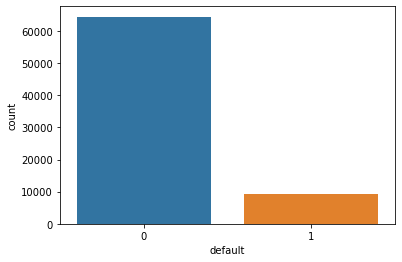

In [19]:
# Распределение целевой переменной
sns.countplot(x = df['default']);
#  Выборка несбалансированная
round(df['default'].value_counts(normalize=True), 2).to_frame()

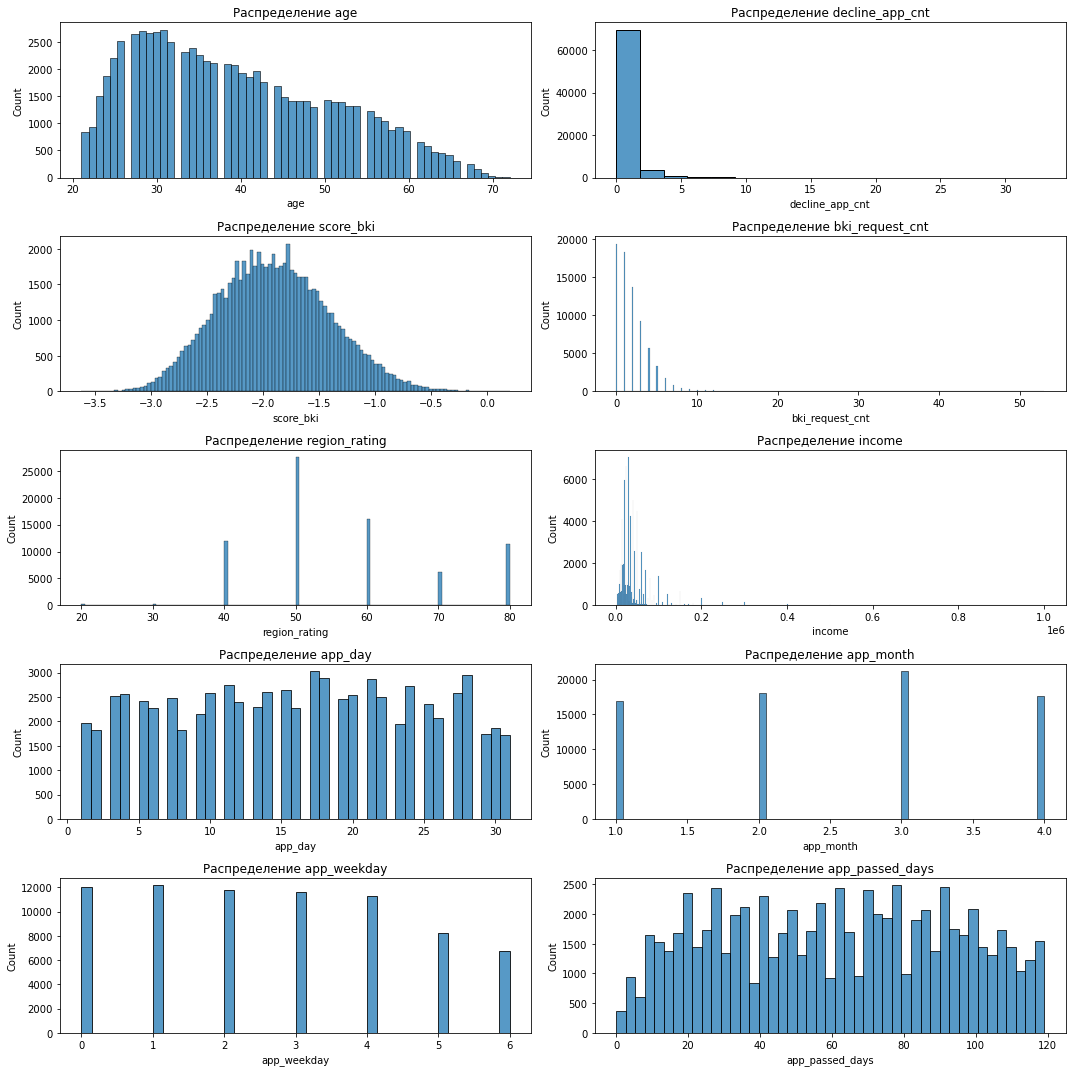

In [20]:
# Распределение числовых переменных:
plt.figure(figsize=[15, 15])
i = 1
for col in num_cols:
    plt.subplot(5, 2, i)
    plt.title(f"Распределение {col}")
    sns.histplot(df[col], kde=False)
    i += 1
plt.tight_layout()
plt.show()

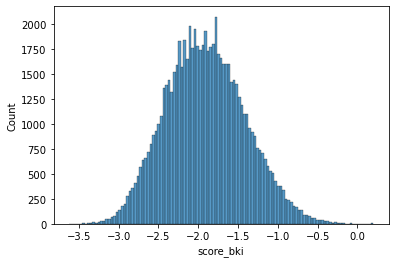

In [21]:
sns.histplot(x = df['score_bki']);

In [22]:
df[num_cols].describe()

age  decline_app_cnt     score_bki  bki_request_cnt  \
count  73799.000000     73799.000000  73799.000000     73799.000000   
mean      39.280641         0.275749     -1.904724         2.000339   
std       11.520378         0.804272      0.498231         2.252073   
min       21.000000         0.000000     -3.624586         0.000000   
25%       30.000000         0.000000     -2.259534         0.000000   
50%       37.000000         0.000000     -1.920823         1.000000   
75%       48.000000         0.000000     -1.569831         3.000000   
max       72.000000        33.000000      0.199773        53.000000   

       region_rating          income       app_day     app_month  \
count   73799.000000    73799.000000  73799.000000  73799.000000   
mean       56.725701    41099.775417     15.966517      2.537053   
std        13.055717    46166.322400      8.602978      1.089098   
min        20.000000     1000.000000      1.000000      1.000000   
25%        50.000000    20000.000000      9.000000      2.000000   
50%        50.000000    30000.000000     16.000000      3.000000   
75%        60.000000    48000.000000     23.000000      3.000000   
max        80.000000  1000000.000000     31.000000      4.000000   

        app_weekday  app_passed_days  
count  73799.000000     73799.000000  
mean       2.672231        61.035434  
std        1.897352        32.121884  
min        0.000000         0.000000  
25%        1.000000        33.000000  
50%        3.000000        62.000000  
75%        4.000000        89.000000  
max        6.000000       119.000000

#### Выводы по числовым признакам:
- *age*: график распределения возраста смещен влево, возраст имеет значения от 21 года до 72 лет и медианой 37 лет
- *decline_app_cnt* (количество отказанных прошлых заявок): распределение также смещено влево, большинству клиентов (более 75%) раньше не отказывали в кредите, есть небольшое количество клиентов, кому отказывали много раз, максимальный результат - 33 раза. Вполне возможно, что это не выброс и такая ситуация действительно возможна.
- *score_bki* (скоринговый балл): признак распределен нормально, однако, он имеет очень много отрицательных значений - это ошибка. См. диапазон скорингового балла ниже.
- *bki_request_cnt* (количество запросов в БКИ): распределение признака смещено влево, более 75% клиентов имеют значение менее 3 запросов (см. график), но есть те, у кого количество запросов достигает больших значений. Максимум - 53 запроса
- *region_rating*: рейтинг региона варьируется от 20 до 80
- *income*: доход клиентов варьируется от 1 000 до 1 000 000 с медианным показателем 30 000
- *app_day*, *app_month*, *app_weekday*: принимают значения от 1 до 31, от 1 до 4 и от 0 до 6 соответственно
- *app_passed_days* (количество дней с начала 2014 до даты подачи заявки): в датасете находятся данные только за первые 4 месяца 2014 года, количество заявок по дням похоже на равномерное распределение за исключением начала года. В начале года заявок несколько меньше - возможно из-за НГ праздников. Также можно отметить, что к концу месяца заявок также становится меньше - что позволяет наблюдать некую цикличность.

*Расчет кредитного рейтинга*
заемщика производится пока тремя самыми крупными БКИ, информация заемщикам передается двумя БКИ: НБКИ, ОКБ. Системы расчетов скорингового балла в разных БКИ различны, поэтому максимальный балл также различается в зависимости от компании. Например, в НБКИ – 850 баллов.

Расчет рейтинга заемщика может быть произведен по трем шкалам:
- 300–850;
- 0–999;
- 1–999.

![jupyter](./score.png)

#### Преобразование числовых признаков:

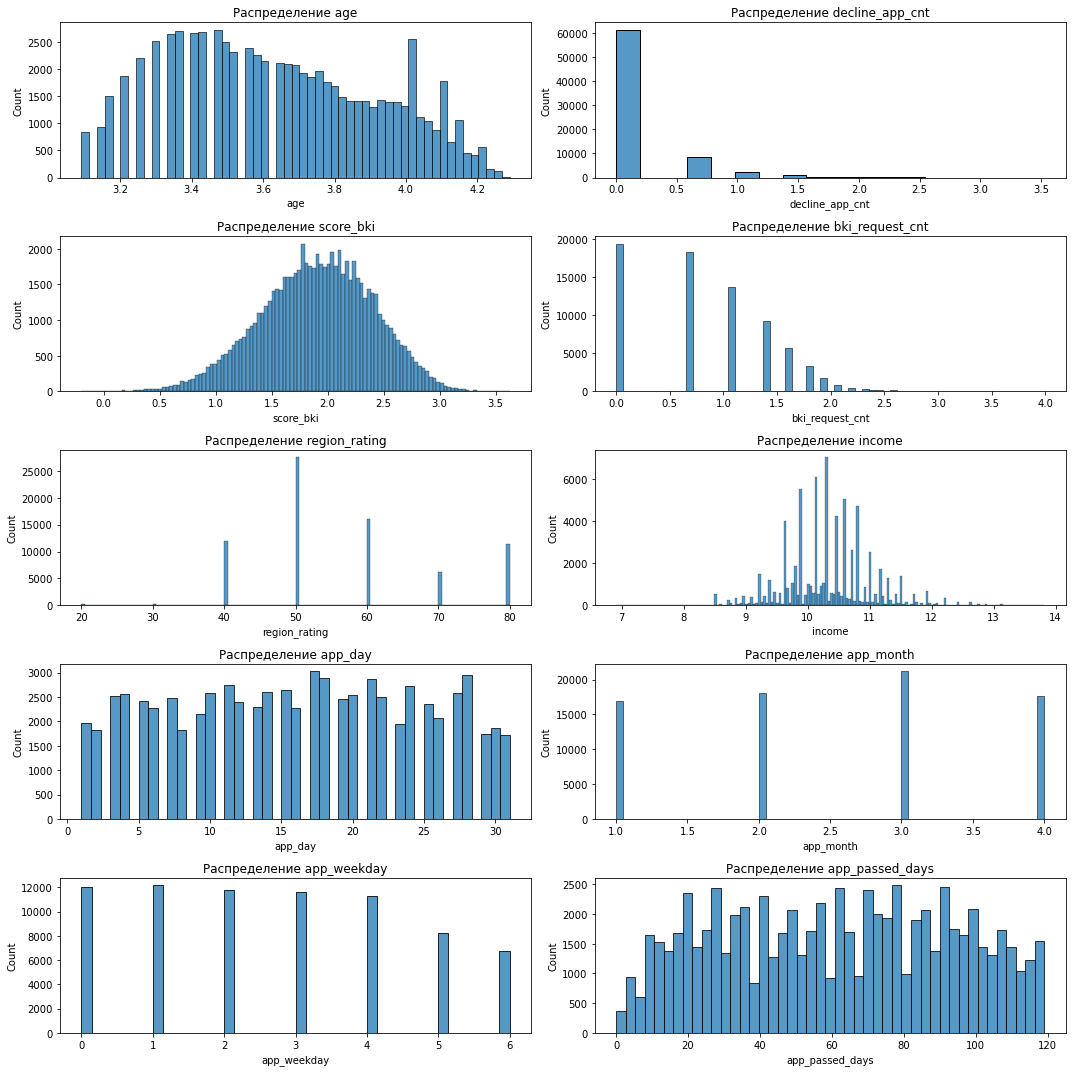

In [23]:
# Переводим значения скорингового балла в положительные значения (зеркальное отображение)
df["score_bki"] = -df["score_bki"]

# Признаки, которые имеют ярко выраженное смещение вправо - логарифмируем, для того,
# чтобы распределение было больше похоже на нормальное:
for i in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    df[i] = np.log(df[i]+1)
    
# Распределение числовых переменных после преобразования:
plt.figure(figsize=[15, 15])
i = 1
for col in num_cols:
    plt.subplot(5, 2, i)
    plt.title(f"Распределение {col}")
    sns.histplot(df[col], kde=False)
    i += 1
plt.tight_layout()
plt.show()

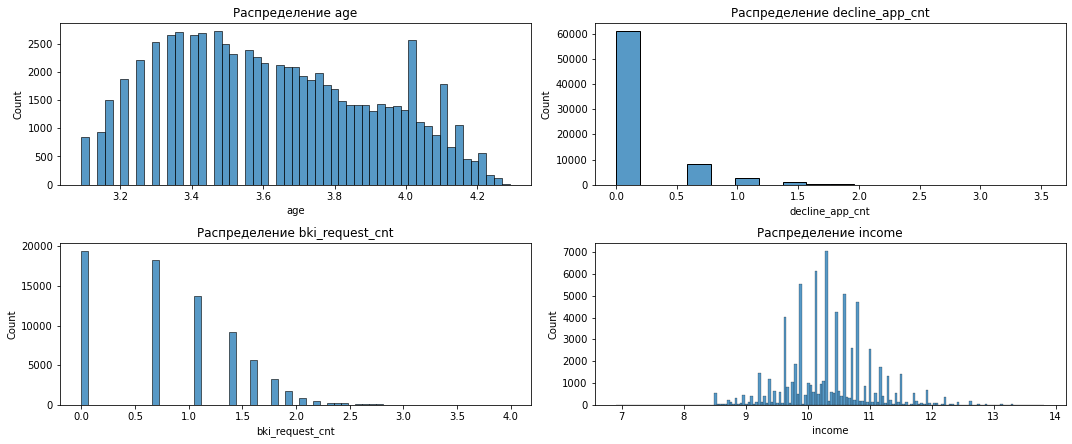

In [23]:
# Переводим значения скорингового балла в положительные значения (зеркальное отображение)
df["score_bki"] = -df["score_bki"]

# Признаки, которые имеют ярко выраженное смещение вправо - логарифмируем, для того,
# чтобы распределение было больше похоже на нормальное:
for i in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    df[i] = np.log(df[i]+1)
    
# Распределение числовых переменных после преобразования:
plt.figure(figsize=[15, 15])
i = 1
for col in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    plt.subplot(5, 2, i)
    plt.title(f"Распределение {col}")
    sns.histplot(df[col], kde=False)
    i += 1
plt.tight_layout()
plt.show()

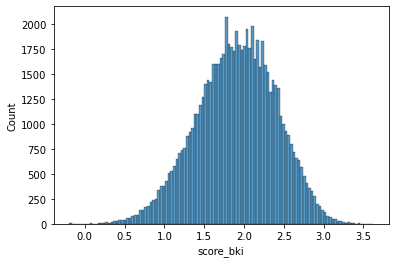

In [24]:
sns.histplot(x = df['score_bki']);

### Бинарные

In [25]:
bin_cols

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [26]:
bins = df[bin_cols]
print('Уникальные значения каждого категориального признака:')
for col in bins:
    print(col, ': ', df[col].unique())

Уникальные значения каждого категориального признака:
sex :  ['M' 'F']
car :  ['Y' 'N']
car_type :  ['Y' 'N']
good_work :  [0 1]
foreign_passport :  ['N' 'Y']


In [27]:
# Распределение бинарных признаков
for col in bins:
    print(round(df[col].value_counts(normalize=True), 2).to_frame())
    print()

    sex
F  0.56
M  0.44

    car
N  0.68
Y  0.32

   car_type
N      0.81
Y      0.19

   good_work
0       0.84
1       0.16

   foreign_passport
N              0.85
Y              0.15



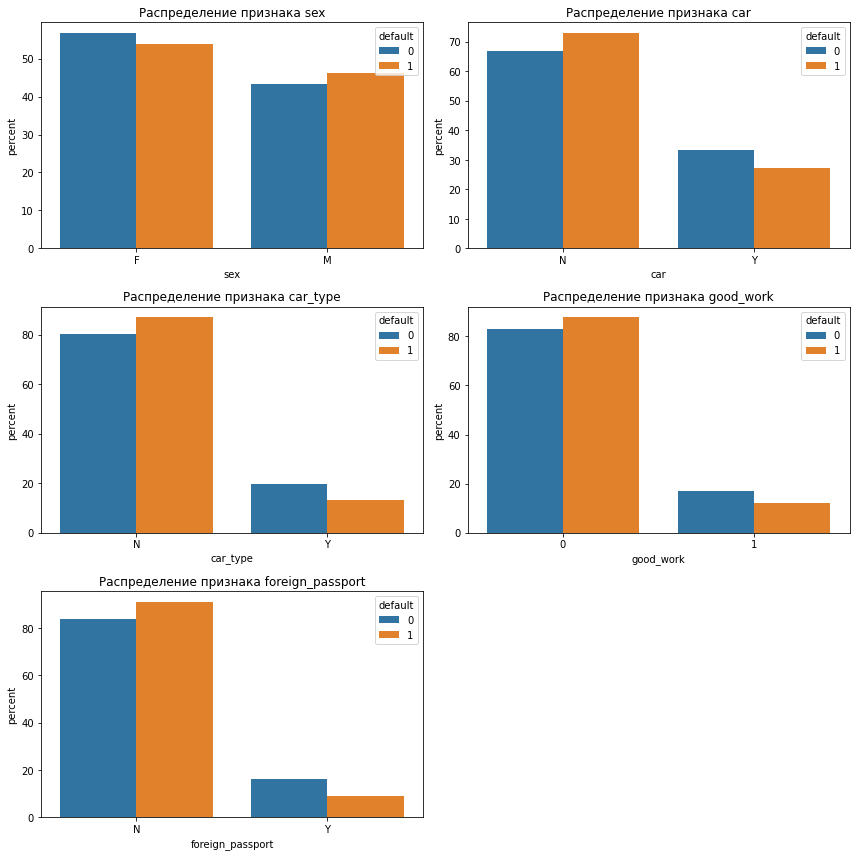

In [28]:
# Распределение показателя дефолта по бинарному признаку:

plt.figure(figsize=(12, 12))
k=1
for col in bins:
    plt.subplot(3, 2, k)
    prop_df = df[col].groupby(df["default"]).value_counts(normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")
    k += 1
plt.tight_layout()
plt.show()

#### Выводы по бинарным признакам:
- Женщин и мужчин примерно одинаково. Женщины менее склонны к дефолту, чем мужчины.
- Клиентов с машиной примерно в 2 раза меньше, чем без машины. Те, у кого есть машина, а также если это иномарка - более кредитоспособны. 
- Наличие 'хорошей работы' и загран. паспорта увеличивает шансы в выдаче кредита, однако таких клиентов мало.

#### Преобразование бинарных признаков:

In [29]:
# Кодируем бинарные признаки

mapp = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    mapp[col] = dict(enumerate(label_encoder.classes_))

mapp

{'sex': {0: 'F', 1: 'M'},
 'car': {0: 'N', 1: 'Y'},
 'car_type': {0: 'N', 1: 'Y'},
 'good_work': {0: 0, 1: 1},
 'foreign_passport': {0: 'N', 1: 'Y'}}

In [30]:
print('Уникальные значения каждого категориального признака:')
for col in bins:
    print(col, ': ', df[col].unique())

Уникальные значения каждого категориального признака:
sex :  [1 0]
car :  [1 0]
car_type :  [1 0]
good_work :  [0 1]
foreign_passport :  [0 1]


In [31]:
df.head(3)

client_id education  sex       age  car  car_type  decline_app_cnt  \
0      25905       SCH    1  4.143135    1         1         0.000000   
1      63161       SCH    0  4.094345    0         0         0.000000   
2      25887       SCH    1  3.258097    1         0         1.098612   

   good_work  score_bki  bki_request_cnt  ...  work_address     income  sna  \
0          0   2.008753         0.693147  ...             2   9.798183    4   
1          0   1.532276         1.386294  ...             3   9.852247    4   
2          0   1.408142         0.693147  ...             2  10.308986    1   

   first_time  foreign_passport  default  app_day  app_month  app_weekday  \
0           1                 0        0        1          2            5   
1           1                 0        0       12          3            2   
2           4                 1        0        1          2            5   

   app_passed_days  
0               31  
1               70  
2               31  

[3 rows x 22 columns]

### Категориальные

In [32]:
cat_cols

['education', 'home_address', 'work_address', 'sna', 'first_time']

- education - уровень образования
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике

In [33]:
categ = df[cat_cols]
print('Уникальные значения каждого категориального признака:')
for col in categ:
    print(col, ': ', df[col].unique())

Уникальные значения каждого категориального признака:
education :  ['SCH' 'GRD' 'UGR' 'PGR' 'ACD']
home_address :  [1 2 3]
work_address :  [2 3 1]
sna :  [4 1 2 3]
first_time :  [1 4 3 2]


In [34]:
# Распределение бинарных признаков
for col in categ:
    print(round(df[col].value_counts(normalize=True), 2).to_frame())
    print()

     education
SCH       0.53
GRD       0.32
UGR       0.13
PGR       0.02
ACD       0.00

   home_address
2          0.54
1          0.44
3          0.02

   work_address
3          0.61
2          0.28
1          0.11

    sna
1  0.64
4  0.16
2  0.14
3  0.06

   first_time
3        0.42
4        0.25
1        0.17
2        0.16



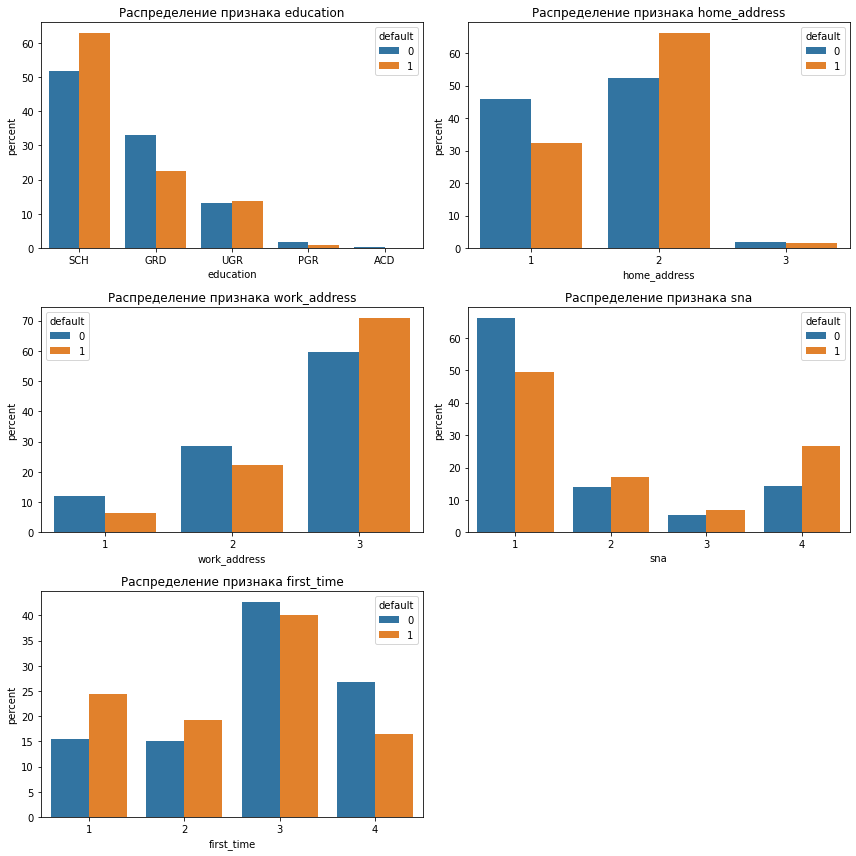

In [35]:
# Распределение показателя дефолта по бинарному признаку:

plt.figure(figsize=(12, 12))
k=1
for col in categ:
    plt.subplot(3, 2, k)
    prop_df = df[col].groupby(df["default"]).value_counts(normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")
    k += 1
plt.tight_layout()
plt.show()

#### Выводы по категориальным признакам:

- *education*: чем выше уровень образования у клиента, тем выше вероятность вернуть кредит. Данный признак является ординальным признаком, поэтому можно перекодировать его значения так, чтобы значения возрастали при увеличении уровня образования, от 0 - школа, до 4 - академик.
- *home_address*: домашние адреса распределены по 3 категориям. Клиенты, проживающие в 1 категории адреса более кредитоспособны, чем во второй и в третьей. Можно предположить, что группировка идет от домов премиум класса к эконом.
- *work_address*: рабочие адреса также распределены по 3 категориям. Клиенты, работающие в 1 и 2 категориях адреса более кредитоспособны, чем работающие в 3 категории - возможно это классификация категории офиса (класс А, В, С)
- *sna* (связь заемщика с клиентами банка): чем выше показатель, тем выше риск невозврата кредита по отношению к общему числу кредитов этого класса
- *first_time* (давность наличия информациии о заемщике): чем выше показатель (3 и 4 категория), тем более благонадежен клиент

#### Преобразование категориальных признаков:

In [36]:
df["education"].unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD'], dtype=object)

In [37]:
# Перекодирование признака "education", от 0 - школа, до 4 - академик:
categories = ["SCH", "UGR", "GRD", "PGR", "ACD"]
df["education"] = OrdinalEncoder(categories=[categories]).fit_transform(
    df[["education"]])[:, 0].astype(int)

In [38]:
df.head()

client_id  education  sex       age  car  car_type  decline_app_cnt  \
0      25905          0    1  4.143135    1         1         0.000000   
1      63161          0    0  4.094345    0         0         0.000000   
2      25887          0    1  3.258097    1         0         1.098612   
3      16222          0    0  3.988984    0         0         0.000000   
4     101655          2    1  3.891820    0         0         0.000000   

   good_work  score_bki  bki_request_cnt  ...  work_address     income  sna  \
0          0   2.008753         0.693147  ...             2   9.798183    4   
1          0   1.532276         1.386294  ...             3   9.852247    4   
2          0   1.408142         0.693147  ...             2  10.308986    1   
3          0   2.057471         1.098612  ...             3   9.210440    1   
4          1   1.244723         0.693147  ...             3  10.308986    1   

   first_time  foreign_passport  default  app_day  app_month  app_weekday  \
0           1                 0        0        1          2            5   
1           1                 0        0       12          3            2   
2           4                 1        0        1          2            5   
3           3                 0        0       23          1            3   
4           4                 1        0       18          4            4   

   app_passed_days  
0               31  
1               70  
2               31  
3               22  
4              107  

[5 rows x 22 columns]

#### Проверка независимости категориальных переменных (Тест хи-квадрат)

In [39]:
df[cat_cols]

education  home_address  work_address  sna  first_time
0              0             1             2    4           1
1              0             2             3    4           1
2              0             1             2    1           4
3              0             2             3    1           3
4              2             2             3    1           4
...          ...           ...           ...  ...         ...
73794          2             1             2    4           4
73795          0             2             2    1           4
73796          0             2             3    2           2
73797          0             1             3    2           3
73798          2             2             3    1           3

[73799 rows x 5 columns]

In [40]:
# Статистическая гипотеза хи-квадрат Пирсона - это проверка независимости категориальных переменных.

# Нулевая гипотеза ( H0 ) утверждает, что нет никакой связи между переменными. 
# Альтернативная гипотеза могла бы утверждать, что между ними существует значительная связь .

# H0: выборки независимы.
# H1: существует зависимость между выборками.

# Используя p-значение :
# Мы определяем фактор значимости, чтобы определить, имеет ли отношение между переменными значимость. 
# Обычно выбирается коэффициент значимости или значение альфа 0,05. 
# Альфа-значение обозначает вероятность ошибочного отклонения H0, когда оно истинно. 
# Если значение p для теста оказывается строго больше, чем значение альфа, то H0 остается верным.

from scipy.stats import chi2_contingency

stat, p, dof, expected = chi2_contingency(df[cat_cols])
alpha = 0.05 # определение p-value
print ( "p = " + str (p))
if p <= alpha:
    print ( 'Зависимы (Нулевая гипотеза (H0) отвергается' )
else :
    print ( 'Независимы, нулевая гипотеза (H0) не отвергается' )

p = 1.0
Независимы, нулевая гипотеза (H0) не отвергается


#### Get_dummies

In [41]:
cat_cols

['education', 'home_address', 'work_address', 'sna', 'first_time']

In [42]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df.head()

client_id  sex       age  car  car_type  decline_app_cnt  good_work  \
0      25905    1  4.143135    1         1         0.000000          0   
1      63161    0  4.094345    0         0         0.000000          0   
2      25887    1  3.258097    1         0         1.098612          0   
3      16222    0  3.988984    0         0         0.000000          0   
4     101655    1  3.891820    0         0         0.000000          1   

   score_bki  bki_request_cnt  region_rating  ...  home_address_2  \
0   2.008753         0.693147             50  ...               0   
1   1.532276         1.386294             50  ...               1   
2   1.408142         0.693147             80  ...               0   
3   2.057471         1.098612             50  ...               1   
4   1.244723         0.693147             60  ...               1   

   home_address_3  work_address_2  work_address_3  sna_2  sna_3  sna_4  \
0               0               1               0      0      0      1   
1               0               0               1      0      0      1   
2               0               1               0      0      0      0   
3               0               0               1      0      0      0   
4               0               0               1      0      0      0   

   first_time_2  first_time_3  first_time_4  
0             0             0             0  
1             0             0             0  
2             0             0             1  
3             0             1             0  
4             0             0             1  

[5 rows x 31 columns]

#### Отделение "client_id"

In [43]:
index = df['client_id'].values
index.transpose

<function ndarray.transpose>

In [44]:
index

array([ 25905,  63161,  25887, ..., 103695,    861,  15796], dtype=int64)

In [45]:
# Удаление столбца с номером клиента

df.drop('client_id', axis=1, inplace=True)
df.head(3)

sex       age  car  car_type  decline_app_cnt  good_work  score_bki  \
0    1  4.143135    1         1         0.000000          0   2.008753   
1    0  4.094345    0         0         0.000000          0   1.532276   
2    1  3.258097    1         0         1.098612          0   1.408142   

   bki_request_cnt  region_rating     income  ...  home_address_2  \
0         0.693147             50   9.798183  ...               0   
1         1.386294             50   9.852247  ...               1   
2         0.693147             80  10.308986  ...               0   

   home_address_3  work_address_2  work_address_3  sna_2  sna_3  sna_4  \
0               0               1               0      0      0      1   
1               0               0               1      0      0      1   
2               0               1               0      0      0      0   

   first_time_2  first_time_3  first_time_4  
0             0             0             0  
1             0             0             0  
2             0             0             1  

[3 rows x 30 columns]

#### Корреляционный анализ

<AxesSubplot:title={'center':'Correlation Matrix of dataset features'}>

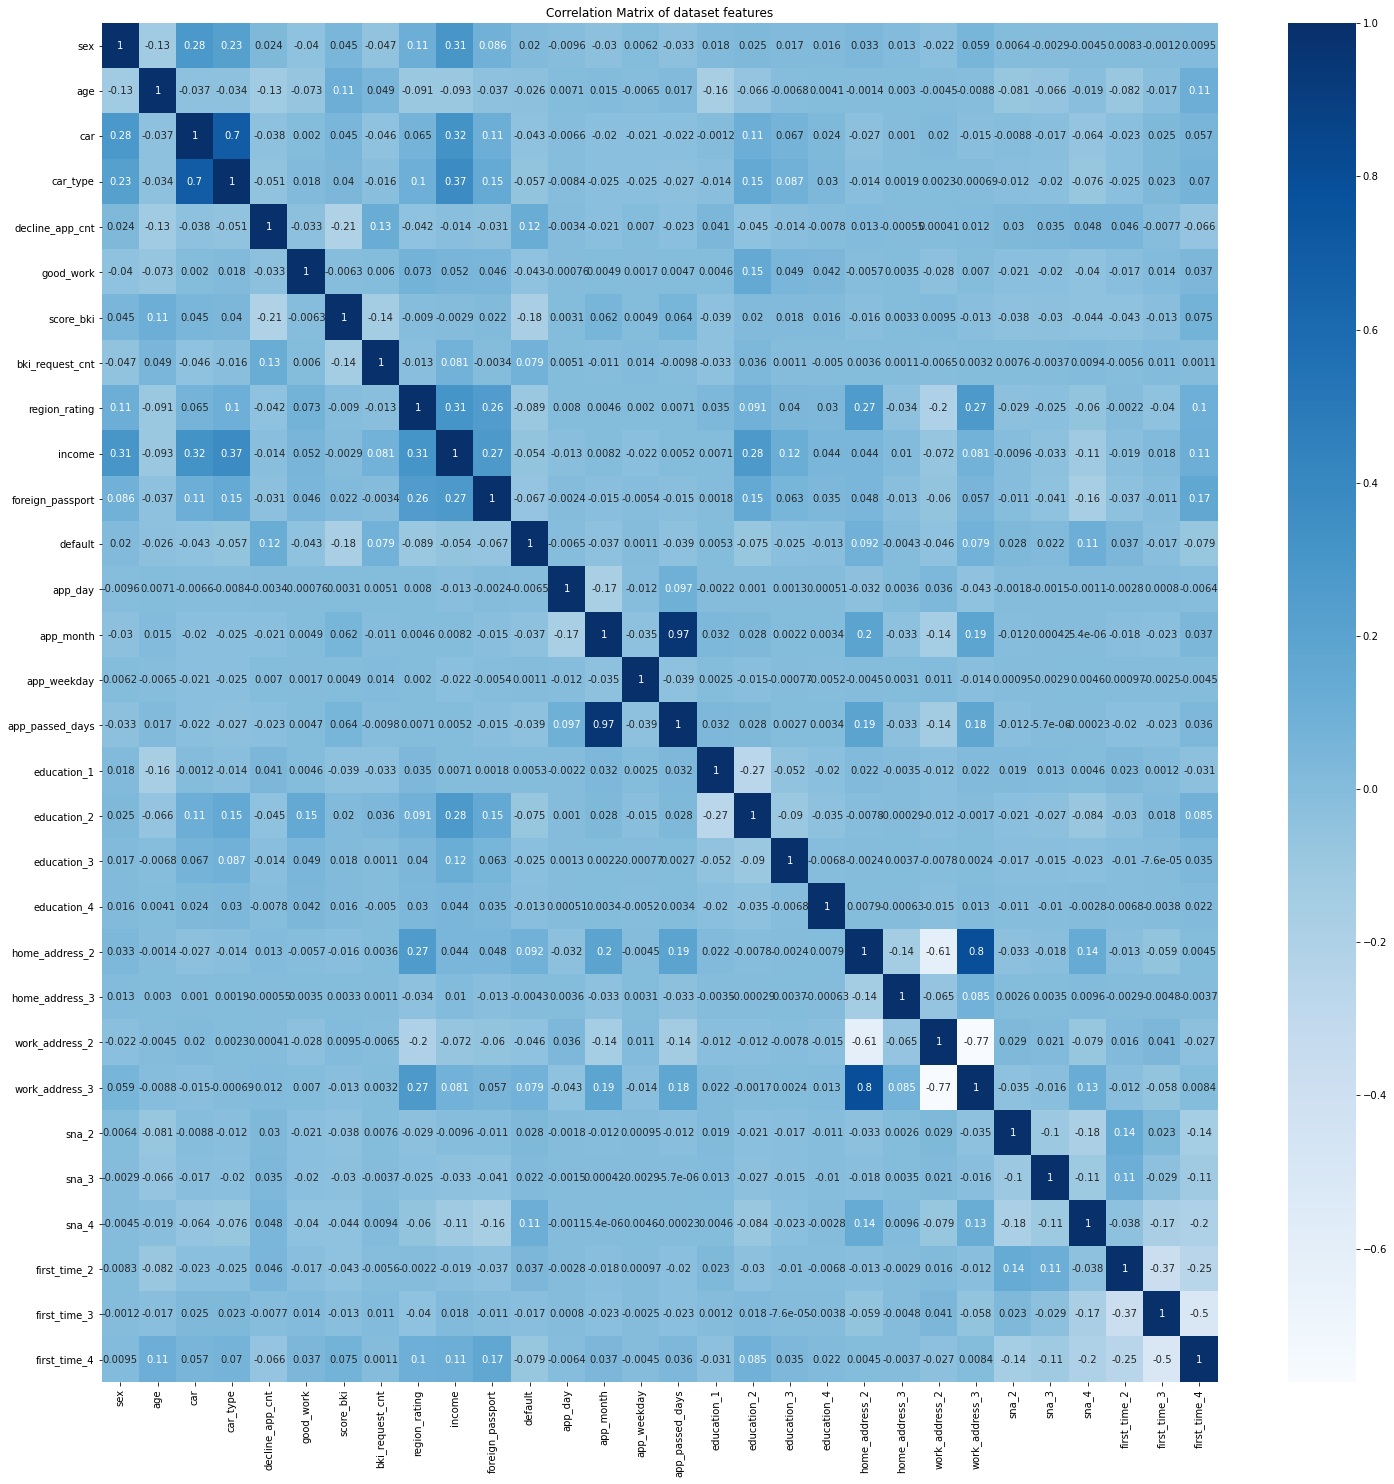

In [47]:
plt.title('Correlation Matrix of dataset features')
plt.rcParams['figure.figsize'] = (25,25)
sns.heatmap(df.corr(), annot = True, cmap='Blues')

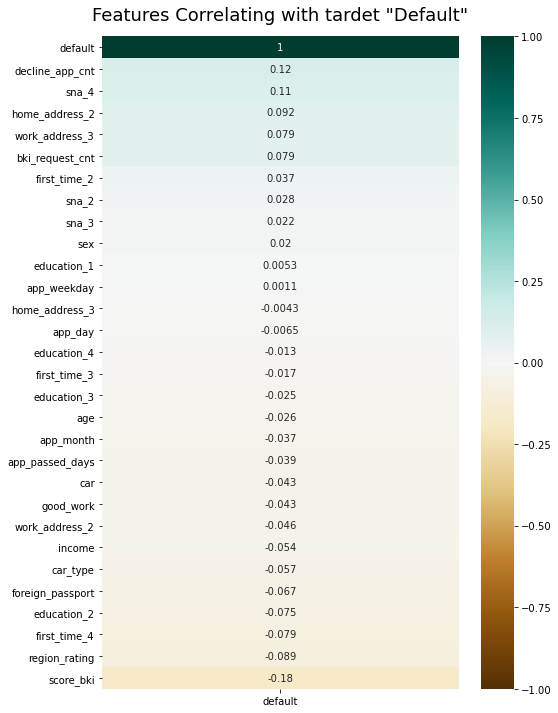

In [45]:
# Корреляция каждого признака с таргетом по убываюнию

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['default']].sort_values(by='default', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Features Correlating with tardet "Default"', fontdict={'fontsize':18}, pad=16);

In [46]:
# Определение ранга матрицы:

matrix = df.values # переавожу данные в матрицу, взяв значения признаков
# для визуального удобства перевожу в матрицу в таблицу
dataset=pd.DataFrame(data=matrix[0:,0:],
                     index=[i for i in range(matrix.shape[0])],
                     columns=['f'+str(i) for i in range(matrix.shape[1])])
dataset.head()

f0        f1   f2   f3        f4   f5        f6        f7    f8  \
0  1.0  4.143135  1.0  1.0  0.000000  0.0  2.008753  0.693147  50.0   
1  0.0  4.094345  0.0  0.0  0.000000  0.0  1.532276  1.386294  50.0   
2  1.0  3.258097  1.0  0.0  1.098612  0.0  1.408142  0.693147  80.0   
3  0.0  3.988984  0.0  0.0  0.000000  0.0  2.057471  1.098612  50.0   
4  1.0  3.891820  0.0  0.0  0.000000  1.0  1.244723  0.693147  60.0   

          f9  ...  f20  f21  f22  f23  f24  f25  f26  f27  f28  f29  
0   9.798183  ...  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
1   9.852247  ...  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  
2  10.308986  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
3   9.210440  ...  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  
4  10.308986  ...  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 30 columns]

In [47]:
# Определение ранга матрицы признаков, расчет:

rank = LA.matrix_rank(dataset)
colms = len(df.columns)
print('Matrix rank =', rank)
print('Nums of columns =', colms)

Matrix rank = 30
Nums of columns = 30


#### Значимость признаков

Дисперсионный  анализ ANOVA (analysis of variance) используется для проверки влияния переменных друг на друга. 
Данный метод направлен на поиск зависимостей в данных путём исследования значимости различий в средних значениях. В отличие от t-критерия, позволяет сравнивать средние значения трёх и более групп. Разработан Р. Фишером для анализа результатов экспериментальных исследований.

<AxesSubplot:>

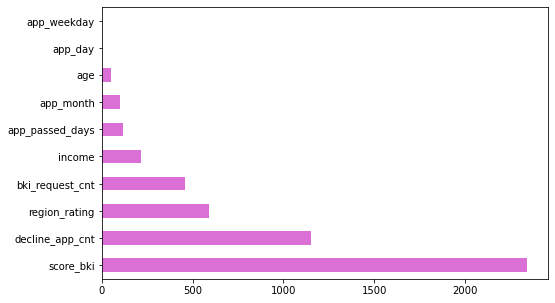

In [48]:
# Анализ ANOVA для определения значимости числовых признаков:

imp_num = pd.Series(f_classif(df[num_cols], df["default"])[0], index=num_cols)
imp_num.sort_values(inplace=True, ascending=False)
plt.figure(figsize=(8, 5))
imp_num.plot(kind="barh", facecolor='orchid')

In [49]:
cat_cols = ["education_1", "education_2", "education_3", "education_4",
            "home_address_2", "home_address_3",
            "work_address_2", "work_address_3",
            "sna_2", "sna_3", "sna_4",
            "first_time_2", "first_time_3", "first_time_4"]

<AxesSubplot:>

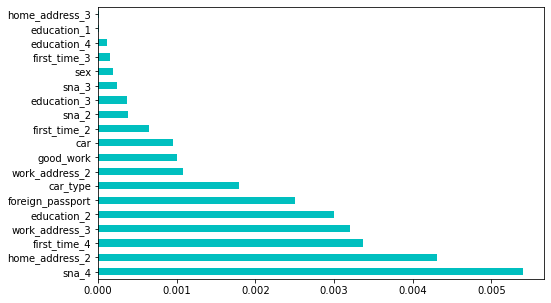

In [50]:
# определим значимость категориальных и бинарных признаков
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df["default"],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True, ascending=False)
plt.figure(figsize=(8, 5))
imp_cat.plot(kind="barh", facecolor='c') 

#### Выводы по Корреляции и Значимости

- Существенная корреляция между домашним адресом и местом работы (0.8).
- Сильная корреляция между car, car_type (0.7). Отсутствие автомобиля и соответственное отсутствие признака, что автомобиль иностранный. Можно попробовать соединить два признака в один, получив новый категориальный признак. Так можно уменьшить размерность набора данных, но не потерять информацию.
- Есть довольно сильная обратная зависимость между sna, first_time. 

- Менее значимые признаки: app_day и app_weekday
- Наиболее статистически значимые категориальные признаки - sna и first_time.
- Наиболее статистически значимые числовые признаки - Score_bki, decline_app_cnt. Мультиколлинеарность в целом отсутствует, что подтверждается рангом матрицы. 

--- ***Рангом называют максимальное число линейно независимых строк (столбцов) матрицы.*** Линейная независимость означает, что строки (столбцы) не могут быть линейно выражены через другие строки (столбцы).


#### Кодирование цикличных признаков (время)

In [48]:
df.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income',
       'foreign_passport', 'default', 'app_day', 'app_month', 'app_weekday',
       'app_passed_days', 'education_1', 'education_2', 'education_3',
       'education_4', 'home_address_2', 'home_address_3', 'work_address_2',
       'work_address_3', 'sna_2', 'sna_3', 'sna_4', 'first_time_2',
       'first_time_3', 'first_time_4'],
      dtype='object')

In [49]:
print("app_month, unique:", df['app_month'].unique())
print("app_weekday, unique:", df['app_weekday'].unique())
print("app_day, unique:", df['app_day'].unique())

app_month, unique: [2 3 1 4]
app_weekday, unique: [5 2 3 4 1 0 6]
app_day, unique: [ 1 12 23 18  4 17 14 10  3  8 19 22 30 11  2  6 24 15 28  9 31 26 13 25
 21 20 16 27  7  5 29]


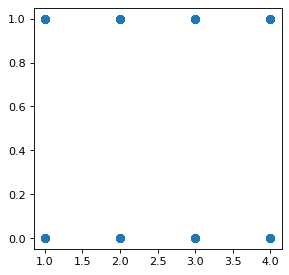

In [50]:
x = df['app_month']
y = df['default']

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(x, y)

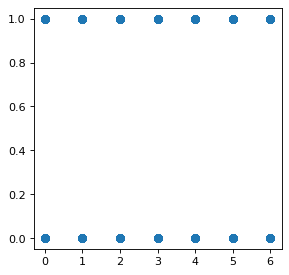

In [51]:
x = df['app_weekday']
y = df['default']

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(x, y)

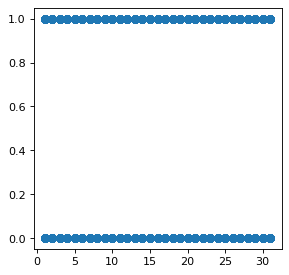

In [52]:
x = df['app_day']
y = df['default']

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(x, y)

In [53]:
# Т.к. признаки 'app_day', 'app_month', 'app_weekday' относятся ко времени - они цикличны
# Не смотря на то, что в данном датасете присутствуют только первые 4 месяца (а не 12) - их нельзя сравнивать в числовом виде.
# Например апрель (= 4) не может быть численно больше января (= 1)
# Вышеуказанные признаки необходимо закодировать через синус и косинус (это масштабирует данные, сохраняя цикличность):

month =  12
weekday = 7
days = 31

# Нормализация x от 0 до 2π, что соответствует одному косинусному циклу

df["month_norm"] = 2 * math.pi * df["app_month"] / df["app_month"].max()
df["weekday_norm"] = 2 * math.pi * df["app_weekday"] / df["app_weekday"].max()
df["day_norm"] = 2 * math.pi * df["app_day"] / df["app_day"].max()

# Кодирование

df["sin_month"] = np.sin(df["month_norm"])
df["cos_month"] = np.cos(df["month_norm"])

df["sin_weekday"] = np.sin(df["weekday_norm"])
df["cos_weekday"] = np.cos(df["weekday_norm"])

df["sin_day"] = np.sin(df["day_norm"])
df["cos_day"] = np.cos(df["day_norm"])


df[['sin_month', 'cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day']].head(5)

sin_month     cos_month   sin_weekday  cos_weekday   sin_day   cos_day
0  1.224647e-16 -1.000000e+00 -8.660254e-01          0.5  0.201299  0.979530
1 -1.000000e+00 -1.836970e-16  8.660254e-01         -0.5  0.651372 -0.758758
2  1.224647e-16 -1.000000e+00 -8.660254e-01          0.5  0.201299  0.979530
3  1.000000e+00  6.123234e-17  1.224647e-16         -1.0 -0.998717 -0.050649
4 -2.449294e-16  1.000000e+00 -8.660254e-01         -0.5 -0.485302 -0.874347

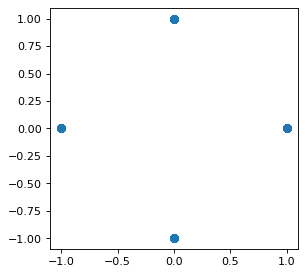

In [54]:
x = df['sin_month']
y = df['cos_month']

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(x, y)

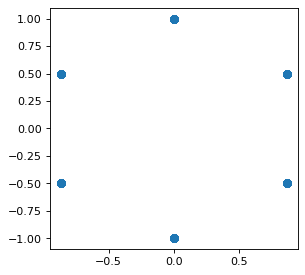

In [55]:
x = df['sin_weekday']
y = df['cos_weekday']

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(x, y)

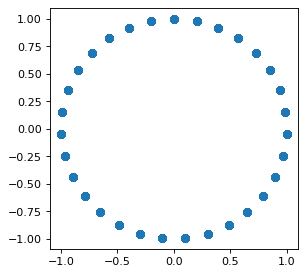

In [56]:
x = df['sin_day']
y = df['cos_day']

plt.figure(figsize=(4, 4), dpi=80)
plt.scatter(x, y)

In [57]:
# Проверка на 25-ти рандомных значениях из датасета:

import plotly.graph_objects as go

df_selected = df[["sin_day","cos_day"]].sample(25).sort_index()
display(df_selected)

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_selected.cos_day, y=df_selected.sin_day, mode="markers"))

fig.update_layout(xaxis = dict(title="cos_day"),
                  yaxis = dict(title="sin_day", scaleanchor = "x", scaleratio = 1))

fig.show()

sin_day   cos_day
644    0.790776 -0.612106
2398  -0.651372 -0.758758
2931   0.651372 -0.758758
6506  -0.790776 -0.612106
6783   0.988468  0.151428
9083  -0.790776 -0.612106
9666  -0.998717 -0.050649
16901  0.724793  0.688967
18782 -0.790776 -0.612106
21386 -0.485302 -0.874347
26219  0.394356  0.918958
27447 -0.968077 -0.250653
29078 -0.724793  0.688967
30861 -0.897805 -0.440394
31285 -0.485302 -0.874347
42562 -0.968077 -0.250653
44234  0.651372 -0.758758
50863 -0.988468  0.151428
53414 -0.299363 -0.954139
53836 -0.571268  0.820763
57212 -0.724793  0.688967
59068  0.988468  0.151428
64325 -0.299363 -0.954139
72798  0.724793  0.688967
73529 -0.848644  0.528964

In [58]:
df.columns
# нужно удалить лишние признаки - 'app_day', 'app_month', 'app_weekday', 'month_norm', 'weekday_norm', 'day_norm'

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income',
       'foreign_passport', 'default', 'app_day', 'app_month', 'app_weekday',
       'app_passed_days', 'education_1', 'education_2', 'education_3',
       'education_4', 'home_address_2', 'home_address_3', 'work_address_2',
       'work_address_3', 'sna_2', 'sna_3', 'sna_4', 'first_time_2',
       'first_time_3', 'first_time_4', 'month_norm', 'weekday_norm',
       'day_norm', 'sin_month', 'cos_month', 'sin_weekday', 'cos_weekday',
       'sin_day', 'cos_day'],
      dtype='object')

In [59]:
df.drop(['app_day', 'app_month', 'app_weekday', 'month_norm', 'weekday_norm', 'day_norm'], axis=1, inplace=True)
df.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income',
       'foreign_passport', 'default', 'app_passed_days', 'education_1',
       'education_2', 'education_3', 'education_4', 'home_address_2',
       'home_address_3', 'work_address_2', 'work_address_3', 'sna_2', 'sna_3',
       'sna_4', 'first_time_2', 'first_time_3', 'first_time_4', 'sin_month',
       'cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day'],
      dtype='object')

#### Масштабирование данных (нормализация)

In [60]:
df.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income',
       'foreign_passport', 'default', 'app_passed_days', 'education_1',
       'education_2', 'education_3', 'education_4', 'home_address_2',
       'home_address_3', 'work_address_2', 'work_address_3', 'sna_2', 'sna_3',
       'sna_4', 'first_time_2', 'first_time_3', 'first_time_4', 'sin_month',
       'cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day'],
      dtype='object')

In [61]:
# num_cols = 7
num_cols = ["age", "decline_app_cnt", "score_bki",
            "bki_request_cnt", "region_rating", "income", "app_passed_days"]

# bin_cols = 5
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"] 

# cat_cols = 14
cat_cols = ['education_1', 'education_2', 'education_3', 'education_4', 
            'home_address_2','home_address_3', 'work_address_2', 'work_address_3', 'sna_2', 'sna_3',
            'sna_4', 'first_time_2', 'first_time_3', 'first_time_4']

# other = 6
# other = 'sin_month','cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day'
# default - target

- Нормализация подразумевает изменение диапазонов в данных без изменения формы распределения
- Стандартизация изменяет форму распределения данных (приводится к нормальному распределению)

Поскольку выше было применено логарифмирование, на данном этапе Стандартизация не требуется.
Возможно Нормализация числовых признаков поможет добиться лучшего качества модели.

Алгоритмы машинного обучения работают лучше, когда различные функции (переменные) имеют меньший масштаб. 
Нормализация делает процесс обучения менее чувствительным к масштабу функций. Это приводит к улучшению коэффициентов после тренировки.

![jupyter](./Screenshot_4.png)

![jupyter](./Screenshot_1.png)

In [62]:
df[num_cols].head()

age  decline_app_cnt  score_bki  bki_request_cnt  region_rating  \
0  4.143135         0.000000   2.008753         0.693147             50   
1  4.094345         0.000000   1.532276         1.386294             50   
2  3.258097         1.098612   1.408142         0.693147             80   
3  3.988984         0.000000   2.057471         1.098612             50   
4  3.891820         0.000000   1.244723         0.693147             60   

      income  app_passed_days  
0   9.798183               31  
1   9.852247               70  
2  10.308986               31  
3   9.210440               22  
4  10.308986              107

In [63]:
# Нормализация числовых признаков:

norm = preprocessing.normalize(df[num_cols], axis=0)
df[num_cols] = pd.DataFrame(norm)

df[num_cols].head()

age  decline_app_cnt  score_bki  bki_request_cnt  region_rating  \
0  0.004160         0.000000   0.003756         0.002326       0.003162   
1  0.004111         0.000000   0.002865         0.004651       0.003162   
2  0.003271         0.010272   0.002633         0.002326       0.005059   
3  0.004005         0.000000   0.003847         0.003686       0.003162   
4  0.003907         0.000000   0.002327         0.002326       0.003794   

     income  app_passed_days  
0  0.003478         0.001654  
1  0.003497         0.003736  
2  0.003660         0.001654  
3  0.003270         0.001174  
4  0.003660         0.005711

In [64]:
df.head()

sex       age  car  car_type  decline_app_cnt  good_work  score_bki  \
0    1  0.004160    1         1         0.000000          0   0.003756   
1    0  0.004111    0         0         0.000000          0   0.002865   
2    1  0.003271    1         0         0.010272          0   0.002633   
3    0  0.004005    0         0         0.000000          0   0.003847   
4    1  0.003907    0         0         0.000000          1   0.002327   

   bki_request_cnt  region_rating    income  ...  sna_4  first_time_2  \
0         0.002326       0.003162  0.003478  ...      1             0   
1         0.004651       0.003162  0.003497  ...      1             0   
2         0.002326       0.005059  0.003660  ...      0             0   
3         0.003686       0.003162  0.003270  ...      0             0   
4         0.002326       0.003794  0.003660  ...      0             0   

   first_time_3  first_time_4     sin_month     cos_month   sin_weekday  \
0             0             0  1.224647e-16 -1.000000e+00 -8.660254e-01   
1             0             0 -1.000000e+00 -1.836970e-16  8.660254e-01   
2             0             1  1.224647e-16 -1.000000e+00 -8.660254e-01   
3             1             0  1.000000e+00  6.123234e-17  1.224647e-16   
4             0             1 -2.449294e-16  1.000000e+00 -8.660254e-01   

   cos_weekday   sin_day   cos_day  
0          0.5  0.201299  0.979530  
1         -0.5  0.651372 -0.758758  
2          0.5  0.201299  0.979530  
3         -1.0 -0.998717 -0.050649  
4         -0.5 -0.485302 -0.874347  

[5 rows x 33 columns]

# Признаки для моделирования (после всех преобразований)

In [65]:
df_agg = df.agg({'nunique', lambda s: s.unique()[:3]})\
    .append(pd.Series(df.isnull().sum(), name='null'))\
    .append(pd.Series(df.dtypes, name='dtype'))\
    .transpose()
df_agg

<lambda> nunique  \
sex                                                          [1, 0]       2   
age               [0.004159683419613136, 0.004110698375597309, 0...      52   
car                                                          [1, 0]       2   
car_type                                                     [1, 0]       2   
decline_app_cnt   [0.0, 0.010272384321176218, 0.006481152908351014]      21   
good_work                                                    [0, 1]       2   
score_bki         [0.0037557617138584904, 0.002864894067994282, ...   69096   
bki_request_cnt   [0.0023256224883518263, 0.0046512449767036525,...      38   
region_rating     [0.003161962744361067, 0.005059140390977708, 0...       7   
income            [0.003478302291990804, 0.003497494827749057, 0...     966   
foreign_passport                                             [0, 1]       2   
default                                                      [0, 1]       2   
app_passed_days   [0.001654489985246243, 0.0037359451279753873, ...     120   
education_1                                                  [0, 1]       2   
education_2                                                  [0, 1]       2   
education_3                                                  [0, 1]       2   
education_4                                                  [0, 1]       2   
home_address_2                                               [0, 1]       2   
home_address_3                                               [0, 1]       2   
work_address_2                                               [1, 0]       2   
work_address_3                                               [0, 1]       2   
sna_2                                                        [0, 1]       2   
sna_3                                                        [0, 1]       2   
sna_4                                                        [1, 0]       2   
first_time_2                                                 [0, 1]       2   
first_time_3                                                 [0, 1]       2   
first_time_4                                                 [0, 1]       2   
sin_month                       [1.2246467991473532e-16, -1.0, 1.0]       4   
cos_month         [-1.0, -1.8369701987210297e-16, 6.123233995736...       4   
sin_weekday       [-0.8660254037844386, 0.8660254037844387, 1.22...       7   
cos_weekday         [0.5000000000000001, -0.4999999999999998, -1.0]       5   
sin_day           [0.20129852008866006, 0.6513724827222223, -0.9...      31   
cos_day           [0.9795299412524945, -0.758758122692791, -0.05...      26   

                 null    dtype  
sex                 0    int32  
age                 0  float64  
car                 0    int32  
car_type            0    int32  
decline_app_cnt     0  float64  
good_work           0    int64  
score_bki           0  float64  
bki_request_cnt     0  float64  
region_rating       0  float64  
income              0  float64  
foreign_passport    0    int32  
default             0    int64  
app_passed_days     0  float64  
education_1         0    uint8  
education_2         0    uint8  
education_3         0    uint8  
education_4         0    uint8  
home_address_2      0    uint8  
home_address_3      0    uint8  
work_address_2      0    uint8  
work_address_3      0    uint8  
sna_2               0    uint8  
sna_3               0    uint8  
sna_4               0    uint8  
first_time_2        0    uint8  
first_time_3        0    uint8  
first_time_4        0    uint8  
sin_month           0  float64  
cos_month           0  float64  
sin_weekday         0  float64  
cos_weekday         0  float64  
sin_day             0  float64  
cos_day             0  float64

In [66]:
tab = df.describe().loc[['min','max']]
tab.to_excel("tab_describe.xlsx")
tab

sex       age  car  car_type  decline_app_cnt  good_work  score_bki  \
min  0.0  0.003103  0.0       0.0         0.000000        0.0  -0.000374   
max  1.0  0.004308  1.0       1.0         0.032973        1.0   0.006777   

     bki_request_cnt  region_rating    income  ...  sna_4  first_time_2  \
min         0.000000       0.001265  0.002453  ...    0.0           0.0   
max         0.013384       0.005059  0.004904  ...    1.0           1.0   

     first_time_3  first_time_4  sin_month  cos_month  sin_weekday  \
min           0.0           0.0       -1.0       -1.0    -0.866025   
max           1.0           1.0        1.0        1.0     0.866025   

     cos_weekday   sin_day   cos_day  
min         -1.0 -0.998717 -0.994869  
max          1.0  0.998717  1.000000  

[2 rows x 33 columns]

# Моделирование № 1

In [67]:
#  Деление на данных на train и test

X = df.drop('default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)

In [71]:
len(X_train)

59039

In [72]:
len(X_test)

14760

In [73]:
len(y_train)

59039

In [74]:
len(y_test)

14760

In [75]:
14760+59039

73799

In [68]:
from collections import Counter

X = df.drop('default', axis=1)
y = df['default']

print('Original dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 64427, 1: 9372})


## Baseline

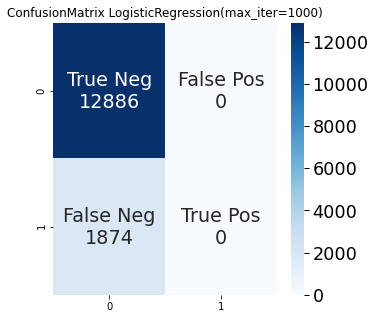

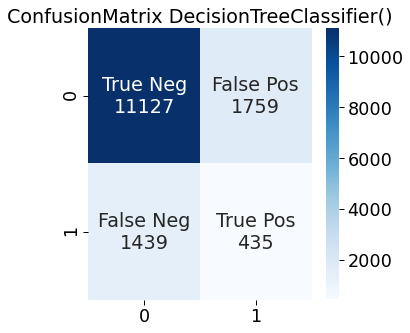

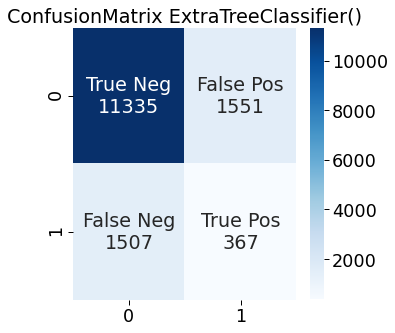

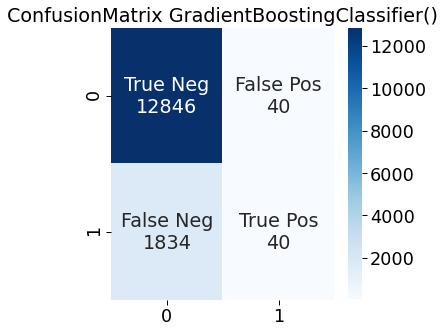

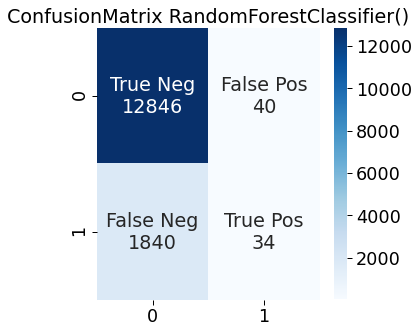

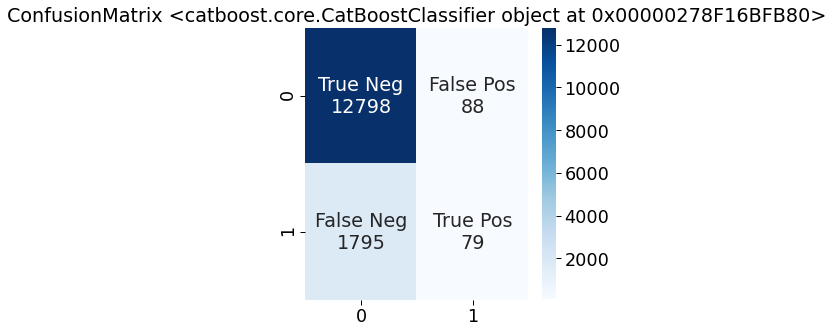

In [69]:
lr = LogisticRegression(max_iter=1000) # во избежание предупреждения о сходимости
tree = DecisionTreeClassifier()
extra_tree = ExtraTreeClassifier()
gboost = GradientBoostingClassifier()
rforest = RandomForestClassifier()
catboo = CatBoostClassifier(silent=True)
    
models = [lr, tree, extra_tree, gboost, rforest, catboo]

# Создание таблицы с метриками:
cols = ['Roc Auc', 'Accuracy', 'Precision', 'Recall', 'f1', 'Log loss']
lst = [] # Запись всех полученных метрик одним списком

# Разбивка списка на список списков (модель - 6 метрик, модель - 6 метрик и т.д.)
lst_1 = zip(*[iter(lst)]*6)


# Расчет метрик:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    lst.append(roc_auc_score(y_test, probs))
    lst.append(accuracy_score(y_test, y_pred))
    lst.append(precision_score(y_test, y_pred, zero_division=0))
    lst.append(recall_score(y_test, y_pred, zero_division=0))
    lst.append(f1_score(y_test, y_pred, zero_division=0))
    lst.append(log_loss(y_test, y_pred))
    
    # Матрица ошибок
    plt.figure(figsize=[5, 5])
    plt.title(F"ConfusionMatrix {model}")
    
    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    confusion_matrix(y_test, y_pred).flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')
    
# Таблица с метриками:
df1 = pd.DataFrame(list(lst_1), columns=cols)
df1 = df1.rename(index={0: 'LogisticR', 1: 'DecisionTree', 2: 'ExtraTree', 
                              3: 'GradientBoost', 4: 'RandomForest', 5: 'CatBoost'})
df_met = df1.T

In [70]:
def highlight_max(x, color):
    return np.where(x == np.nanmax(x.to_numpy()), f"color: {color};", None)

df_met.style.format('{:.4f}').apply(highlight_max, color='blue', axis=1) 

## Кривая Roc Auc

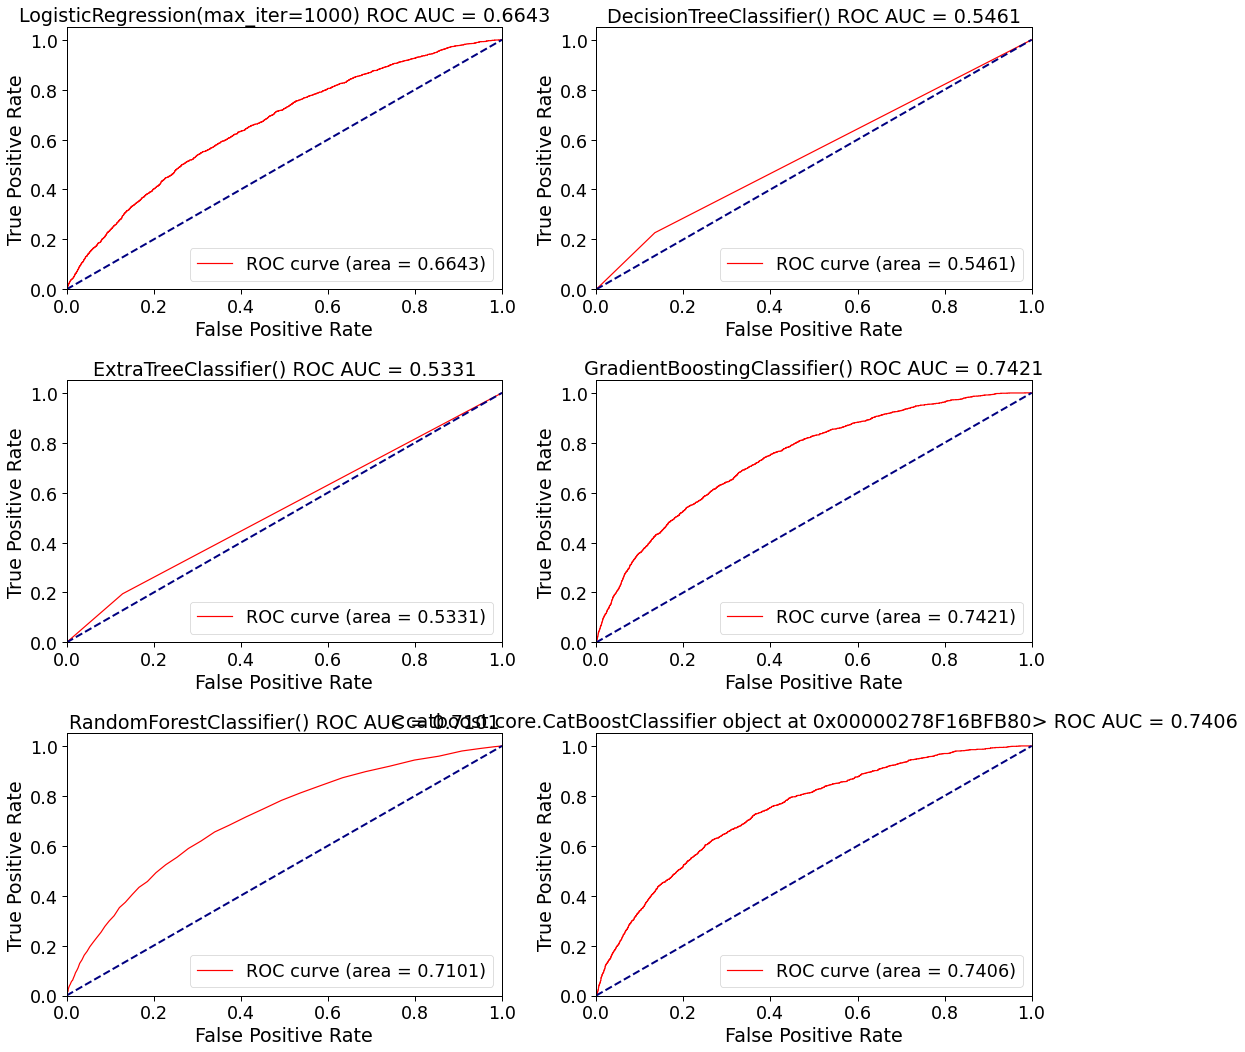

In [72]:
plt.figure(figsize=[15, 15])
k = 1
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    
    plt.subplot(3, 2, k)
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    name = model 
    num = float('{:.4f}'.format(roc_auc))
    
    plt.title(F"{name} ROC AUC = {num}")
    plt.legend(loc="lower right")
    k+=1
plt.tight_layout()
plt.show()

## Анализ важных признаков (Shap values)

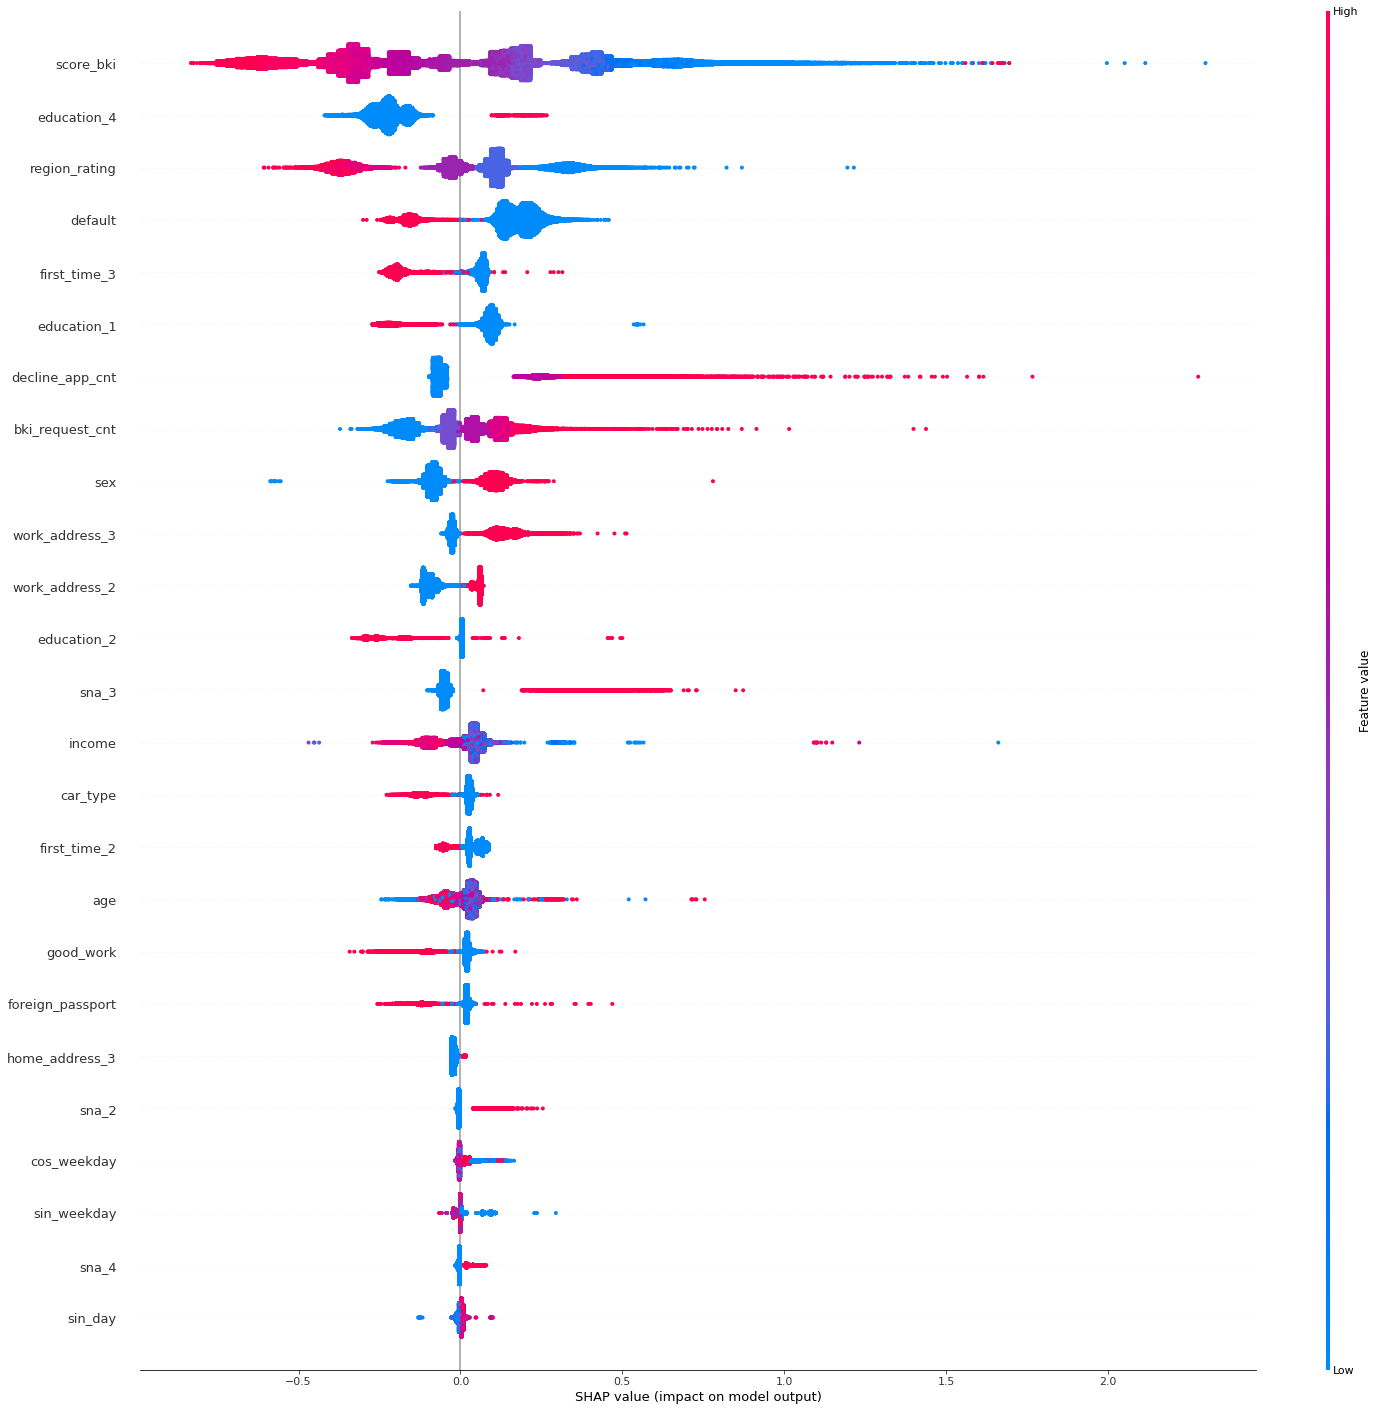

In [78]:
# SHapley Additive explanation:

shap_test = shap.TreeExplainer(gboost).shap_values(df)
shap.summary_plot(shap_test, df,
                      max_display=25, plot_size=None)

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точки на графике, тем выше значения фичи в ней

- чем больше значение признака score_bki, тем больше вероятность дефолта;
- чем больше значение признака age, тем меньше вероятность дефолта.

# Новые признаки

## Полиномиальные

Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

In [74]:
df_pol = df[['score_bki','age','income']]

polynom = PolynomialFeatures(degree=2).fit(df_pol)
data = pd.DataFrame(polynom.transform(df_pol), 
                                    columns=polynom.get_feature_names_out(df_pol.columns))

data.drop(['1','score_bki', 'age', 'income'], axis=1, inplace=True)

polynom_df = pd.concat([data,df],axis=1)
polynom_df

score_bki^2  score_bki age  score_bki income     age^2  age income  \
0         0.000014       0.000016          0.000013  0.000017    0.000014   
1         0.000008       0.000012          0.000010  0.000017    0.000014   
2         0.000007       0.000009          0.000010  0.000011    0.000012   
3         0.000015       0.000015          0.000013  0.000016    0.000013   
4         0.000005       0.000009          0.000009  0.000015    0.000014   
...            ...            ...               ...       ...         ...   
73794     0.000011       0.000013          0.000012  0.000015    0.000013   
73795     0.000015       0.000014          0.000015  0.000014    0.000015   
73796     0.000008       0.000010          0.000011  0.000012    0.000013   
73797     0.000008       0.000009          0.000009  0.000012    0.000011   
73798     0.000011       0.000012          0.000012  0.000013    0.000013   

       income^2  sex       age  car  car_type  ...  sna_4  first_time_2  \
0      0.000012    1  0.004160    1         1  ...      1             0   
1      0.000012    0  0.004111    0         0  ...      1             0   
2      0.000013    1  0.003271    1         0  ...      0             0   
3      0.000011    0  0.004005    0         0  ...      0             0   
4      0.000013    1  0.003907    0         0  ...      0             0   
...         ...  ...       ...  ...       ...  ...    ...           ...   
73794  0.000012    0  0.003844    0         0  ...      1             0   
73795  0.000016    1  0.003753    1         1  ...      0             0   
73796  0.000014    1  0.003480    0         0  ...      0             1   
73797  0.000011    0  0.003415    0         0  ...      0             0   
73798  0.000013    1  0.003570    0         0  ...      0             0   

       first_time_3  first_time_4     sin_month     cos_month   sin_weekday  \
0                 0             0  1.224647e-16 -1.000000e+00 -8.660254e-01   
1                 0             0 -1.000000e+00 -1.836970e-16  8.660254e-01   
2                 0             1  1.224647e-16 -1.000000e+00 -8.660254e-01   
3                 1             0  1.000000e+00  6.123234e-17  1.224647e-16   
4                 0             1 -2.449294e-16  1.000000e+00 -8.660254e-01   
...             ...           ...           ...           ...           ...   
73794             0             1 -1.000000e+00 -1.836970e-16  8.660254e-01   
73795             0             1 -1.000000e+00 -1.836970e-16  0.000000e+00   
73796             0             0 -2.449294e-16  1.000000e+00  8.660254e-01   
73797             1             0  1.000000e+00  6.123234e-17 -8.660254e-01   
73798             1             0  1.000000e+00  6.123234e-17  1.224647e-16   

       cos_weekday   sin_day   cos_day  
0              0.5  0.201299  0.979530  
1             -0.5  0.651372 -0.758758  
2              0.5  0.201299  0.979530  
3             -1.0 -0.998717 -0.050649  
4             -0.5 -0.485302 -0.874347  
...            ...       ...       ...  
73794          0.5  0.724793  0.688967  
73795          1.0 -0.988468  0.151428  
73796          0.5 -0.968077 -0.250653  
73797          0.5  0.724793  0.688967  
73798         -1.0 -0.998717 -0.050649  

[73799 rows x 39 columns]

In [75]:
X = polynom_df.drop('default', axis=1)
y = polynom_df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)

In [76]:
cols = ['Roc Auc', 'Accuracy', 'Precision', 'Recall', 'f1', 'Log loss']
lst = [] # Запись всех полученных метрик одним списком

# Разбивка списка на список списков (модель - 6 метрик, модель - 6 метрик и т.д.)
lst_1 = zip(*[iter(lst)]*6)


# Расчет метрик:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    lst.append(roc_auc_score(y_test, probs))
    lst.append(accuracy_score(y_test, y_pred))
    lst.append(precision_score(y_test, y_pred, zero_division=0))
    lst.append(recall_score(y_test, y_pred, zero_division=0))
    lst.append(f1_score(y_test, y_pred, zero_division=0))
    lst.append(log_loss(y_test, y_pred))

# Таблица с метриками:
df1 = pd.DataFrame(list(lst_1), columns=cols)
df1 = df1.rename(index={0: 'LogisticR', 1: 'DecisionTree', 2: 'ExtraTree', 
                              3: 'GradientBoost', 4: 'RandomForest', 5: 'CatBoost'})
df_met = df1.T


def highlight_max(x, color):
    return np.where(x == np.nanmax(x.to_numpy()), f"color: {color};", None)
df_met.style.format('{:.4f}').apply(highlight_max, color='blue', axis=1) 

**BASELINE METRICS:**

![jupyter](./base_met.png)

Вывод: Добавление полиномиальных признаков значительно не улучшило качество модели.

## Объединение 2-х признаков

In [77]:
df.columns

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income',
       'foreign_passport', 'default', 'app_passed_days', 'education_1',
       'education_2', 'education_3', 'education_4', 'home_address_2',
       'home_address_3', 'work_address_2', 'work_address_3', 'sna_2', 'sna_3',
       'sna_4', 'first_time_2', 'first_time_3', 'first_time_4', 'sin_month',
       'cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day'],
      dtype='object')

In [78]:
df[['car', 'car_type']]

car  car_type
0        1         1
1        0         0
2        1         0
3        0         0
4        0         0
...    ...       ...
73794    0         0
73795    1         1
73796    0         0
73797    0         0
73798    0         0

[73799 rows x 2 columns]

In [79]:
# сократим размерность матрицы без потери информации
# 0 - нет машины, 1 - есть отечественна машина, 2 - есть иномарка
df_car = df.copy(deep=True)
df_car['car_comb'] = df_car['car'] + df_car['car_type']
# df_car['car_comb'] = df_car['car_comb'].astype('category')
df_car.drop(['car', 'car_type'], axis=1, inplace=True)
df_car

sex       age  decline_app_cnt  good_work  score_bki  bki_request_cnt  \
0        1  0.004160         0.000000          0   0.003756         0.002326   
1        0  0.004111         0.000000          0   0.002865         0.004651   
2        1  0.003271         0.010272          0   0.002633         0.002326   
3        0  0.004005         0.000000          0   0.003847         0.003686   
4        1  0.003907         0.000000          1   0.002327         0.002326   
...    ...       ...              ...        ...        ...              ...   
73794    0  0.003844         0.000000          0   0.003351         0.004651   
73795    1  0.003753         0.000000          0   0.003848         0.002326   
73796    1  0.003480         0.000000          0   0.002828         0.005400   
73797    0  0.003415         0.000000          1   0.002766         0.004651   
73798    1  0.003570         0.000000          0   0.003299         0.003686   

       region_rating    income  foreign_passport  default  ...  first_time_2  \
0           0.003162  0.003478                 0        0  ...             0   
1           0.003162  0.003497                 0        0  ...             0   
2           0.005059  0.003660                 1        0  ...             0   
3           0.003162  0.003270                 0        0  ...             0   
4           0.003794  0.003660                 1        0  ...             0   
...              ...       ...               ...      ...  ...           ...   
73794       0.003162  0.003458                 0        0  ...             0   
73795       0.003162  0.003960                 0        0  ...             0   
73796       0.005059  0.003804                 0        0  ...             1   
73797       0.003162  0.003363                 0        1  ...             0   
73798       0.003162  0.003595                 0        0  ...             0   

       first_time_3  first_time_4     sin_month     cos_month   sin_weekday  \
0                 0             0  1.224647e-16 -1.000000e+00 -8.660254e-01   
1                 0             0 -1.000000e+00 -1.836970e-16  8.660254e-01   
2                 0             1  1.224647e-16 -1.000000e+00 -8.660254e-01   
3                 1             0  1.000000e+00  6.123234e-17  1.224647e-16   
4                 0             1 -2.449294e-16  1.000000e+00 -8.660254e-01   
...             ...           ...           ...           ...           ...   
73794             0             1 -1.000000e+00 -1.836970e-16  8.660254e-01   
73795             0             1 -1.000000e+00 -1.836970e-16  0.000000e+00   
73796             0             0 -2.449294e-16  1.000000e+00  8.660254e-01   
73797             1             0  1.000000e+00  6.123234e-17 -8.660254e-01   
73798             1             0  1.000000e+00  6.123234e-17  1.224647e-16   

       cos_weekday   sin_day   cos_day  car_comb  
0              0.5  0.201299  0.979530         2  
1             -0.5  0.651372 -0.758758         0  
2              0.5  0.201299  0.979530         1  
3             -1.0 -0.998717 -0.050649         0  
4             -0.5 -0.485302 -0.874347         0  
...            ...       ...       ...       ...  
73794          0.5  0.724793  0.688967         0  
73795          1.0 -0.988468  0.151428         2  
73796          0.5 -0.968077 -0.250653         0  
73797          0.5  0.724793  0.688967         0  
73798         -1.0 -0.998717 -0.050649         0  

[73799 rows x 32 columns]

In [80]:
print(df_car.columns)
df_car['car_comb'].unique()

Index(['sex', 'age', 'decline_app_cnt', 'good_work', 'score_bki',
       'bki_request_cnt', 'region_rating', 'income', 'foreign_passport',
       'default', 'app_passed_days', 'education_1', 'education_2',
       'education_3', 'education_4', 'home_address_2', 'home_address_3',
       'work_address_2', 'work_address_3', 'sna_2', 'sna_3', 'sna_4',
       'first_time_2', 'first_time_3', 'first_time_4', 'sin_month',
       'cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day',
       'car_comb'],
      dtype='object')


array([2, 0, 1])

In [81]:
X = df_car.drop('default', axis=1)
y = df_car['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)

In [82]:
cols = ['Roc Auc', 'Accuracy', 'Precision', 'Recall', 'f1', 'Log loss']
lst = [] # Запись всех полученных метрик одним списком

# Разбивка списка на список списков (модель - 6 метрик, модель - 6 метрик и т.д.)
lst_1 = zip(*[iter(lst)]*6)


# Расчет метрик:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    lst.append(roc_auc_score(y_test, probs))
    lst.append(accuracy_score(y_test, y_pred))
    lst.append(precision_score(y_test, y_pred, zero_division=0))
    lst.append(recall_score(y_test, y_pred, zero_division=0))
    lst.append(f1_score(y_test, y_pred, zero_division=0))
    lst.append(log_loss(y_test, y_pred))

# Таблица с метриками:
df1 = pd.DataFrame(list(lst_1), columns=cols)
df1 = df1.rename(index={0: 'LogisticR', 1: 'DecisionTree', 2: 'ExtraTree', 
                              3: 'GradientBoost', 4: 'RandomForest', 5: 'CatBoost'})
df_met = df1.T


def highlight_max(x, color):
    return np.where(x == np.nanmax(x.to_numpy()), f"color: {color};", None)
df_met.style.format('{:.4f}').apply(highlight_max, color='blue', axis=1) 

**BASELINE METRICS:**

![jupyter](./base_met.png)

Вывод: объединение двух признаков в один не изменил метрики качества - метрики остались практически такими же. Некторое даже понизились.

## PCA и Кластеризация

In [83]:
df_clus = df.copy(deep=True)

X = df_clus.drop('default', axis=1)
y = df_clus['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)

len(X.columns) # кол-во признаков (компонент)

32

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. 

In [84]:
components = [14, 15, 16, 18, 20, 24, 28, 30] 

for i in components:
    pca = PCA(n_components=i, random_state = 123)
    X_pca = pca.fit_transform(X)
    print('Num_comp = ', i, 'Var = ', pca.explained_variance_ratio_.sum())
    
# Доля информации (доля от общей дисперсии): explained_variance_ratio_

Num_comp =  14 Var =  0.8975600287993943
Num_comp =  15 Var =  0.9170575199464004
Num_comp =  16 Var =  0.9343957007960171
Num_comp =  18 Var =  0.9655563581223181
Num_comp =  20 Var =  0.9833480521683989
Num_comp =  24 Var =  0.999548793851325
Num_comp =  28 Var =  0.9999997716170725
Num_comp =  30 Var =  0.9999999805683734


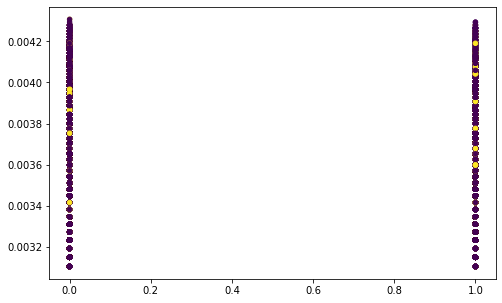

In [85]:
# Минимальное кол-во компонент = 15

pca = PCA(n_components=15, random_state = 123)
X_pca = pca.fit_transform(X)

# Визуализация данных в проекции на первые две главные компоненты.
plt.figure(figsize=[8, 5])
plt.scatter(X.iloc[:,0].values, X.iloc[:,1].values, c=y, s=20, cmap='viridis');

### KMeans

Кластеризация данных методом KMeans на модели со сниженной размерностью с помощью PCA:

In [86]:
kmeans = KMeans(n_clusters=2, n_init = 100, random_state=123)
kmeans.fit(X)

kmeans.labels_

array([0, 1, 0, ..., 1, 1, 1])

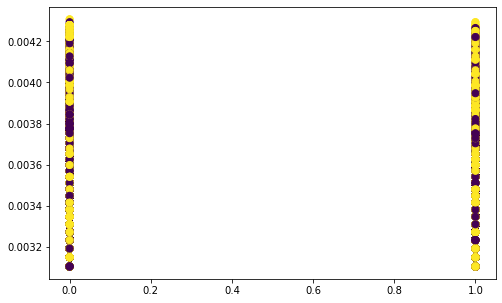

In [87]:
plt.figure(figsize=[8, 5])
plt.scatter(X.iloc[:,0].values, X.iloc[:,1].values, c=kmeans.labels_, s=50, cmap='viridis')

In [88]:
# Метрики качества кластеризации KMeans

print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y, kmeans.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(y, kmeans.labels_))
print("Adjusted mutual info score: %.3f"
      % metrics.adjusted_mutual_info_score(y, kmeans.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, kmeans.labels_, sample_size=1000))

Homogeneity: 0.008
Completeness: 0.005
V-measure: 0.006
Adjusted Rand-Index: -0.013
Adjusted mutual info score: 0.006
Silhouette Coefficient: 0.100


Качество кластеризации ***методом KMeans*** оказалось очень низким.


 ⏩ **Homogeneity:** (однородность / точность) - каждый кластер содержит только членов одного класса. От 0 до 1. Чем выше, тем лучше.

 ⏩ **Completeness:** (полнота) - все члены данного класса относятся к одному кластеру.

 ⏩ **V-measure:** (гармоническое среднее значение между точностью и полнотой) - достигает максимума при максимальной полноте и точности, и близка к нулю, если один из аргументов близок к нулю.

 ⏩ **Adjusted Rand-Index:** функция, которая измеряет сходство двух назначений, игнорируя перестановки, т.е. вносит поправку на случайность мест значений в выборке. Диапазон составляет [0, 1] для нескорректированного индекса 'rand_score' и [-1, 1] для скорректированного индекса 'adjusted_rand_score'.

  ⏩ **Adjusted mutual info score:** Мера согласованности. Диапазон составляет [0, 1].

   ⏩ **Silhouette Coefficient:** The best value is 1 and the worst value is -1. Values 
near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

### SpectralBiclustering

In [89]:
clustering = SpectralBiclustering(n_clusters=2, random_state=0).fit(X)

SpectralBiclustering(init='k-means++', method='bistochastic',
                     mini_batch=False, n_best=3, n_clusters=2, n_components=6,
                     n_init=10, n_svd_vecs=None, random_state=0,
                     svd_method='randomized')

SpectralBiclustering(n_clusters=2, random_state=0)

In [90]:
clustering.row_labels_

array([1, 0, 1, ..., 1, 1, 1])

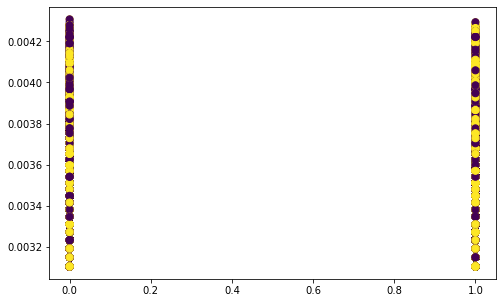

In [91]:
plt.figure(figsize=[8, 5])
plt.scatter(X.iloc[:,0].values, X.iloc[:,1].values, c=clustering.row_labels_, s=50, cmap='viridis')

In [92]:
# Метрики качества кластеризации SpectralBiclustering

print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, clustering.row_labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y, clustering.row_labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y, clustering.row_labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(y, clustering.row_labels_))
print("Adjusted mutual info score: %.3f"
      % metrics.adjusted_mutual_info_score(y, clustering.row_labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, clustering.row_labels_, sample_size=1000))

Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand-Index: -0.000
Adjusted mutual info score: 0.000
Silhouette Coefficient: 0.070


In [93]:
#  Кластеризация не дает хороших результатов при решении данной задачи.

# Подбор гиперпараметров (Grid search)

In [73]:
X = df.drop('default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)

## LogisticRegression

In [107]:
lr = LogisticRegression()

params_lr = [{
    'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1'],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear'],
    'multi_class': ['ovr'],
    'max_iter': np.arange(100, 500, 100)
}, {
    'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'multi_class': ['ovr'],
    'max_iter': np.arange(100, 500, 100)
# }, {
#     'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'penalty': ['elasticnet'],
#     'class_weight': [None, 'balanced'],
#     'solver': ['saga'],
#     'multi_class': ['ovr'],
#     'l1_ratio' : [0.25, 0.5, 0.75],
#     'max_iter': np.arange(100, 500, 100)
}]

cv = StratifiedKFold(n_splits=5, shuffle=True)
grid_lr = GridSearchCV(lr, params_lr,
                       scoring='roc_auc', cv=cv, verbose=2)

# производим обучение по сетке
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END C=1e-05, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s


[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class

[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, max_

[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END C=1, class_weight=None, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END C=1, class_weight=None, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   1.2s
[CV] END C=1, class_weight=None, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END C=1, class_weight=None, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END C=1, class_weight=None, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END C=1, class_weight=None, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END C=1, class_weight=None, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END C=1, class_weight=None, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; to

[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   7.1s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   4.9s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   5.8s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   9.7s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear; total time=   4.8s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   4.7s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   5.5s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, solver=liblinear; total time=   9.5s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l1, so

[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=  10.6s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.2s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.2s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.0s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.4s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.5s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.1s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l1, solver=liblinear; total time=   8.7s
[CV] END C=1000, class_weight=balanced, 

[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=1e-05, class_weight=b

[CV] END C=0.0001, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, class_weight=None, max_iter=200, multi_class=ovr,

[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, class_weight=balanced, ma

[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, class_weight=None, max_iter=300, multi_class=o

[CV] END C=0.001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.001, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, class_weight=balanced,

[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.01, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, s

[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END C=0.1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbf

[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=balanced, max_iter=

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=1, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=1, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.9s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, 

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END C=1, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=1, class_weight=balanced, max_iter=300, multi_class=ovr, pena

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.5s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-c

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.8s
[CV] END C=10, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.4s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; t

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=10, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; t

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END C=10, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.8s
[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.3s
[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.2s
[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.7s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.0s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.8s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.9s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.2s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END C=10, class_weight=balanced, max_iter=200, multi_cl

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.6s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.6s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.9s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.2s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.9s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.2s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.9s
[CV] END C=10, class_weight=balanced, max_iter=300, multi_cl

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   1.8s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.3s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.0s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.0s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.0s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_cl

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.4s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END C=10, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.6s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.7s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.3s
[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.7s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.6s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.8s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.6s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.0s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.4s
[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.1s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.2s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.4s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.9s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.6s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.9s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.8s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.9s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.0s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.6s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.6s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.8s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.8s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.1s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.3s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.5s
[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=100, class_weight=balanced, max_iter=100, mul

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.1s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.5s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.7s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.9s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.9s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.0s
[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END C=100, class_weight=balanced, max_iter=200,

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.1s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.6s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.9s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.1s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=100, class_weight=balanced, max_iter=300,

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.5s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.9s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.0s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   2.8s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.3s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=100, class_weight=balanced, max_iter=400,

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.8s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.9s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=100, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.6s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   7.6s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   6.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   7.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   6.9s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.4s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.1s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.0s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.1s
[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.9s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   6.6s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   9.4s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   6.6s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=  10.2s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   7.9s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.5s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.0s
[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.8s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.5s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   8.1s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   6.4s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   8.8s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   8.4s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.3s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.9s
[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.1s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   8.0s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   6.0s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   8.8s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   7.2s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.1s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.8s
[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.4s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.8s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.0s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.3s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.1s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.3s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.5s
[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.5s
[CV] END C=1000, class_weight=balanced, max_iter

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.6s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.5s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.1s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.8s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.8s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.5s
[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.4s
[CV] END C=1000, class_weight=balanced, max_

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.8s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.8s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.3s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.9s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.1s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.5s
[CV] END C=1000, class_weight=balanced, max_

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.1s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=300, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.9s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   3.2s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   5.4s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END C=1000, class_weight=balanced, max_

C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.6s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.7s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.6s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.4s


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END C=1000, class_weight=balanced, max_iter=400, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.6s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LogisticRegression(),
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                1000],
                          'class_weight': [None, 'balanced'],
                          'max_iter': array([100, 200, 300, 400]),
                          'multi_class': ['ovr'], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                1000],
                          'class_weight': [None, 'balanced'],
                          'max_iter': array([100, 200, 300, 400]),
                          'multi_class': ['ovr'], 'penalty': ['l2'],
                          'solver': ['liblinear', 'newton-cg', 'lbfgs']}],
             scoring='roc_auc', verbose=2)

In [109]:
print(grid_lr.best_score_)
print(grid_lr.best_params_)

0.7326670691374731
{'C': 1000, 'class_weight': 'balanced', 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}


In [74]:
best_params = {'C': 1000, 'class_weight': 'balanced', 
               'max_iter': 100, 'multi_class': 'ovr', 
               'penalty': 'l1', 'solver': 'liblinear'}

In [75]:
lr_model = LogisticRegression(**best_params)
%time lr_model.fit(X_train, y_train)

y_pred_gr = lr_model.predict(X_test)
y_score_gr = lr_model.predict_proba(X_test)[:,1]

Wall time: 22.6 s


In [76]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('accuracy:', accuracy_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7416222481986772
precision: 0.23085319265053666
accuracy: 0.6725609756097561
recall: 0.6771611526147279
f1: 0.3443223443223444
logloss: 11.309572290957872


<AxesSubplot:title={'center':'Confusion Matrix LogisticRegression'}>

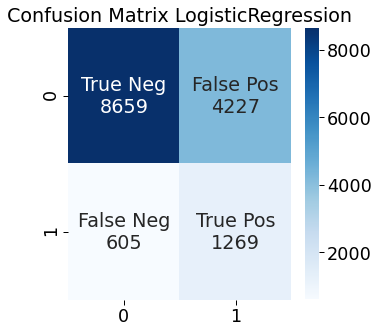

In [88]:
plt.figure(figsize=[5, 5])
plt.title('Confusion Matrix LogisticRegression')
    
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_gr).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
            zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_gr), annot=labels, fmt='', cmap='Blues')

## DecisionTreeClassifier

In [116]:
from sklearn.datasets import make_moons

In [117]:
tree = DecisionTreeClassifier(random_state=42)

params_tree = {'max_leaf_nodes': list(range(2, 100)), 
               'min_samples_split': [2, 3, 4]}

grid_tree = GridSearchCV(tree, params_tree, scoring='roc_auc', verbose=1, cv=5)
grid_tree.fit(X_train, y_train)

0it [03:34, ?it/s]

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             scoring='roc_auc', verbose=1)

In [118]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)

0.6943220792642709
{'max_leaf_nodes': 60, 'min_samples_split': 2}


In [119]:
grid_tree.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=60, random_state=42)

In [77]:
best_params = {'max_leaf_nodes': 60, 'min_samples_split': 2}

In [78]:
tree_model = DecisionTreeClassifier(**best_params, random_state=42)
%time tree_model.fit(X_train, y_train)

y_pred_gr = tree_model.predict(X_test)
y_score_gr = tree_model.predict_proba(X_test)[:,1]

Wall time: 427 ms


In [79]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('accuracy:', accuracy_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7078555922049212
precision: 0.21428571428571427
accuracy: 0.8719512195121951
recall: 0.0032017075773745998
f1: 0.006309148264984228
logloss: 4.422649388721183


<AxesSubplot:title={'center':'Confusion Matrix DecisionTreeClassifier'}>

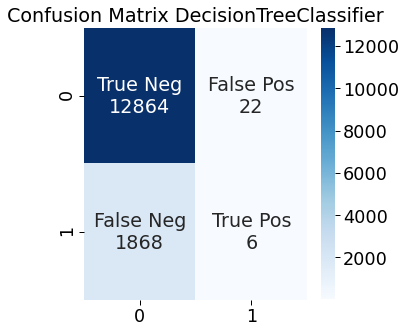

In [92]:
plt.figure(figsize=[5, 5])
plt.title('Confusion Matrix DecisionTreeClassifier')
    
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_gr).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
            zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_gr), annot=labels, fmt='', cmap='Blues')

In [124]:
from sklearn.tree import export_graphviz

export_graphviz( 
 grid_tree.best_estimator_,
 out_file=('tree.dot'),
 feature_names=None,
 class_names=None,
 filled=True,
)

In [133]:
# ! pip install pydot

In [139]:
conda install graphviz

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\pato2\anaconda3

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.3.29  |       haa95532_1         122 KB
    graphviz-2.38              |       hfd603c8_2        29.3 MB
    ------------------------------------------------------------
                                           Total:        29.4 MB

The following NEW packages will be INSTALLED:

  graphviz           pkgs/main/win-64::graphviz-2.38-hfd603c8_2

The following packages will be UPDATED:

  ca-certificates                      2022.3.29-haa95532_0 --> 2022.3.29-haa95532_1




graphviz-2.38        | 29.3 MB   |            |   0% 
graphviz-2.38        | 29.3 MB   |            |   0% 
graphviz-2.38        | 29.3 MB   |            |   1% 
graphviz-2.38        | 29.3 MB   | 1  

In [140]:
import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')


![jupyter](./tree.png)

## ExtraTreeClassifier

In [142]:
extra_tree = ExtraTreeClassifier(random_state=160)

params_extree = {'max_depth': np.arange(4, 8, 1),
                 'min_samples_leaf': [2, 3, 4, 5],
                 'max_features' : [None, 'sqrt', 'log2']                 
                }

grid_extree = GridSearchCV(extra_tree, params_extree, scoring='roc_auc',
                       cv=5, verbose=1)

grid_extree.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=ExtraTreeClassifier(random_state=160),
             param_grid={'max_depth': array([4, 5, 6, 7]),
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5]},
             scoring='roc_auc', verbose=1)

In [143]:
print(grid_extree.best_score_)
print(grid_extree.best_params_)

0.6937721517811559
{'max_depth': 7, 'max_features': None, 'min_samples_leaf': 5}


In [144]:
grid_extree.best_estimator_

ExtraTreeClassifier(max_depth=7, max_features=None, min_samples_leaf=5,
                    random_state=160)

In [80]:
best_params = {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 5}

In [81]:
extree_model = ExtraTreeClassifier(**best_params, random_state=160)
%time extree_model.fit(X_train, y_train)

y_pred_gr = extree_model.predict(X_test)
y_score_gr = extree_model.predict_proba(X_test)[:,1]

Wall time: 200 ms


In [82]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('accuracy:', accuracy_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7013110080666334
precision: 0.29545454545454547
accuracy: 0.8718157181571816
recall: 0.006937033084311633
f1: 0.013555787278415016
logloss: 4.427329927282612


<AxesSubplot:title={'center':'Confusion Matrix ExtraTreeClassifier'}>

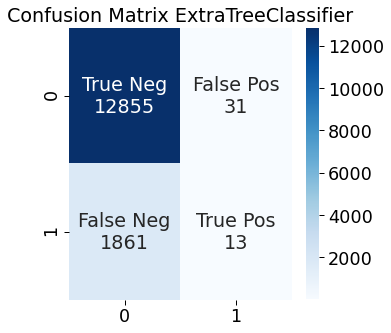

In [83]:
plt.figure(figsize=[5, 5])
plt.title('Confusion Matrix ExtraTreeClassifier')
    
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_gr).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
            zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_gr), annot=labels, fmt='', cmap='Blues')

## GradientBoostingClassifier

In [149]:
gboost = GradientBoostingClassifier()

params_gb = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

grid_gb = GridSearchCV(gboost, params_gb, scoring='roc_auc',
                       cv=5, verbose=1)

grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [5, 50, 250, 500]},
             scoring='roc_auc', verbose=1)

In [150]:
print(grid_gb.best_score_)
print(grid_gb.best_params_)

0.7325820960395062
{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500}


In [151]:
grid_gb.best_estimator_

GradientBoostingClassifier(max_depth=1, n_estimators=500)

In [84]:
best_params = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500}

In [85]:
gb_model = GradientBoostingClassifier(**best_params)
%time gb_model.fit(X_train, y_train)

y_pred_gr = gb_model.predict(X_test)
y_score_gr = gb_model.predict_proba(X_test)[:,1]

Wall time: 32.4 s


In [86]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('accuracy:', accuracy_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7420224616458491
precision: 0.4647887323943662
accuracy: 0.8726964769647696
recall: 0.017609391675560297
f1: 0.0339331619537275
logloss: 4.396909974982353


<AxesSubplot:title={'center':'Confusion Matrix GradientBoostingClassifier'}>

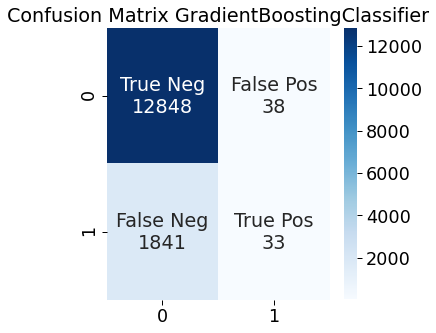

In [87]:
plt.figure(figsize=[5, 5])
plt.title('Confusion Matrix GradientBoostingClassifier')
    
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_gr).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
            zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_gr), annot=labels, fmt='', cmap='Blues')

## RandomForestClassifier

In [164]:
rforest = RandomForestClassifier()

params_rf = {'n_estimators': range (10, 51, 10),
             'max_depth': range (1,13, 2),
             'min_samples_leaf': range (1,8),
             'min_samples_split': range (2,10,2),
             'random_state': [0]}

grid_rf = GridSearchCV(rforest, params_rf, scoring='roc_auc',
                       cv=5, verbose=1)

grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10),
                         'random_state': [0]},
             scoring='roc_auc', verbose=1)

In [165]:
print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.7270287439404122
{'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 0}


In [166]:
grid_rf.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_leaf=6, n_estimators=50,
                       random_state=0)

In [88]:
best_params = {'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 0}

In [89]:
rf_model = RandomForestClassifier(**best_params)
%time rf_model.fit(X_train, y_train)

y_pred_gr = rf_model.predict(X_test)
y_score_gr = rf_model.predict_proba(X_test)[:,1]

Wall time: 3.47 s


In [90]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('accuracy:', accuracy_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7341593409806146
precision: 0.0
accuracy: 0.8730352303523036
recall: 0.0
f1: 0.0
logloss: 4.385207788893132


C:\Users\pato2\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



<AxesSubplot:title={'center':'Confusion Matrix RandomForestClassifier'}>

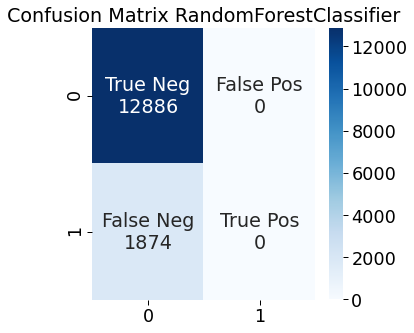

In [91]:
plt.figure(figsize=[5, 5])
plt.title('Confusion Matrix RandomForestClassifier')
    
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_gr).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
            zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_gr), annot=labels, fmt='', cmap='Blues')

# Предупреждение связано с несбалансированной выборкой по таргету
# Один из классов из y_test не встретился в y_pred - таким образом один из классов никогда не предсказывается

## CatBoostClassifier

In [172]:
catboo = CatBoostClassifier(silent=True)

params_cb = {'depth': [4, 6, 8, 9, 10],
        'iterations': [100, 150, 200, 350],
        'learning_rate' : [0.001,0.005,0.01,0.05,0.1,0.5],
        'l2_leaf_reg': np.arange(1, 10,2),
        'early_stopping_rounds' : np.arange(10, 50, 10) }

grid_cb = GridSearchCV(catboo, params_cb, scoring='roc_auc',
                       cv=5, verbose=1)

grid_cb.fit(X_train, y_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001733BE6D2B0>,
             param_grid={'depth': [4, 6, 8, 9, 10],
                         'early_stopping_rounds': array([10, 20, 30, 40]),
                         'iterations': [100, 150, 200, 350],
                         'l2_leaf_reg': array([1, 3, 5, 7, 9]),
                         'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]},
             scoring='roc_auc', verbose=1)

In [121]:
catboo = CatBoostClassifier(silent=True)

params_cb = {'depth': [4, 6, 8, 9, 10],
        'iterations': [100, 150, 200, 350],
        'learning_rate' : [0.001,0.005,0.01,0.05,0.1,0.5],
        'l2_leaf_reg': np.arange(1, 10,2),
        'early_stopping_rounds' : np.arange(10, 50, 10) }

grid_search_result = catboo.grid_search(params_cb,
                                        X_train, 
                                        y_train, 
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6833714197
bestIteration = 99

0:	loss: 0.6833714	best: 0.6833714 (0)	total: 1.04s	remaining: 41m 32s

bestTest = 0.6572348676
bestIteration = 99

1:	loss: 0.6572349	best: 0.6572349 (1)	total: 2s	remaining: 39m 54s

bestTest = 0.6398113236
bestIteration = 99

2:	loss: 0.6398113	best: 0.6398113 (2)	total: 3.01s	remaining: 40m 2s

bestTest = 0.6065148047
bestIteration = 99

3:	loss: 0.6065148	best: 0.6065148 (3)	total: 3.96s	remaining: 39m 31s

bestTest = 0.5994284552
bestIteration = 99

4:	loss: 0.5994285	best: 0.5994285 (4)	total: 5.04s	remaining: 40m 13s

bestTest = 0.5785747316
bestIteration = 99

5:	loss: 0.5785747	best: 0.5785747 (5)	total: 6.05s	remaining: 40m 14s

bestTest = 0.6833618158
bestIteration = 99

6:	loss: 0.6833618	best: 0.5785747 (5)	total: 6.98s	remaining: 39m 46s

bestTest = 0.657412399
bestIteration = 99

7:	loss: 0.6574124	best: 0.5785747 (5)	total: 7.94s	remaining: 39m 34s

bestTest = 0.6397337706
bestIteration = 99

8:	loss: 0.6397338	best: 0.57857


bestTest = 0.5906295227
bestIteration = 199

70:	loss: 0.5906295	best: 0.5580905 (65)	total: 1m 52s	remaining: 1h 1m 40s

bestTest = 0.5581154961
bestIteration = 199

71:	loss: 0.5581155	best: 0.5580905 (65)	total: 1m 54s	remaining: 1h 1m 53s

bestTest = 0.6752037511
bestIteration = 199

72:	loss: 0.6752038	best: 0.5580905 (65)	total: 1m 56s	remaining: 1h 2m 4s

bestTest = 0.6398013566
bestIteration = 199

73:	loss: 0.6398014	best: 0.5580905 (65)	total: 1m 59s	remaining: 1h 2m 24s

bestTest = 0.6231033245
bestIteration = 199

74:	loss: 0.6231033	best: 0.5580905 (65)	total: 2m 1s	remaining: 1h 2m 43s

bestTest = 0.5992496415
bestIteration = 199

75:	loss: 0.5992496	best: 0.5580905 (65)	total: 2m 3s	remaining: 1h 3m 2s

bestTest = 0.5913457412
bestIteration = 199

76:	loss: 0.5913457	best: 0.5580905 (65)	total: 2m 6s	remaining: 1h 3m 25s

bestTest = 0.5610733136
bestIteration = 199

77:	loss: 0.5610733	best: 0.5580905 (65)	total: 2m 8s	remaining: 1h 3m 42s

bestTest = 0.6752533362
bestI


bestTest = 0.5786476756
bestIteration = 99

137:	loss: 0.5786477	best: 0.5359846 (101)	total: 4m 54s	remaining: 1h 20m 19s

bestTest = 0.6834219077
bestIteration = 99

138:	loss: 0.6834219	best: 0.5359846 (101)	total: 4m 55s	remaining: 1h 20m

bestTest = 0.6571385071
bestIteration = 99

139:	loss: 0.6571385	best: 0.5359846 (101)	total: 4m 56s	remaining: 1h 19m 42s

bestTest = 0.6397206329
bestIteration = 99

140:	loss: 0.6397206	best: 0.5359846 (101)	total: 4m 57s	remaining: 1h 19m 28s

bestTest = 0.6065552002
bestIteration = 99

141:	loss: 0.6065552	best: 0.5359846 (101)	total: 4m 58s	remaining: 1h 19m 13s

bestTest = 0.5989783875
bestIteration = 99

142:	loss: 0.5989784	best: 0.5359846 (101)	total: 5m	remaining: 1h 18m 58s

bestTest = 0.5784110363
bestIteration = 99

143:	loss: 0.5784110	best: 0.5359846 (101)	total: 5m 1s	remaining: 1h 18m 41s

bestTest = 0.6834124627
bestIteration = 99

144:	loss: 0.6834125	best: 0.5359846 (101)	total: 5m 2s	remaining: 1h 18m 23s

bestTest = 0.6572


bestTest = 0.5603751423
bestIteration = 199

203:	loss: 0.5603751	best: 0.5359846 (101)	total: 6m 52s	remaining: 1h 13m 56s

bestTest = 0.6752610601
bestIteration = 199

204:	loss: 0.6752611	best: 0.5359846 (101)	total: 6m 54s	remaining: 1h 13m 56s

bestTest = 0.6398936798
bestIteration = 199

205:	loss: 0.6398937	best: 0.5359846 (101)	total: 6m 56s	remaining: 1h 13m 56s

bestTest = 0.6232032138
bestIteration = 199

206:	loss: 0.6232032	best: 0.5359846 (101)	total: 6m 58s	remaining: 1h 13m 55s

bestTest = 0.599351431
bestIteration = 199

207:	loss: 0.5993514	best: 0.5359846 (101)	total: 7m	remaining: 1h 13m 56s

bestTest = 0.5912480402
bestIteration = 199

208:	loss: 0.5912480	best: 0.5359846 (101)	total: 7m 3s	remaining: 1h 13m 56s

bestTest = 0.5618784389
bestIteration = 199

209:	loss: 0.5618784	best: 0.5359846 (101)	total: 7m 5s	remaining: 1h 13m 58s

bestTest = 0.6652392247
bestIteration = 349

210:	loss: 0.6652392	best: 0.5359846 (101)	total: 7m 9s	remaining: 1h 14m 15s

bestTes


bestTest = 0.6791183468
bestIteration = 149

270:	loss: 0.6791183	best: 0.5359846 (101)	total: 9m 41s	remaining: 1h 16m 9s

bestTest = 0.6472133845
bestIteration = 149

271:	loss: 0.6472134	best: 0.5359846 (101)	total: 9m 43s	remaining: 1h 16m 3s

bestTest = 0.6298932193
bestIteration = 149

272:	loss: 0.6298932	best: 0.5359846 (101)	total: 9m 44s	remaining: 1h 15m 57s

bestTest = 0.602133716
bestIteration = 149

273:	loss: 0.6021337	best: 0.5359846 (101)	total: 9m 46s	remaining: 1h 15m 51s

bestTest = 0.5948453685
bestIteration = 149

274:	loss: 0.5948454	best: 0.5359846 (101)	total: 9m 48s	remaining: 1h 15m 47s

bestTest = 0.5669518663
bestIteration = 149

275:	loss: 0.5669519	best: 0.5359846 (101)	total: 9m 50s	remaining: 1h 15m 42s

bestTest = 0.6791047073
bestIteration = 149

276:	loss: 0.6791047	best: 0.5359846 (101)	total: 9m 51s	remaining: 1h 15m 36s

bestTest = 0.647239496
bestIteration = 149

277:	loss: 0.6472395	best: 0.5359846 (101)	total: 9m 53s	remaining: 1h 15m 31s

bes


bestTest = 0.6652734233
bestIteration = 349

336:	loss: 0.6652734	best: 0.5359846 (101)	total: 12m 10s	remaining: 1h 14m 32s

bestTest = 0.6262700775
bestIteration = 349

337:	loss: 0.6262701	best: 0.5359846 (101)	total: 12m 14s	remaining: 1h 14m 42s

bestTest = 0.6120917134
bestIteration = 349

338:	loss: 0.6120917	best: 0.5359846 (101)	total: 12m 18s	remaining: 1h 14m 49s

bestTest = 0.5927539745
bestIteration = 349

339:	loss: 0.5927540	best: 0.5359846 (101)	total: 12m 22s	remaining: 1h 14m 58s

bestTest = 0.5819681921
bestIteration = 349

340:	loss: 0.5819682	best: 0.5359846 (101)	total: 12m 26s	remaining: 1h 15m 8s

bestTest = 0.5359846165
bestIteration = 349

341:	loss: 0.5359846	best: 0.5359846 (101)	total: 12m 30s	remaining: 1h 15m 18s

bestTest = 0.665294675
bestIteration = 349

342:	loss: 0.6652947	best: 0.5359846 (101)	total: 12m 34s	remaining: 1h 15m 25s

bestTest = 0.626312111
bestIteration = 349

343:	loss: 0.6263121	best: 0.5359846 (101)	total: 12m 38s	remaining: 1h 15m


bestTest = 0.6790963668
bestIteration = 149

402:	loss: 0.6790964	best: 0.5359846 (101)	total: 14m 40s	remaining: 1h 12m 43s

bestTest = 0.6471290614
bestIteration = 149

403:	loss: 0.6471291	best: 0.5359846 (101)	total: 14m 42s	remaining: 1h 12m 39s

bestTest = 0.6296502482
bestIteration = 149

404:	loss: 0.6296502	best: 0.5359846 (101)	total: 14m 43s	remaining: 1h 12m 34s

bestTest = 0.6020720648
bestIteration = 149

405:	loss: 0.6020721	best: 0.5359846 (101)	total: 14m 45s	remaining: 1h 12m 29s

bestTest = 0.5950023702
bestIteration = 149

406:	loss: 0.5950024	best: 0.5359846 (101)	total: 14m 47s	remaining: 1h 12m 25s

bestTest = 0.5694801611
bestIteration = 149

407:	loss: 0.5694802	best: 0.5359846 (101)	total: 14m 49s	remaining: 1h 12m 21s

bestTest = 0.679161669
bestIteration = 149

408:	loss: 0.6791617	best: 0.5359846 (101)	total: 14m 50s	remaining: 1h 12m 17s

bestTest = 0.6470988003
bestIteration = 149

409:	loss: 0.6470988	best: 0.5359846 (101)	total: 14m 52s	remaining: 1h 1


bestTest = 0.6652718003
bestIteration = 349

468:	loss: 0.6652718	best: 0.5359846 (101)	total: 17m 49s	remaining: 1h 13m 23s

bestTest = 0.626156491
bestIteration = 349

469:	loss: 0.6261565	best: 0.5359846 (101)	total: 17m 53s	remaining: 1h 13m 29s

bestTest = 0.6120487613
bestIteration = 349

470:	loss: 0.6120488	best: 0.5359846 (101)	total: 17m 57s	remaining: 1h 13m 34s

bestTest = 0.5924107419
bestIteration = 349

471:	loss: 0.5924107	best: 0.5359846 (101)	total: 18m 2s	remaining: 1h 13m 40s

bestTest = 0.5817384651
bestIteration = 349

472:	loss: 0.5817385	best: 0.5359846 (101)	total: 18m 7s	remaining: 1h 13m 48s

bestTest = 0.5405645094
bestIteration = 349

473:	loss: 0.5405645	best: 0.5359846 (101)	total: 18m 11s	remaining: 1h 13m 55s

bestTest = 0.6652742671
bestIteration = 349

474:	loss: 0.6652743	best: 0.5359846 (101)	total: 18m 15s	remaining: 1h 14m 1s

bestTest = 0.6262375891
bestIteration = 349

475:	loss: 0.6262376	best: 0.5359846 (101)	total: 18m 20s	remaining: 1h 14m 


bestTest = 0.6756996426
bestIteration = 149

534:	loss: 0.6756996	best: 0.5146870 (515)	total: 20m 49s	remaining: 1h 12m 37s

bestTest = 0.6385531153
bestIteration = 149

535:	loss: 0.6385531	best: 0.5146870 (515)	total: 20m 52s	remaining: 1h 12m 37s

bestTest = 0.6198084039
bestIteration = 149

536:	loss: 0.6198084	best: 0.5146870 (515)	total: 20m 55s	remaining: 1h 12m 37s

bestTest = 0.5910451324
bestIteration = 149

537:	loss: 0.5910451	best: 0.5146870 (515)	total: 20m 58s	remaining: 1h 12m 36s

bestTest = 0.5783813748
bestIteration = 149

538:	loss: 0.5783814	best: 0.5146870 (515)	total: 21m 1s	remaining: 1h 12m 35s

bestTest = 0.5215179357
bestIteration = 149

539:	loss: 0.5215179	best: 0.5146870 (515)	total: 21m 4s	remaining: 1h 12m 35s

bestTest = 0.6708685766
bestIteration = 199

540:	loss: 0.6708686	best: 0.5146870 (515)	total: 21m 8s	remaining: 1h 12m 38s

bestTest = 0.6304015649
bestIteration = 199

541:	loss: 0.6304016	best: 0.5146870 (515)	total: 21m 12s	remaining: 1h 12m


bestTest = 0.6809138343
bestIteration = 99

600:	loss: 0.6809138	best: 0.4466128 (575)	total: 26m 31s	remaining: 1h 19m 24s

bestTest = 0.6495764196
bestIteration = 99

601:	loss: 0.6495764	best: 0.4466128 (575)	total: 26m 33s	remaining: 1h 19m 19s

bestTest = 0.6304263599
bestIteration = 99

602:	loss: 0.6304264	best: 0.4466128 (575)	total: 26m 35s	remaining: 1h 19m 15s

bestTest = 0.5962486063
bestIteration = 99

603:	loss: 0.5962486	best: 0.4466128 (575)	total: 26m 37s	remaining: 1h 19m 10s

bestTest = 0.5856768448
bestIteration = 99

604:	loss: 0.5856768	best: 0.4466128 (575)	total: 26m 39s	remaining: 1h 19m 6s

bestTest = 0.5390583588
bestIteration = 99

605:	loss: 0.5390584	best: 0.4466128 (575)	total: 26m 41s	remaining: 1h 19m 1s

bestTest = 0.680932688
bestIteration = 99

606:	loss: 0.6809327	best: 0.4466128 (575)	total: 26m 43s	remaining: 1h 18m 57s

bestTest = 0.6496852431
bestIteration = 99

607:	loss: 0.6496852	best: 0.4466128 (575)	total: 26m 45s	remaining: 1h 18m 52s

be


bestTest = 0.670896897
bestIteration = 199

666:	loss: 0.6708969	best: 0.4466128 (575)	total: 29m 27s	remaining: 1h 16m 31s

bestTest = 0.6305938006
bestIteration = 199

667:	loss: 0.6305938	best: 0.4466128 (575)	total: 29m 31s	remaining: 1h 16m 32s

bestTest = 0.6131826703
bestIteration = 199

668:	loss: 0.6131827	best: 0.4466128 (575)	total: 29m 35s	remaining: 1h 16m 32s

bestTest = 0.585231878
bestIteration = 199

669:	loss: 0.5852319	best: 0.4466128 (575)	total: 29m 39s	remaining: 1h 16m 34s

bestTest = 0.5678076786
bestIteration = 199

670:	loss: 0.5678077	best: 0.4466128 (575)	total: 29m 43s	remaining: 1h 16m 36s

bestTest = 0.4992599815
bestIteration = 199

671:	loss: 0.4992600	best: 0.4466128 (575)	total: 29m 47s	remaining: 1h 16m 37s

bestTest = 0.6708942658
bestIteration = 199

672:	loss: 0.6708943	best: 0.4466128 (575)	total: 29m 51s	remaining: 1h 16m 37s

bestTest = 0.6304065954
bestIteration = 199

673:	loss: 0.6304066	best: 0.4466128 (575)	total: 29m 55s	remaining: 1h 16


bestTest = 0.6809568147
bestIteration = 99

732:	loss: 0.6809568	best: 0.4466128 (575)	total: 35m 2s	remaining: 1h 19m 41s

bestTest = 0.6496546324
bestIteration = 99

733:	loss: 0.6496546	best: 0.4466128 (575)	total: 35m 4s	remaining: 1h 19m 36s

bestTest = 0.6304604236
bestIteration = 99

734:	loss: 0.6304604	best: 0.4466128 (575)	total: 35m 6s	remaining: 1h 19m 31s

bestTest = 0.597154534
bestIteration = 99

735:	loss: 0.5971545	best: 0.4466128 (575)	total: 35m 8s	remaining: 1h 19m 26s

bestTest = 0.5863383167
bestIteration = 99

736:	loss: 0.5863383	best: 0.4466128 (575)	total: 35m 10s	remaining: 1h 19m 22s

bestTest = 0.5421492184
bestIteration = 99

737:	loss: 0.5421492	best: 0.4466128 (575)	total: 35m 12s	remaining: 1h 19m 17s

bestTest = 0.6809625551
bestIteration = 99

738:	loss: 0.6809626	best: 0.4466128 (575)	total: 35m 14s	remaining: 1h 19m 12s

bestTest = 0.6499422757
bestIteration = 99

739:	loss: 0.6499423	best: 0.4466128 (575)	total: 35m 16s	remaining: 1h 19m 8s

bestT


bestTest = 0.6709515296
bestIteration = 199

798:	loss: 0.6709515	best: 0.4466128 (575)	total: 38m 18s	remaining: 1h 16m 46s

bestTest = 0.6307082776
bestIteration = 199

799:	loss: 0.6307083	best: 0.4466128 (575)	total: 38m 22s	remaining: 1h 16m 45s

bestTest = 0.6132721238
bestIteration = 199

800:	loss: 0.6132721	best: 0.4466128 (575)	total: 38m 26s	remaining: 1h 16m 44s

bestTest = 0.5857229991
bestIteration = 199

801:	loss: 0.5857230	best: 0.4466128 (575)	total: 38m 30s	remaining: 1h 16m 43s

bestTest = 0.5694591207
bestIteration = 199

802:	loss: 0.5694591	best: 0.4466128 (575)	total: 38m 34s	remaining: 1h 16m 42s

bestTest = 0.5024868587
bestIteration = 199

803:	loss: 0.5024869	best: 0.4466128 (575)	total: 38m 38s	remaining: 1h 16m 42s

bestTest = 0.6709464606
bestIteration = 199

804:	loss: 0.6709465	best: 0.4466128 (575)	total: 38m 42s	remaining: 1h 16m 41s

bestTest = 0.6307718563
bestIteration = 199

805:	loss: 0.6307719	best: 0.4466128 (575)	total: 38m 45s	remaining: 1h 


bestTest = 0.6809783445
bestIteration = 99

864:	loss: 0.6809783	best: 0.4466128 (575)	total: 43m 24s	remaining: 1h 17m 2s

bestTest = 0.6498750031
bestIteration = 99

865:	loss: 0.6498750	best: 0.4466128 (575)	total: 43m 26s	remaining: 1h 16m 57s

bestTest = 0.6304642191
bestIteration = 99

866:	loss: 0.6304642	best: 0.4466128 (575)	total: 43m 28s	remaining: 1h 16m 52s

bestTest = 0.5971978985
bestIteration = 99

867:	loss: 0.5971979	best: 0.4466128 (575)	total: 43m 30s	remaining: 1h 16m 47s

bestTest = 0.5866592151
bestIteration = 99

868:	loss: 0.5866592	best: 0.4466128 (575)	total: 43m 32s	remaining: 1h 16m 42s

bestTest = 0.5433469794
bestIteration = 99

869:	loss: 0.5433470	best: 0.4466128 (575)	total: 43m 34s	remaining: 1h 16m 37s

bestTest = 0.675672042
bestIteration = 149

870:	loss: 0.6756720	best: 0.4466128 (575)	total: 43m 37s	remaining: 1h 16m 35s

bestTest = 0.638394046
bestIteration = 149

871:	loss: 0.6383940	best: 0.4466128 (575)	total: 43m 40s	remaining: 1h 16m 32s




bestTest = 0.6589406849
bestIteration = 349

930:	loss: 0.6589407	best: 0.4466128 (575)	total: 47m 5s	remaining: 1h 14m 18s

bestTest = 0.6161053296
bestIteration = 349

931:	loss: 0.6161053	best: 0.4466128 (575)	total: 47m 12s	remaining: 1h 14m 21s

bestTest = 0.6023212136
bestIteration = 349

932:	loss: 0.6023212	best: 0.4466128 (575)	total: 47m 19s	remaining: 1h 14m 24s

bestTest = 0.5697415153
bestIteration = 349

933:	loss: 0.5697415	best: 0.4466128 (575)	total: 47m 26s	remaining: 1h 14m 27s

bestTest = 0.5443052489
bestIteration = 349

934:	loss: 0.5443052	best: 0.4466128 (575)	total: 47m 32s	remaining: 1h 14m 29s

bestTest = 0.4466128193
bestIteration = 349

935:	loss: 0.4466128	best: 0.4466128 (575)	total: 47m 39s	remaining: 1h 14m 32s

bestTest = 0.6590104076
bestIteration = 349

936:	loss: 0.6590104	best: 0.4466128 (575)	total: 47m 46s	remaining: 1h 14m 35s

bestTest = 0.6162680342
bestIteration = 349

937:	loss: 0.6162680	best: 0.4466128 (575)	total: 47m 53s	remaining: 1h 1


bestTest = 0.6730463735
bestIteration = 149

996:	loss: 0.6730464	best: 0.4016795 (995)	total: 52m 14s	remaining: 1h 13m 30s

bestTest = 0.6301541082
bestIteration = 149

997:	loss: 0.6301541	best: 0.4016795 (995)	total: 52m 18s	remaining: 1h 13m 28s

bestTest = 0.6086109364
bestIteration = 149

998:	loss: 0.6086109	best: 0.4016795 (995)	total: 52m 22s	remaining: 1h 13m 26s

bestTest = 0.5649837538
bestIteration = 149

999:	loss: 0.5649838	best: 0.4016795 (995)	total: 52m 26s	remaining: 1h 13m 24s

bestTest = 0.5346831463
bestIteration = 149

1000:	loss: 0.5346831	best: 0.4016795 (995)	total: 52m 30s	remaining: 1h 13m 23s

bestTest = 0.4179598639
bestIteration = 149

1001:	loss: 0.4179599	best: 0.4016795 (995)	total: 52m 34s	remaining: 1h 13m 21s

bestTest = 0.6731172051
bestIteration = 149

1002:	loss: 0.6731172	best: 0.4016795 (995)	total: 52m 38s	remaining: 1h 13m 19s

bestTest = 0.6303932162
bestIteration = 149

1003:	loss: 0.6303932	best: 0.4016795 (995)	total: 52m 42s	remaining:


bestTest = 0.2989207497
bestIteration = 349

1061:	loss: 0.2989207	best: 0.2845971 (1055)	total: 58m 17s	remaining: 1h 13m 25s

bestTest = 0.6539698041
bestIteration = 349

1062:	loss: 0.6539698	best: 0.2845971 (1055)	total: 58m 26s	remaining: 1h 13m 30s

bestTest = 0.6051434284
bestIteration = 349

1063:	loss: 0.6051434	best: 0.2845971 (1055)	total: 58m 36s	remaining: 1h 13m 35s

bestTest = 0.5870910975
bestIteration = 349

1064:	loss: 0.5870911	best: 0.2845971 (1055)	total: 58m 46s	remaining: 1h 13m 40s

bestTest = 0.5282718037
bestIteration = 349

1065:	loss: 0.5282718	best: 0.2845971 (1055)	total: 58m 55s	remaining: 1h 13m 44s

bestTest = 0.4800938326
bestIteration = 349

1066:	loss: 0.4800938	best: 0.2845971 (1055)	total: 59m 3s	remaining: 1h 13m 47s

bestTest = 0.3029779908
bestIteration = 349

1067:	loss: 0.3029780	best: 0.2845971 (1055)	total: 59m 13s	remaining: 1h 13m 51s

bestTest = 0.6540477906
bestIteration = 349

1068:	loss: 0.6540478	best: 0.2845971 (1055)	total: 59m 22s


bestTest = 0.5654401175
bestIteration = 149

1125:	loss: 0.5654401	best: 0.2845971 (1055)	total: 1h 3m 25s	remaining: 1h 11m 45s

bestTest = 0.5369250584
bestIteration = 149

1126:	loss: 0.5369251	best: 0.2845971 (1055)	total: 1h 3m 29s	remaining: 1h 11m 43s

bestTest = 0.4248077273
bestIteration = 149

1127:	loss: 0.4248077	best: 0.2845971 (1055)	total: 1h 3m 33s	remaining: 1h 11m 40s

bestTest = 0.673149285
bestIteration = 149

1128:	loss: 0.6731493	best: 0.2845971 (1055)	total: 1h 3m 37s	remaining: 1h 11m 37s

bestTest = 0.6305867918
bestIteration = 149

1129:	loss: 0.6305868	best: 0.2845971 (1055)	total: 1h 3m 41s	remaining: 1h 11m 35s

bestTest = 0.6092522346
bestIteration = 149

1130:	loss: 0.6092522	best: 0.2845971 (1055)	total: 1h 3m 45s	remaining: 1h 11m 32s

bestTest = 0.5675179384
bestIteration = 149

1131:	loss: 0.5675179	best: 0.2845971 (1055)	total: 1h 3m 49s	remaining: 1h 11m 29s

bestTest = 0.541309062
bestIteration = 149

1132:	loss: 0.5413091	best: 0.2845971 (1055)	t


bestTest = 0.6053491965
bestIteration = 349

1189:	loss: 0.6053492	best: 0.2845971 (1055)	total: 1h 10m 1s	remaining: 1h 11m 11s

bestTest = 0.5876947348
bestIteration = 349

1190:	loss: 0.5876947	best: 0.2845971 (1055)	total: 1h 10m 10s	remaining: 1h 11m 14s

bestTest = 0.5322508555
bestIteration = 349

1191:	loss: 0.5322509	best: 0.2845971 (1055)	total: 1h 10m 19s	remaining: 1h 11m 16s

bestTest = 0.4854828089
bestIteration = 349

1192:	loss: 0.4854828	best: 0.2845971 (1055)	total: 1h 10m 28s	remaining: 1h 11m 17s

bestTest = 0.3134077189
bestIteration = 349

1193:	loss: 0.3134077	best: 0.2845971 (1055)	total: 1h 10m 37s	remaining: 1h 11m 19s

bestTest = 0.6541371603
bestIteration = 349

1194:	loss: 0.6541372	best: 0.2845971 (1055)	total: 1h 10m 46s	remaining: 1h 11m 21s

bestTest = 0.6057976182
bestIteration = 349

1195:	loss: 0.6057976	best: 0.2845971 (1055)	total: 1h 10m 55s	remaining: 1h 11m 23s

bestTest = 0.5882604885
bestIteration = 349

1196:	loss: 0.5882605	best: 0.2845971 


bestTest = 0.4258645151
bestIteration = 149

1253:	loss: 0.4258645	best: 0.2845971 (1055)	total: 1h 14m 30s	remaining: 1h 8m 5s

bestTest = 0.6732070257
bestIteration = 149

1254:	loss: 0.6732070	best: 0.2845971 (1055)	total: 1h 14m 34s	remaining: 1h 8m 1s

bestTest = 0.6307144451
bestIteration = 149

1255:	loss: 0.6307144	best: 0.2845971 (1055)	total: 1h 14m 38s	remaining: 1h 7m 59s

bestTest = 0.6096777772
bestIteration = 149

1256:	loss: 0.6096778	best: 0.2845971 (1055)	total: 1h 14m 42s	remaining: 1h 7m 55s

bestTest = 0.5689657723
bestIteration = 149

1257:	loss: 0.5689658	best: 0.2845971 (1055)	total: 1h 14m 46s	remaining: 1h 7m 52s

bestTest = 0.544952789
bestIteration = 149

1258:	loss: 0.5449528	best: 0.2845971 (1055)	total: 1h 14m 50s	remaining: 1h 7m 49s

bestTest = 0.4256558432
bestIteration = 149

1259:	loss: 0.4256558	best: 0.2845971 (1055)	total: 1h 14m 54s	remaining: 1h 7m 46s

bestTest = 0.6673498489
bestIteration = 199

1260:	loss: 0.6673498	best: 0.2845971 (1055)	to


bestTest = 0.536618501
bestIteration = 349

1317:	loss: 0.5366185	best: 0.2845971 (1055)	total: 1h 21m 54s	remaining: 1h 7m 14s

bestTest = 0.4910677522
bestIteration = 349

1318:	loss: 0.4910678	best: 0.2845971 (1055)	total: 1h 22m 3s	remaining: 1h 7m 14s

bestTest = 0.3160053249
bestIteration = 349

1319:	loss: 0.3160053	best: 0.2845971 (1055)	total: 1h 22m 12s	remaining: 1h 7m 15s

bestTest = 0.6789767738
bestIteration = 99

1320:	loss: 0.6789768	best: 0.2845971 (1055)	total: 1h 22m 15s	remaining: 1h 7m 11s

bestTest = 0.6427393121
bestIteration = 99

1321:	loss: 0.6427393	best: 0.2845971 (1055)	total: 1h 22m 17s	remaining: 1h 7m 6s

bestTest = 0.6203782066
bestIteration = 99

1322:	loss: 0.6203782	best: 0.2845971 (1055)	total: 1h 22m 20s	remaining: 1h 7m 1s

bestTest = 0.5751045884
bestIteration = 99

1323:	loss: 0.5751046	best: 0.2845971 (1055)	total: 1h 22m 22s	remaining: 1h 6m 57s

bestTest = 0.5476339924
bestIteration = 99

1324:	loss: 0.5476340	best: 0.2845971 (1055)	total: 1


bestTest = 0.6204880095
bestIteration = 199

1381:	loss: 0.6204880	best: 0.2845971 (1055)	total: 1h 25m 42s	remaining: 1h 3m 8s

bestTest = 0.5998531623
bestIteration = 199

1382:	loss: 0.5998532	best: 0.2845971 (1055)	total: 1h 25m 47s	remaining: 1h 3m 5s

bestTest = 0.5489635719
bestIteration = 199

1383:	loss: 0.5489636	best: 0.2845971 (1055)	total: 1h 25m 53s	remaining: 1h 3m 3s

bestTest = 0.5087624026
bestIteration = 199

1384:	loss: 0.5087624	best: 0.2845971 (1055)	total: 1h 25m 58s	remaining: 1h 3m

bestTest = 0.3660355763
bestIteration = 199

1385:	loss: 0.3660356	best: 0.2845971 (1055)	total: 1h 26m 3s	remaining: 1h 2m 57s

bestTest = 0.6675407741
bestIteration = 199

1386:	loss: 0.6675408	best: 0.2845971 (1055)	total: 1h 26m 8s	remaining: 1h 2m 55s

bestTest = 0.6210449746
bestIteration = 199

1387:	loss: 0.6210450	best: 0.2845971 (1055)	total: 1h 26m 14s	remaining: 1h 2m 52s

bestTest = 0.6008217025
bestIteration = 199

1388:	loss: 0.6008217	best: 0.2845971 (1055)	total: 1


bestTest = 0.3854771604
bestIteration = 99

1445:	loss: 0.3854772	best: 0.2845971 (1055)	total: 1h 32m 59s	remaining: 1h 1m 21s

bestTest = 0.6780280571
bestIteration = 99

1446:	loss: 0.6780281	best: 0.2845971 (1055)	total: 1h 33m 2s	remaining: 1h 1m 16s

bestTest = 0.6390370373
bestIteration = 99

1447:	loss: 0.6390370	best: 0.2845971 (1055)	total: 1h 33m 6s	remaining: 1h 1m 12s

bestTest = 0.6143303258
bestIteration = 99

1448:	loss: 0.6143303	best: 0.2845971 (1055)	total: 1h 33m 9s	remaining: 1h 1m 8s

bestTest = 0.5590523351
bestIteration = 99

1449:	loss: 0.5590523	best: 0.2845971 (1055)	total: 1h 33m 12s	remaining: 1h 1m 4s

bestTest = 0.5255792276
bestIteration = 99

1450:	loss: 0.5255792	best: 0.2845971 (1055)	total: 1h 33m 15s	remaining: 1h 59s

bestTest = 0.4048250604
bestIteration = 99

1451:	loss: 0.4048251	best: 0.2845971 (1055)	total: 1h 33m 18s	remaining: 1h 55s

bestTest = 0.6781376466
bestIteration = 99

1452:	loss: 0.6781376	best: 0.2845971 (1055)	total: 1h 33m 22s	


bestTest = 0.4756510875
bestIteration = 199

1510:	loss: 0.4756511	best: 0.2840470 (1505)	total: 1h 37m 51s	remaining: 57m 34s

bestTest = 0.3043591649
bestIteration = 199

1511:	loss: 0.3043592	best: 0.2840470 (1505)	total: 1h 37m 57s	remaining: 57m 31s

bestTest = 0.6657664462
bestIteration = 199

1512:	loss: 0.6657664	best: 0.2840470 (1505)	total: 1h 38m 3s	remaining: 57m 29s

bestTest = 0.6153092845
bestIteration = 199

1513:	loss: 0.6153093	best: 0.2840470 (1505)	total: 1h 38m 12s	remaining: 57m 28s

bestTest = 0.5918896939
bestIteration = 199

1514:	loss: 0.5918897	best: 0.2840470 (1505)	total: 1h 38m 18s	remaining: 57m 25s

bestTest = 0.5282362964
bestIteration = 199

1515:	loss: 0.5282363	best: 0.2840470 (1505)	total: 1h 38m 24s	remaining: 57m 23s

bestTest = 0.4821160653
bestIteration = 199

1516:	loss: 0.4821161	best: 0.2840470 (1505)	total: 1h 38m 31s	remaining: 57m 20s

bestTest = 0.3119226183
bestIteration = 199

1517:	loss: 0.3119226	best: 0.2840470 (1505)	total: 1h 38m 


bestTest = 0.5609126245
bestIteration = 99

1575:	loss: 0.5609126	best: 0.2052009 (1535)	total: 1h 46m 23s	remaining: 55m 37s

bestTest = 0.5286186083
bestIteration = 99

1576:	loss: 0.5286186	best: 0.2052009 (1535)	total: 1h 46m 27s	remaining: 55m 33s

bestTest = 0.4073697995
bestIteration = 99

1577:	loss: 0.4073698	best: 0.2052009 (1535)	total: 1h 46m 31s	remaining: 55m 29s

bestTest = 0.6782240163
bestIteration = 99

1578:	loss: 0.6782240	best: 0.2052009 (1535)	total: 1h 46m 36s	remaining: 55m 25s

bestTest = 0.6397687605
bestIteration = 99

1579:	loss: 0.6397688	best: 0.2052009 (1535)	total: 1h 46m 39s	remaining: 55m 21s

bestTest = 0.61543982
bestIteration = 99

1580:	loss: 0.6154398	best: 0.2052009 (1535)	total: 1h 46m 43s	remaining: 55m 17s

bestTest = 0.5620154357
bestIteration = 99

1581:	loss: 0.5620154	best: 0.2052009 (1535)	total: 1h 46m 46s	remaining: 55m 12s

bestTest = 0.5338554255
bestIteration = 99

1582:	loss: 0.5338554	best: 0.2052009 (1535)	total: 1h 46m 49s	remai


bestTest = 0.59268862
bestIteration = 199

1640:	loss: 0.5926886	best: 0.2052009 (1535)	total: 1h 51m 49s	remaining: 51m 43s

bestTest = 0.5322186092
bestIteration = 199

1641:	loss: 0.5322186	best: 0.2052009 (1535)	total: 1h 51m 55s	remaining: 51m 39s

bestTest = 0.4894544798
bestIteration = 199

1642:	loss: 0.4894545	best: 0.2052009 (1535)	total: 1h 52m 1s	remaining: 51m 36s

bestTest = 0.3155530648
bestIteration = 199

1643:	loss: 0.3155531	best: 0.2052009 (1535)	total: 1h 52m 7s	remaining: 51m 33s

bestTest = 0.6660609415
bestIteration = 199

1644:	loss: 0.6660609	best: 0.2052009 (1535)	total: 1h 52m 13s	remaining: 51m 30s

bestTest = 0.6162057871
bestIteration = 199

1645:	loss: 0.6162058	best: 0.2052009 (1535)	total: 1h 52m 21s	remaining: 51m 28s

bestTest = 0.5930844328
bestIteration = 199

1646:	loss: 0.5930844	best: 0.2052009 (1535)	total: 1h 52m 28s	remaining: 51m 25s

bestTest = 0.5355703638
bestIteration = 199

1647:	loss: 0.5355704	best: 0.2052009 (1535)	total: 1h 52m 34s


bestTest = 0.6400238188
bestIteration = 99

1705:	loss: 0.6400238	best: 0.2052009 (1535)	total: 1h 59m 29s	remaining: 48m 36s

bestTest = 0.6158657583
bestIteration = 99

1706:	loss: 0.6158658	best: 0.2052009 (1535)	total: 1h 59m 32s	remaining: 48m 32s

bestTest = 0.5650901603
bestIteration = 99

1707:	loss: 0.5650902	best: 0.2052009 (1535)	total: 1h 59m 36s	remaining: 48m 27s

bestTest = 0.5346755782
bestIteration = 99

1708:	loss: 0.5346756	best: 0.2052009 (1535)	total: 1h 59m 39s	remaining: 48m 22s

bestTest = 0.4177192845
bestIteration = 99

1709:	loss: 0.4177193	best: 0.2052009 (1535)	total: 1h 59m 42s	remaining: 48m 18s

bestTest = 0.6711791838
bestIteration = 149

1710:	loss: 0.6711792	best: 0.2052009 (1535)	total: 1h 59m 47s	remaining: 48m 14s

bestTest = 0.623858427
bestIteration = 149

1711:	loss: 0.6238584	best: 0.2052009 (1535)	total: 1h 59m 51s	remaining: 48m 10s

bestTest = 0.5983501106
bestIteration = 149

1712:	loss: 0.5983501	best: 0.2052009 (1535)	total: 1h 59m 56s	r


bestTest = 0.5931255259
bestIteration = 349

1771:	loss: 0.5931255	best: 0.2052009 (1535)	total: 2h 5m 49s	remaining: 44m 35s

bestTest = 0.5673354081
bestIteration = 349

1772:	loss: 0.5673354	best: 0.2052009 (1535)	total: 2h 6m	remaining: 44m 33s

bestTest = 0.470333367
bestIteration = 349

1773:	loss: 0.4703334	best: 0.2052009 (1535)	total: 2h 6m 11s	remaining: 44m 31s

bestTest = 0.3918790667
bestIteration = 349

1774:	loss: 0.3918791	best: 0.2052009 (1535)	total: 2h 6m 22s	remaining: 44m 29s

bestTest = 0.2052008525
bestIteration = 349

1775:	loss: 0.2052009	best: 0.2052009 (1535)	total: 2h 6m 37s	remaining: 44m 29s

bestTest = 0.65083123
bestIteration = 349

1776:	loss: 0.6508312	best: 0.2052009 (1535)	total: 2h 6m 49s	remaining: 44m 27s

bestTest = 0.5953276224
bestIteration = 349

1777:	loss: 0.5953276	best: 0.2052009 (1535)	total: 2h 7m 1s	remaining: 44m 26s

bestTest = 0.5718419587
bestIteration = 349

1778:	loss: 0.5718420	best: 0.2052009 (1535)	total: 2h 7m 12s	remaining: 


bestTest = 0.6715055001
bestIteration = 149

1836:	loss: 0.6715055	best: 0.2052009 (1535)	total: 2h 13m 4s	remaining: 40m 47s

bestTest = 0.6248360385
bestIteration = 149

1837:	loss: 0.6248360	best: 0.2052009 (1535)	total: 2h 13m 9s	remaining: 40m 42s

bestTest = 0.6000977967
bestIteration = 149

1838:	loss: 0.6000978	best: 0.2052009 (1535)	total: 2h 13m 14s	remaining: 40m 38s

bestTest = 0.5405799743
bestIteration = 149

1839:	loss: 0.5405800	best: 0.2052009 (1535)	total: 2h 13m 19s	remaining: 40m 34s

bestTest = 0.4984894939
bestIteration = 149

1840:	loss: 0.4984895	best: 0.2052009 (1535)	total: 2h 13m 23s	remaining: 40m 30s

bestTest = 0.3482155084
bestIteration = 149

1841:	loss: 0.3482155	best: 0.2052009 (1535)	total: 2h 13m 28s	remaining: 40m 25s

bestTest = 0.6716635924
bestIteration = 149

1842:	loss: 0.6716636	best: 0.2052009 (1535)	total: 2h 13m 32s	remaining: 40m 21s

bestTest = 0.6253521444
bestIteration = 149

1843:	loss: 0.6253521	best: 0.2052009 (1535)	total: 2h 13m 3


bestTest = 0.219911042
bestIteration = 349

1901:	loss: 0.2199110	best: 0.2052009 (1535)	total: 2h 20m 22s	remaining: 36m 45s

bestTest = 0.6511188297
bestIteration = 349

1902:	loss: 0.6511188	best: 0.2052009 (1535)	total: 2h 20m 33s	remaining: 36m 42s

bestTest = 0.5964217148
bestIteration = 349

1903:	loss: 0.5964217	best: 0.2052009 (1535)	total: 2h 20m 45s	remaining: 36m 40s

bestTest = 0.5728573178
bestIteration = 349

1904:	loss: 0.5728573	best: 0.2052009 (1535)	total: 2h 20m 56s	remaining: 36m 37s

bestTest = 0.4915818506
bestIteration = 349

1905:	loss: 0.4915819	best: 0.2052009 (1535)	total: 2h 21m 7s	remaining: 36m 34s

bestTest = 0.4259139381
bestIteration = 349

1906:	loss: 0.4259139	best: 0.2052009 (1535)	total: 2h 21m 19s	remaining: 36m 32s

bestTest = 0.2328533887
bestIteration = 348

1907:	loss: 0.2328534	best: 0.2052009 (1535)	total: 2h 21m 30s	remaining: 36m 29s

bestTest = 0.6513315081
bestIteration = 349

1908:	loss: 0.6513315	best: 0.2052009 (1535)	total: 2h 21m 4


bestTest = 0.4607658762
bestIteration = 149

1966:	loss: 0.4607659	best: 0.2052009 (1535)	total: 2h 28m 4s	remaining: 32m 35s

bestTest = 0.268884334
bestIteration = 149

1967:	loss: 0.2688843	best: 0.2052009 (1535)	total: 2h 28m 10s	remaining: 32m 31s

bestTest = 0.6699496534
bestIteration = 149

1968:	loss: 0.6699497	best: 0.2052009 (1535)	total: 2h 28m 17s	remaining: 32m 27s

bestTest = 0.6193130136
bestIteration = 149

1969:	loss: 0.6193130	best: 0.2052009 (1535)	total: 2h 28m 25s	remaining: 32m 23s

bestTest = 0.5917079984
bestIteration = 149

1970:	loss: 0.5917080	best: 0.2052009 (1535)	total: 2h 28m 32s	remaining: 32m 19s

bestTest = 0.5157243111
bestIteration = 149

1971:	loss: 0.5157243	best: 0.2052009 (1535)	total: 2h 28m 41s	remaining: 32m 16s

bestTest = 0.4657380554
bestIteration = 149

1972:	loss: 0.4657381	best: 0.2052009 (1535)	total: 2h 28m 47s	remaining: 32m 12s

bestTest = 0.2805554089
bestIteration = 149

1973:	loss: 0.2805554	best: 0.2052009 (1535)	total: 2h 28m 5


bestTest = 0.4531362188
bestIteration = 349

2031:	loss: 0.4531362	best: 0.1646172 (2015)	total: 2h 40m 31s	remaining: 29m 4s

bestTest = 0.374838026
bestIteration = 349

2032:	loss: 0.3748380	best: 0.1646172 (2015)	total: 2h 40m 47s	remaining: 29m 1s

bestTest = 0.1809447623
bestIteration = 349

2033:	loss: 0.1809448	best: 0.1646172 (2015)	total: 2h 41m 4s	remaining: 28m 59s

bestTest = 0.6479536115
bestIteration = 349

2034:	loss: 0.6479536	best: 0.1646172 (2015)	total: 2h 41m 20s	remaining: 28m 56s

bestTest = 0.5861821753
bestIteration = 349

2035:	loss: 0.5861822	best: 0.1646172 (2015)	total: 2h 41m 37s	remaining: 28m 53s

bestTest = 0.5579461307
bestIteration = 349

2036:	loss: 0.5579461	best: 0.1646172 (2015)	total: 2h 41m 54s	remaining: 28m 51s

bestTest = 0.4596268136
bestIteration = 349

2037:	loss: 0.4596268	best: 0.1646172 (2015)	total: 2h 42m 10s	remaining: 28m 48s

bestTest = 0.385733473
bestIteration = 349

2038:	loss: 0.3857335	best: 0.1646172 (2015)	total: 2h 42m 26s	


bestTest = 0.5928925604
bestIteration = 149

2096:	loss: 0.5928926	best: 0.1646172 (2015)	total: 2h 48m 7s	remaining: 24m 17s

bestTest = 0.5188649752
bestIteration = 149

2097:	loss: 0.5188650	best: 0.1646172 (2015)	total: 2h 48m 14s	remaining: 24m 13s

bestTest = 0.4709813341
bestIteration = 149

2098:	loss: 0.4709813	best: 0.1646172 (2015)	total: 2h 48m 20s	remaining: 24m 8s

bestTest = 0.2867274596
bestIteration = 149

2099:	loss: 0.2867275	best: 0.1646172 (2015)	total: 2h 48m 27s	remaining: 24m 3s

bestTest = 0.6619835662
bestIteration = 199

2100:	loss: 0.6619836	best: 0.1646172 (2015)	total: 2h 48m 36s	remaining: 23m 59s

bestTest = 0.6027014541
bestIteration = 199

2101:	loss: 0.6027015	best: 0.1646172 (2015)	total: 2h 48m 45s	remaining: 23m 55s

bestTest = 0.5705049457
bestIteration = 199

2102:	loss: 0.5705049	best: 0.1646172 (2015)	total: 2h 48m 54s	remaining: 23m 51s

bestTest = 0.4653444423
bestIteration = 199

2103:	loss: 0.4653444	best: 0.1646172 (2015)	total: 2h 49m 3s


bestTest = 0.6321990609
bestIteration = 99

2161:	loss: 0.6321991	best: 0.1646172 (2015)	total: 3h 46s	remaining: 19m 53s

bestTest = 0.6027004597
bestIteration = 99

2162:	loss: 0.6027005	best: 0.1646172 (2015)	total: 3h 50s	remaining: 19m 48s

bestTest = 0.5197743376
bestIteration = 99

2163:	loss: 0.5197743	best: 0.1646172 (2015)	total: 3h 55s	remaining: 19m 43s

bestTest = 0.4678511389
bestIteration = 99

2164:	loss: 0.4678511	best: 0.1646172 (2015)	total: 3h 59s	remaining: 19m 38s

bestTest = 0.2973357601
bestIteration = 99

2165:	loss: 0.2973358	best: 0.1646172 (2015)	total: 3h 1m 4s	remaining: 19m 33s

bestTest = 0.6765555048
bestIteration = 99

2166:	loss: 0.6765555	best: 0.1646172 (2015)	total: 3h 1m 8s	remaining: 19m 28s

bestTest = 0.6338949424
bestIteration = 99

2167:	loss: 0.6338949	best: 0.1646172 (2015)	total: 3h 1m 13s	remaining: 19m 23s

bestTest = 0.6059109739
bestIteration = 99

2168:	loss: 0.6059110	best: 0.1646172 (2015)	total: 3h 1m 17s	remaining: 19m 18s

bestT


bestTest = 0.6055568907
bestIteration = 199

2227:	loss: 0.6055569	best: 0.1646172 (2015)	total: 3h 7m 27s	remaining: 14m 28s

bestTest = 0.5756451716
bestIteration = 199

2228:	loss: 0.5756452	best: 0.1646172 (2015)	total: 3h 7m 36s	remaining: 14m 23s

bestTest = 0.4795414342
bestIteration = 199

2229:	loss: 0.4795414	best: 0.1646172 (2015)	total: 3h 7m 45s	remaining: 14m 18s

bestTest = 0.4183902839
bestIteration = 199

2230:	loss: 0.4183903	best: 0.1646172 (2015)	total: 3h 7m 53s	remaining: 14m 14s

bestTest = 0.217313158
bestIteration = 199

2231:	loss: 0.2173132	best: 0.1646172 (2015)	total: 3h 8m 2s	remaining: 14m 9s

bestTest = 0.6632845659
bestIteration = 199

2232:	loss: 0.6632846	best: 0.1646172 (2015)	total: 3h 8m 11s	remaining: 14m 4s

bestTest = 0.6066450601
bestIteration = 199

2233:	loss: 0.6066451	best: 0.1646172 (2015)	total: 3h 8m 20s	remaining: 13m 59s

bestTest = 0.5777646611
bestIteration = 199

2234:	loss: 0.5777647	best: 0.1646172 (2015)	total: 3h 8m 29s	remaini


bestTest = 0.6767855376
bestIteration = 99

2292:	loss: 0.6767855	best: 0.1646172 (2015)	total: 3h 19m 23s	remaining: 9m 18s

bestTest = 0.634504166
bestIteration = 99

2293:	loss: 0.6345042	best: 0.1646172 (2015)	total: 3h 19m 27s	remaining: 9m 12s

bestTest = 0.6072321246
bestIteration = 99

2294:	loss: 0.6072321	best: 0.1646172 (2015)	total: 3h 19m 32s	remaining: 9m 7s

bestTest = 0.5323206508
bestIteration = 99

2295:	loss: 0.5323207	best: 0.1646172 (2015)	total: 3h 19m 36s	remaining: 9m 2s

bestTest = 0.4922121673
bestIteration = 99

2296:	loss: 0.4922122	best: 0.1646172 (2015)	total: 3h 19m 41s	remaining: 8m 57s

bestTest = 0.3338366198
bestIteration = 99

2297:	loss: 0.3338366	best: 0.1646172 (2015)	total: 3h 19m 45s	remaining: 8m 52s

bestTest = 0.6769728024
bestIteration = 99

2298:	loss: 0.6769728	best: 0.1646172 (2015)	total: 3h 19m 50s	remaining: 8m 46s

bestTest = 0.6349875942
bestIteration = 99

2299:	loss: 0.6349876	best: 0.1646172 (2015)	total: 3h 19m 54s	remaining: 8m


bestTest = 0.2284109108
bestIteration = 199

2357:	loss: 0.2284109	best: 0.1646172 (2015)	total: 3h 26m 41s	remaining: 3m 40s

bestTest = 0.6636135989
bestIteration = 199

2358:	loss: 0.6636136	best: 0.1646172 (2015)	total: 3h 26m 50s	remaining: 3m 35s

bestTest = 0.6075543077
bestIteration = 199

2359:	loss: 0.6075543	best: 0.1646172 (2015)	total: 3h 26m 59s	remaining: 3m 30s

bestTest = 0.5797279776
bestIteration = 199

2360:	loss: 0.5797280	best: 0.1646172 (2015)	total: 3h 27m 8s	remaining: 3m 25s

bestTest = 0.4982536873
bestIteration = 199

2361:	loss: 0.4982537	best: 0.1646172 (2015)	total: 3h 27m 17s	remaining: 3m 20s

bestTest = 0.4418650259
bestIteration = 199

2362:	loss: 0.4418650	best: 0.1646172 (2015)	total: 3h 27m 25s	remaining: 3m 14s

bestTest = 0.2401933019
bestIteration = 199

2363:	loss: 0.2401933	best: 0.1646172 (2015)	total: 3h 27m 34s	remaining: 3m 9s

bestTest = 0.6638567767
bestIteration = 199

2364:	loss: 0.6638568	best: 0.1646172 (2015)	total: 3h 27m 43s	rema

In [123]:
# Рандомный подбор гиперпараметров:
catboo = CatBoostClassifier(silent=True)

params_cb = {'depth': [4, 6, 8, 9, 10],
        'iterations': [100, 150, 200, 350],
        'learning_rate' : [0.001,0.005,0.01,0.05,0.1,0.5],
        'l2_leaf_reg': np.arange(1, 10,2),
        'early_stopping_rounds' : np.arange(10, 50, 10) }

randomized_search_result = catboo.randomized_search(params_cb,
                                                    X_train, 
                                                    y_train, 
                                                    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5912480402
bestIteration = 199

0:	loss: 0.5912480	best: 0.5912480 (0)	total: 2.22s	remaining: 20s

bestTest = 0.6571385071
bestIteration = 99

1:	loss: 0.6571385	best: 0.5912480 (0)	total: 3.29s	remaining: 13.2s

bestTest = 0.522614956
bestIteration = 149

2:	loss: 0.5226150	best: 0.5226150 (2)	total: 6.06s	remaining: 14.1s

bestTest = 0.585231878
bestIteration = 199

3:	loss: 0.5852319	best: 0.5226150 (2)	total: 9.92s	remaining: 14.9s

bestTest = 0.4466128193
bestIteration = 349

4:	loss: 0.4466128	best: 0.4466128 (4)	total: 16.5s	remaining: 16.5s

bestTest = 0.6782240163
bestIteration = 99

5:	loss: 0.6782240	best: 0.4466128 (4)	total: 19.6s	remaining: 13.1s

bestTest = 0.5286186083
bestIteration = 99

6:	loss: 0.5286186	best: 0.4466128 (4)	total: 22.6s	remaining: 9.71s

bestTest = 0.5083288666
bestIteration = 149

7:	loss: 0.5083289	best: 0.4466128 (4)	total: 27.6s	remaining: 6.91s

bestTest = 0.5705049457
bestIteration = 199

8:	loss: 0.5705049	best: 0.4466128 (4)	to

In [173]:
print(grid_cb.best_score_)
print(grid_cb.best_params_)

0.7358083160139712
{'depth': 4, 'early_stopping_rounds': 10, 'iterations': 350, 'l2_leaf_reg': 7, 'learning_rate': 0.05}


In [174]:
grid_cb.best_estimator_

In [92]:
best_params = {'depth': 4, 'early_stopping_rounds': 10, 'iterations': 350, 'l2_leaf_reg': 7, 'learning_rate': 0.05}

In [93]:
cb_model = CatBoostClassifier(**best_params)
%time cb_model.fit(X_train, y_train)

y_pred_rf = cb_model.predict(X_test)
y_score_rf = cb_model.predict_proba(X_test)[:,1]

0:	learn: 0.6562792	total: 11.2ms	remaining: 3.92s
1:	learn: 0.6232155	total: 24.2ms	remaining: 4.22s
2:	learn: 0.5940063	total: 35.5ms	remaining: 4.11s
3:	learn: 0.5671203	total: 45.3ms	remaining: 3.92s
4:	learn: 0.5441709	total: 55.9ms	remaining: 3.85s
5:	learn: 0.5230385	total: 68.8ms	remaining: 3.94s
6:	learn: 0.5035230	total: 81.6ms	remaining: 4s
7:	learn: 0.4881912	total: 92.3ms	remaining: 3.94s
8:	learn: 0.4747613	total: 103ms	remaining: 3.89s
9:	learn: 0.4609842	total: 113ms	remaining: 3.85s
10:	learn: 0.4502544	total: 125ms	remaining: 3.84s
11:	learn: 0.4401094	total: 135ms	remaining: 3.81s
12:	learn: 0.4307143	total: 147ms	remaining: 3.8s
13:	learn: 0.4225785	total: 158ms	remaining: 3.8s
14:	learn: 0.4158507	total: 171ms	remaining: 3.81s
15:	learn: 0.4099358	total: 180ms	remaining: 3.75s
16:	learn: 0.4042792	total: 192ms	remaining: 3.77s
17:	learn: 0.3995778	total: 205ms	remaining: 3.78s
18:	learn: 0.3949067	total: 220ms	remaining: 3.83s
19:	learn: 0.3910066	total: 232ms	rema

168:	learn: 0.3386919	total: 1.96s	remaining: 2.1s
169:	learn: 0.3386670	total: 1.97s	remaining: 2.09s
170:	learn: 0.3386395	total: 1.98s	remaining: 2.07s
171:	learn: 0.3386126	total: 1.99s	remaining: 2.06s
172:	learn: 0.3385852	total: 2s	remaining: 2.05s
173:	learn: 0.3385457	total: 2.02s	remaining: 2.04s
174:	learn: 0.3385096	total: 2.03s	remaining: 2.03s
175:	learn: 0.3384930	total: 2.04s	remaining: 2.02s
176:	learn: 0.3384574	total: 2.05s	remaining: 2.01s
177:	learn: 0.3384315	total: 2.06s	remaining: 2s
178:	learn: 0.3383999	total: 2.08s	remaining: 1.99s
179:	learn: 0.3383799	total: 2.09s	remaining: 1.97s
180:	learn: 0.3383536	total: 2.1s	remaining: 1.96s
181:	learn: 0.3383291	total: 2.11s	remaining: 1.95s
182:	learn: 0.3383039	total: 2.12s	remaining: 1.94s
183:	learn: 0.3382814	total: 2.14s	remaining: 1.93s
184:	learn: 0.3382533	total: 2.15s	remaining: 1.91s
185:	learn: 0.3382219	total: 2.16s	remaining: 1.9s
186:	learn: 0.3382008	total: 2.17s	remaining: 1.89s
187:	learn: 0.3381742

330:	learn: 0.3348553	total: 3.91s	remaining: 224ms
331:	learn: 0.3348311	total: 3.92s	remaining: 213ms
332:	learn: 0.3348040	total: 3.93s	remaining: 201ms
333:	learn: 0.3348027	total: 3.94s	remaining: 189ms
334:	learn: 0.3347793	total: 3.95s	remaining: 177ms
335:	learn: 0.3347511	total: 3.96s	remaining: 165ms
336:	learn: 0.3347279	total: 3.97s	remaining: 153ms
337:	learn: 0.3347086	total: 3.98s	remaining: 142ms
338:	learn: 0.3346861	total: 4s	remaining: 130ms
339:	learn: 0.3346589	total: 4.01s	remaining: 118ms
340:	learn: 0.3346255	total: 4.02s	remaining: 106ms
341:	learn: 0.3345885	total: 4.03s	remaining: 94.3ms
342:	learn: 0.3345729	total: 4.04s	remaining: 82.4ms
343:	learn: 0.3345551	total: 4.05s	remaining: 70.6ms
344:	learn: 0.3345272	total: 4.06s	remaining: 58.9ms
345:	learn: 0.3345020	total: 4.07s	remaining: 47.1ms
346:	learn: 0.3344794	total: 4.08s	remaining: 35.3ms
347:	learn: 0.3344653	total: 4.1s	remaining: 23.5ms
348:	learn: 0.3344404	total: 4.11s	remaining: 11.8ms
349:	lea

In [94]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [95]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('accuracy:', accuracy_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7341593409806146
precision: 0.0
accuracy: 0.8730352303523036
recall: 0.0
f1: 0.0
logloss: 4.385207788893132


<AxesSubplot:title={'center':'Confusion Matrix CatBoostClassifier'}>

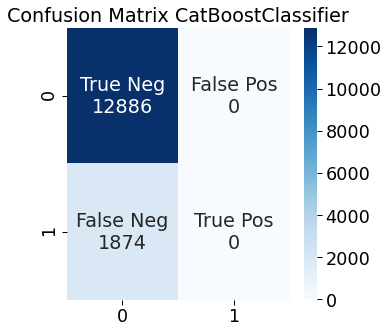

In [96]:
plt.figure(figsize=[5, 5])
plt.title('Confusion Matrix CatBoostClassifier')
    
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_gr).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
            zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_gr), annot=labels, fmt='', cmap='Blues')

## Результаты Grid Search

In [97]:
models = [lr_model, tree_model, extree_model, gb_model, rf_model, cb_model]

# Создание таблицы с метриками:
cols = ['Roc Auc', 'Accuracy', 'Precision', 'Recall', 'f1', 'Log loss']
lst = [] # Запись всех полученных метрик одним списком

# Разбивка списка на список списков (модель - 6 метрик, модель - 6 метрик и т.д.)
lst_1 = zip(*[iter(lst)]*6)

# Расчет метрик:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    lst.append(roc_auc_score(y_test, probs))
    lst.append(accuracy_score(y_test, y_pred))
    lst.append(precision_score(y_test, y_pred, zero_division=0))
    lst.append(recall_score(y_test, y_pred, zero_division=0))
    lst.append(f1_score(y_test, y_pred, zero_division=0))
    lst.append(log_loss(y_test, y_pred))

# Таблица с метриками:
df1 = pd.DataFrame(list(lst_1), columns=cols)
df1 = df1.rename(index={0: 'LogisticR', 1: 'DecisionTree', 2: 'ExtraTree', 
                              3: 'GradientBoost', 4: 'RandomForest', 5: 'CatBoost'})
df_met = df1.T

0:	learn: 0.6562792	total: 12.5ms	remaining: 4.36s
1:	learn: 0.6232155	total: 26ms	remaining: 4.52s
2:	learn: 0.5940063	total: 38ms	remaining: 4.39s
3:	learn: 0.5671203	total: 49.1ms	remaining: 4.25s
4:	learn: 0.5441709	total: 61.6ms	remaining: 4.25s
5:	learn: 0.5230385	total: 75.2ms	remaining: 4.31s
6:	learn: 0.5035230	total: 88.2ms	remaining: 4.32s
7:	learn: 0.4881912	total: 98.9ms	remaining: 4.23s
8:	learn: 0.4747613	total: 110ms	remaining: 4.17s
9:	learn: 0.4609842	total: 120ms	remaining: 4.08s
10:	learn: 0.4502544	total: 133ms	remaining: 4.09s
11:	learn: 0.4401094	total: 143ms	remaining: 4.04s
12:	learn: 0.4307143	total: 154ms	remaining: 3.99s
13:	learn: 0.4225785	total: 168ms	remaining: 4.02s
14:	learn: 0.4158507	total: 180ms	remaining: 4.02s
15:	learn: 0.4099358	total: 192ms	remaining: 4.01s
16:	learn: 0.4042792	total: 204ms	remaining: 3.99s
17:	learn: 0.3995778	total: 214ms	remaining: 3.94s
18:	learn: 0.3949067	total: 225ms	remaining: 3.92s
19:	learn: 0.3910066	total: 236ms	rem

168:	learn: 0.3386919	total: 1.97s	remaining: 2.1s
169:	learn: 0.3386670	total: 1.98s	remaining: 2.09s
170:	learn: 0.3386395	total: 1.99s	remaining: 2.08s
171:	learn: 0.3386126	total: 2s	remaining: 2.07s
172:	learn: 0.3385852	total: 2.01s	remaining: 2.06s
173:	learn: 0.3385457	total: 2.02s	remaining: 2.05s
174:	learn: 0.3385096	total: 2.03s	remaining: 2.03s
175:	learn: 0.3384930	total: 2.05s	remaining: 2.02s
176:	learn: 0.3384574	total: 2.06s	remaining: 2.01s
177:	learn: 0.3384315	total: 2.07s	remaining: 2s
178:	learn: 0.3383999	total: 2.08s	remaining: 1.99s
179:	learn: 0.3383799	total: 2.09s	remaining: 1.98s
180:	learn: 0.3383536	total: 2.1s	remaining: 1.97s
181:	learn: 0.3383291	total: 2.12s	remaining: 1.95s
182:	learn: 0.3383039	total: 2.13s	remaining: 1.94s
183:	learn: 0.3382814	total: 2.14s	remaining: 1.93s
184:	learn: 0.3382533	total: 2.15s	remaining: 1.92s
185:	learn: 0.3382219	total: 2.16s	remaining: 1.91s
186:	learn: 0.3382008	total: 2.17s	remaining: 1.9s
187:	learn: 0.3381742

329:	learn: 0.3348824	total: 3.87s	remaining: 235ms
330:	learn: 0.3348553	total: 3.88s	remaining: 223ms
331:	learn: 0.3348311	total: 3.89s	remaining: 211ms
332:	learn: 0.3348040	total: 3.9s	remaining: 199ms
333:	learn: 0.3348027	total: 3.92s	remaining: 188ms
334:	learn: 0.3347793	total: 3.92s	remaining: 176ms
335:	learn: 0.3347511	total: 3.94s	remaining: 164ms
336:	learn: 0.3347279	total: 3.95s	remaining: 152ms
337:	learn: 0.3347086	total: 3.96s	remaining: 141ms
338:	learn: 0.3346861	total: 3.97s	remaining: 129ms
339:	learn: 0.3346589	total: 3.99s	remaining: 117ms
340:	learn: 0.3346255	total: 4s	remaining: 106ms
341:	learn: 0.3345885	total: 4.01s	remaining: 93.9ms
342:	learn: 0.3345729	total: 4.02s	remaining: 82.1ms
343:	learn: 0.3345551	total: 4.03s	remaining: 70.4ms
344:	learn: 0.3345272	total: 4.05s	remaining: 58.6ms
345:	learn: 0.3345020	total: 4.06s	remaining: 46.9ms
346:	learn: 0.3344794	total: 4.07s	remaining: 35.2ms
347:	learn: 0.3344653	total: 4.08s	remaining: 23.5ms
348:	lear

In [98]:
def highlight_max(x, color):
    return np.where(x == np.nanmax(x.to_numpy()), f"color: {color};", None)

df_met.style.format('{:.4f}').apply(highlight_max, color='blue', axis=1) 

**BASELINE METRICS:**

![jupyter](./base_met.png)

0:	learn: 0.6562792	total: 5.42ms	remaining: 1.89s
1:	learn: 0.6232155	total: 11.2ms	remaining: 1.95s
2:	learn: 0.5940063	total: 16.6ms	remaining: 1.92s
3:	learn: 0.5671203	total: 22.3ms	remaining: 1.93s
4:	learn: 0.5441709	total: 27.2ms	remaining: 1.88s
5:	learn: 0.5230385	total: 32.4ms	remaining: 1.86s
6:	learn: 0.5035230	total: 38ms	remaining: 1.86s
7:	learn: 0.4881912	total: 47.2ms	remaining: 2.02s
8:	learn: 0.4747613	total: 52.5ms	remaining: 1.99s
9:	learn: 0.4609842	total: 57.7ms	remaining: 1.96s
10:	learn: 0.4502544	total: 63.2ms	remaining: 1.95s
11:	learn: 0.4401094	total: 68.2ms	remaining: 1.92s
12:	learn: 0.4307143	total: 72.7ms	remaining: 1.89s
13:	learn: 0.4225785	total: 78.9ms	remaining: 1.89s
14:	learn: 0.4158507	total: 85.5ms	remaining: 1.91s
15:	learn: 0.4099358	total: 91.3ms	remaining: 1.91s
16:	learn: 0.4042792	total: 96.9ms	remaining: 1.9s
17:	learn: 0.3995778	total: 103ms	remaining: 1.89s
18:	learn: 0.3949067	total: 109ms	remaining: 1.9s
19:	learn: 0.3910066	total: 

186:	learn: 0.3382008	total: 1.1s	remaining: 958ms
187:	learn: 0.3381742	total: 1.11s	remaining: 953ms
188:	learn: 0.3381516	total: 1.11s	remaining: 949ms
189:	learn: 0.3381162	total: 1.12s	remaining: 944ms
190:	learn: 0.3380980	total: 1.13s	remaining: 939ms
191:	learn: 0.3380706	total: 1.13s	remaining: 934ms
192:	learn: 0.3380442	total: 1.14s	remaining: 927ms
193:	learn: 0.3380175	total: 1.14s	remaining: 921ms
194:	learn: 0.3379946	total: 1.15s	remaining: 914ms
195:	learn: 0.3379487	total: 1.16s	remaining: 908ms
196:	learn: 0.3379048	total: 1.16s	remaining: 902ms
197:	learn: 0.3378825	total: 1.17s	remaining: 896ms
198:	learn: 0.3378535	total: 1.17s	remaining: 890ms
199:	learn: 0.3378099	total: 1.18s	remaining: 884ms
200:	learn: 0.3377885	total: 1.19s	remaining: 879ms
201:	learn: 0.3377630	total: 1.19s	remaining: 873ms
202:	learn: 0.3377207	total: 1.2s	remaining: 867ms
203:	learn: 0.3377013	total: 1.2s	remaining: 861ms
204:	learn: 0.3376723	total: 1.21s	remaining: 856ms
205:	learn: 0.3

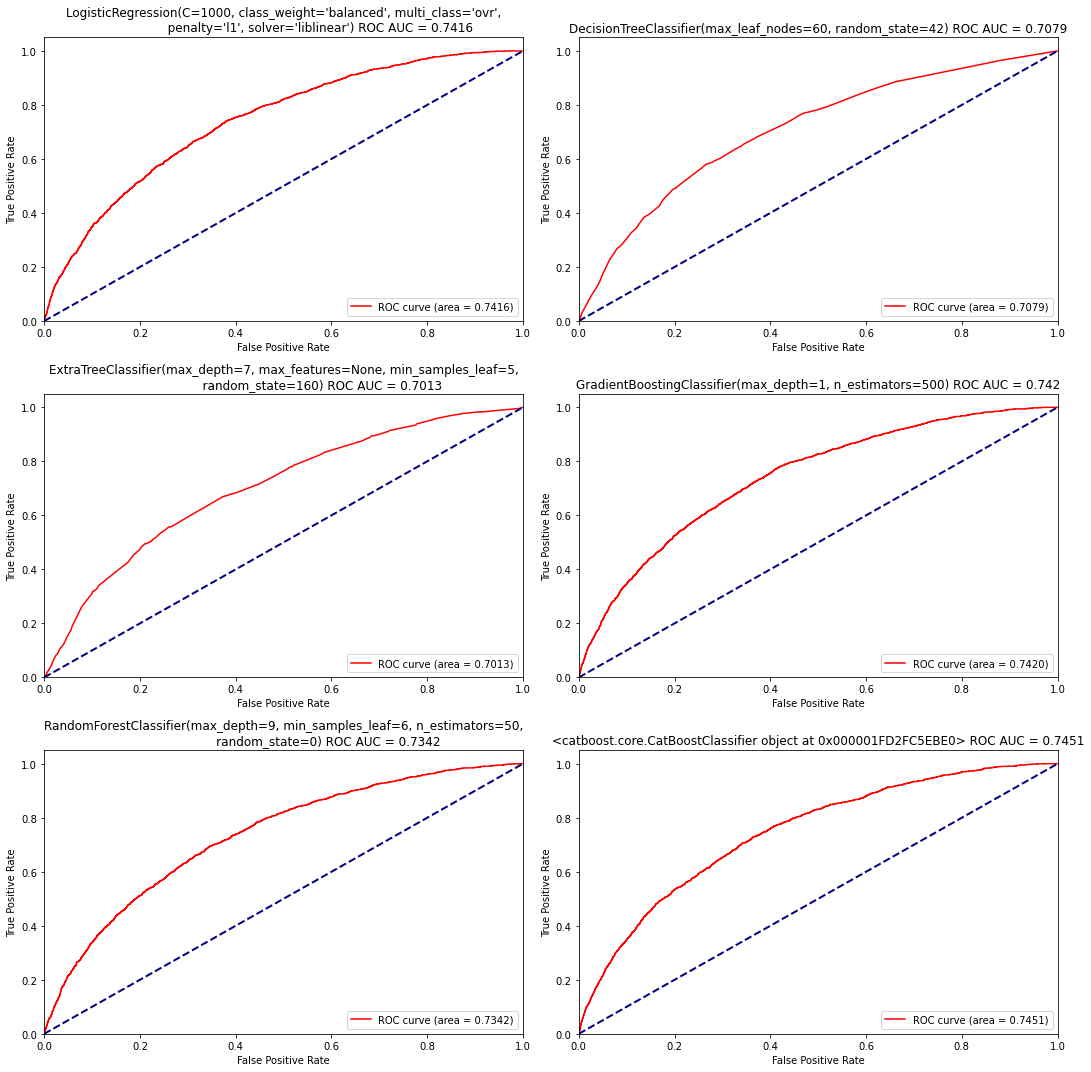

In [100]:
plt.figure(figsize=[15, 15])
k = 1
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    
    plt.subplot(3, 2, k)
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    name = model 
    num = float('{:.4f}'.format(roc_auc))
    
    plt.title(F"{name} ROC AUC = {num}")
    plt.legend(loc="lower right")
    k+=1
plt.tight_layout()
plt.show()

# Две лучшие модели:

In [ ]:
# CatBoost =>  Auc = 0.7451
# LogisticR =>  Auc = 0.7416
# GradientBoost - намеренно не учитывается в ансамбле

In [112]:
# LogisticR

lr_params = {'C': 1000, 'class_weight': 'balanced', 
               'max_iter': 100, 'multi_class': 'ovr', 
               'penalty': 'l1', 'solver': 'liblinear'}

best_lr = LogisticRegression(**lr_params)
best_lr.fit(X_train, y_train)

y_pred_lr = best_lr.predict(X_test)
y_score_lr = best_lr.predict_proba(X_test)[:,1]

In [113]:
# CatBoost

cb_params = {'depth': 4, 'early_stopping_rounds': 10, 
             'iterations': 350, 'l2_leaf_reg': 7, 'learning_rate': 0.05}

best_cb = CatBoostClassifier(**cb_params)

best_cb.fit(X_train, y_train)

y_pred_cb = best_cb.predict(X_test)
y_score_cb = best_cb.predict_proba(X_test)[:,1]

0:	learn: 0.6562792	total: 8.51ms	remaining: 2.97s
1:	learn: 0.6232155	total: 17ms	remaining: 2.96s
2:	learn: 0.5940063	total: 25.8ms	remaining: 2.99s
3:	learn: 0.5671203	total: 31.7ms	remaining: 2.74s
4:	learn: 0.5441709	total: 39.2ms	remaining: 2.7s
5:	learn: 0.5230385	total: 47ms	remaining: 2.69s
6:	learn: 0.5035230	total: 54.9ms	remaining: 2.69s
7:	learn: 0.4881912	total: 62.6ms	remaining: 2.67s
8:	learn: 0.4747613	total: 70ms	remaining: 2.65s
9:	learn: 0.4609842	total: 78.3ms	remaining: 2.66s
10:	learn: 0.4502544	total: 86.5ms	remaining: 2.67s
11:	learn: 0.4401094	total: 94.3ms	remaining: 2.65s
12:	learn: 0.4307143	total: 102ms	remaining: 2.65s
13:	learn: 0.4225785	total: 111ms	remaining: 2.66s
14:	learn: 0.4158507	total: 119ms	remaining: 2.65s
15:	learn: 0.4099358	total: 127ms	remaining: 2.65s
16:	learn: 0.4042792	total: 134ms	remaining: 2.63s
17:	learn: 0.3995778	total: 141ms	remaining: 2.61s
18:	learn: 0.3949067	total: 149ms	remaining: 2.6s
19:	learn: 0.3910066	total: 157ms	rem

172:	learn: 0.3385852	total: 1.69s	remaining: 1.73s
173:	learn: 0.3385457	total: 1.7s	remaining: 1.72s
174:	learn: 0.3385096	total: 1.71s	remaining: 1.71s
175:	learn: 0.3384930	total: 1.72s	remaining: 1.7s
176:	learn: 0.3384574	total: 1.73s	remaining: 1.69s
177:	learn: 0.3384315	total: 1.74s	remaining: 1.68s
178:	learn: 0.3383999	total: 1.75s	remaining: 1.67s
179:	learn: 0.3383799	total: 1.76s	remaining: 1.66s
180:	learn: 0.3383536	total: 1.77s	remaining: 1.65s
181:	learn: 0.3383291	total: 1.78s	remaining: 1.64s
182:	learn: 0.3383039	total: 1.79s	remaining: 1.63s
183:	learn: 0.3382814	total: 1.8s	remaining: 1.62s
184:	learn: 0.3382533	total: 1.8s	remaining: 1.61s
185:	learn: 0.3382219	total: 1.81s	remaining: 1.6s
186:	learn: 0.3382008	total: 1.82s	remaining: 1.59s
187:	learn: 0.3381742	total: 1.83s	remaining: 1.58s
188:	learn: 0.3381516	total: 1.84s	remaining: 1.57s
189:	learn: 0.3381162	total: 1.85s	remaining: 1.56s
190:	learn: 0.3380980	total: 1.86s	remaining: 1.55s
191:	learn: 0.338

340:	learn: 0.3346255	total: 3.41s	remaining: 90ms
341:	learn: 0.3345885	total: 3.42s	remaining: 80ms
342:	learn: 0.3345729	total: 3.43s	remaining: 70ms
343:	learn: 0.3345551	total: 3.44s	remaining: 60ms
344:	learn: 0.3345272	total: 3.45s	remaining: 50ms
345:	learn: 0.3345020	total: 3.46s	remaining: 40ms
346:	learn: 0.3344794	total: 3.48s	remaining: 30ms
347:	learn: 0.3344653	total: 3.48s	remaining: 20ms
348:	learn: 0.3344404	total: 3.5s	remaining: 10ms
349:	learn: 0.3344101	total: 3.51s	remaining: 0us


In [123]:
for alpha in np.arange(0.1, 1.1, 0.1):
    res = alpha * y_score_lr + (1 - alpha) * y_score_cb
#     print(alpha, res)
    pred = []
    for elem in res:
        pred.append(np.argmax(elem))
        #print(pred)
    print('alpha:', alpha, 'score:', roc_auc_score(y_test, pred))
# print(pred)

alpha: 0.1 score: 0.5
alpha: 0.2 score: 0.5
alpha: 0.30000000000000004 score: 0.5
alpha: 0.4 score: 0.5
alpha: 0.5 score: 0.5
alpha: 0.6 score: 0.5
alpha: 0.7000000000000001 score: 0.5
alpha: 0.8 score: 0.5
alpha: 0.9 score: 0.5
alpha: 1.0 score: 0.5


### StackingClassifier (Ансамбль)

In [100]:
from sklearn.ensemble import StackingClassifier

cb_params = {'depth': 4, 'early_stopping_rounds': 10, 
             'iterations': 350, 'l2_leaf_reg': 7, 'learning_rate': 0.05}
gb_params = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500}

estimators = [
    ('cb', CatBoostClassifier(**cb_params)),
    ('gb', GradientBoostingClassifier(**gb_params))]
                          
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

clf.fit(X_train, y_train)

y_pred_SC = clf.predict(X_test)
y_score_SC = clf.predict_proba(X_test)[:,1]

print('roc-auc:', roc_auc_score(y_test, y_score_SC))
print('precision:', precision_score(y_test, y_pred_SC))
print('accuracy:', accuracy_score(y_test, y_pred_SC))
print('recall:', recall_score(y_test, y_pred_SC))
print('f1:', f1_score(y_test, y_pred_SC))
print('logloss:', log_loss(y_test, y_pred_SC))

0:	learn: 0.6562792	total: 10.8ms	remaining: 3.76s
1:	learn: 0.6232155	total: 23.8ms	remaining: 4.15s
2:	learn: 0.5940063	total: 35.6ms	remaining: 4.12s
3:	learn: 0.5671203	total: 44.5ms	remaining: 3.85s
4:	learn: 0.5441709	total: 55.8ms	remaining: 3.85s
5:	learn: 0.5230385	total: 67.9ms	remaining: 3.89s
6:	learn: 0.5035230	total: 79.3ms	remaining: 3.88s
7:	learn: 0.4881912	total: 97.5ms	remaining: 4.17s
8:	learn: 0.4747613	total: 109ms	remaining: 4.14s
9:	learn: 0.4609842	total: 120ms	remaining: 4.09s
10:	learn: 0.4502544	total: 131ms	remaining: 4.04s
11:	learn: 0.4401094	total: 142ms	remaining: 3.98s
12:	learn: 0.4307143	total: 151ms	remaining: 3.92s
13:	learn: 0.4225785	total: 162ms	remaining: 3.9s
14:	learn: 0.4158507	total: 175ms	remaining: 3.9s
15:	learn: 0.4099358	total: 187ms	remaining: 3.9s
16:	learn: 0.4042792	total: 197ms	remaining: 3.86s
17:	learn: 0.3995778	total: 206ms	remaining: 3.81s
18:	learn: 0.3949067	total: 219ms	remaining: 3.81s
19:	learn: 0.3910066	total: 230ms	re

172:	learn: 0.3385852	total: 1.97s	remaining: 2.01s
173:	learn: 0.3385457	total: 1.98s	remaining: 2s
174:	learn: 0.3385096	total: 1.99s	remaining: 1.99s
175:	learn: 0.3384930	total: 2s	remaining: 1.98s
176:	learn: 0.3384574	total: 2.01s	remaining: 1.97s
177:	learn: 0.3384315	total: 2.02s	remaining: 1.96s
178:	learn: 0.3383999	total: 2.04s	remaining: 1.94s
179:	learn: 0.3383799	total: 2.05s	remaining: 1.93s
180:	learn: 0.3383536	total: 2.06s	remaining: 1.92s
181:	learn: 0.3383291	total: 2.07s	remaining: 1.91s
182:	learn: 0.3383039	total: 2.08s	remaining: 1.9s
183:	learn: 0.3382814	total: 2.09s	remaining: 1.89s
184:	learn: 0.3382533	total: 2.1s	remaining: 1.88s
185:	learn: 0.3382219	total: 2.12s	remaining: 1.87s
186:	learn: 0.3382008	total: 2.13s	remaining: 1.85s
187:	learn: 0.3381742	total: 2.14s	remaining: 1.84s
188:	learn: 0.3381516	total: 2.15s	remaining: 1.83s
189:	learn: 0.3381162	total: 2.16s	remaining: 1.82s
190:	learn: 0.3380980	total: 2.17s	remaining: 1.81s
191:	learn: 0.338070

340:	learn: 0.3346255	total: 3.93s	remaining: 104ms
341:	learn: 0.3345885	total: 3.94s	remaining: 92.3ms
342:	learn: 0.3345729	total: 3.96s	remaining: 80.7ms
343:	learn: 0.3345551	total: 3.97s	remaining: 69.2ms
344:	learn: 0.3345272	total: 3.98s	remaining: 57.7ms
345:	learn: 0.3345020	total: 3.99s	remaining: 46.1ms
346:	learn: 0.3344794	total: 4s	remaining: 34.6ms
347:	learn: 0.3344653	total: 4.01s	remaining: 23.1ms
348:	learn: 0.3344404	total: 4.03s	remaining: 11.5ms
349:	learn: 0.3344101	total: 4.04s	remaining: 0us
0:	learn: 0.6561297	total: 9.24ms	remaining: 3.23s
1:	learn: 0.6252748	total: 18.3ms	remaining: 3.19s
2:	learn: 0.5956773	total: 27.9ms	remaining: 3.23s
3:	learn: 0.5704386	total: 36.7ms	remaining: 3.17s
4:	learn: 0.5472837	total: 45.8ms	remaining: 3.16s
5:	learn: 0.5267077	total: 54.7ms	remaining: 3.14s
6:	learn: 0.5083804	total: 64.1ms	remaining: 3.14s
7:	learn: 0.4908243	total: 73.3ms	remaining: 3.13s
8:	learn: 0.4756260	total: 82.9ms	remaining: 3.14s
9:	learn: 0.462455

168:	learn: 0.3372518	total: 1.67s	remaining: 1.79s
169:	learn: 0.3372101	total: 1.7s	remaining: 1.8s
170:	learn: 0.3371492	total: 1.71s	remaining: 1.79s
171:	learn: 0.3371102	total: 1.72s	remaining: 1.78s
172:	learn: 0.3370681	total: 1.73s	remaining: 1.77s
173:	learn: 0.3370276	total: 1.74s	remaining: 1.76s
174:	learn: 0.3370012	total: 1.75s	remaining: 1.75s
175:	learn: 0.3369799	total: 1.76s	remaining: 1.74s
176:	learn: 0.3369416	total: 1.77s	remaining: 1.73s
177:	learn: 0.3369084	total: 1.78s	remaining: 1.72s
178:	learn: 0.3368699	total: 1.79s	remaining: 1.71s
179:	learn: 0.3368392	total: 1.8s	remaining: 1.7s
180:	learn: 0.3368097	total: 1.8s	remaining: 1.69s
181:	learn: 0.3367753	total: 1.82s	remaining: 1.68s
182:	learn: 0.3367253	total: 1.83s	remaining: 1.67s
183:	learn: 0.3366566	total: 1.84s	remaining: 1.66s
184:	learn: 0.3366240	total: 1.85s	remaining: 1.65s
185:	learn: 0.3365988	total: 1.87s	remaining: 1.65s
186:	learn: 0.3365570	total: 1.88s	remaining: 1.64s
187:	learn: 0.336

338:	learn: 0.3325023	total: 3.61s	remaining: 117ms
339:	learn: 0.3324458	total: 3.62s	remaining: 107ms
340:	learn: 0.3324166	total: 3.63s	remaining: 95.8ms
341:	learn: 0.3324001	total: 3.64s	remaining: 85.2ms
342:	learn: 0.3323679	total: 3.65s	remaining: 74.5ms
343:	learn: 0.3323435	total: 3.66s	remaining: 63.9ms
344:	learn: 0.3323190	total: 3.67s	remaining: 53.2ms
345:	learn: 0.3322923	total: 3.68s	remaining: 42.6ms
346:	learn: 0.3322737	total: 3.69s	remaining: 31.9ms
347:	learn: 0.3322414	total: 3.7s	remaining: 21.3ms
348:	learn: 0.3321981	total: 3.71s	remaining: 10.6ms
349:	learn: 0.3321742	total: 3.72s	remaining: 0us
0:	learn: 0.6562328	total: 11.4ms	remaining: 3.97s
1:	learn: 0.6251901	total: 22.8ms	remaining: 3.96s
2:	learn: 0.5972199	total: 33.8ms	remaining: 3.91s
3:	learn: 0.5714799	total: 43.8ms	remaining: 3.79s
4:	learn: 0.5477846	total: 54.2ms	remaining: 3.74s
5:	learn: 0.5266637	total: 65.4ms	remaining: 3.75s
6:	learn: 0.5078744	total: 77.5ms	remaining: 3.8s
7:	learn: 0.49

159:	learn: 0.3390329	total: 1.74s	remaining: 2.07s
160:	learn: 0.3390005	total: 1.75s	remaining: 2.06s
161:	learn: 0.3389511	total: 1.76s	remaining: 2.04s
162:	learn: 0.3389137	total: 1.77s	remaining: 2.03s
163:	learn: 0.3388713	total: 1.78s	remaining: 2.02s
164:	learn: 0.3388364	total: 1.79s	remaining: 2.01s
165:	learn: 0.3388123	total: 1.81s	remaining: 2s
166:	learn: 0.3387563	total: 1.82s	remaining: 1.99s
167:	learn: 0.3387174	total: 1.83s	remaining: 1.98s
168:	learn: 0.3386890	total: 1.84s	remaining: 1.97s
169:	learn: 0.3386539	total: 1.85s	remaining: 1.96s
170:	learn: 0.3386217	total: 1.86s	remaining: 1.95s
171:	learn: 0.3386054	total: 1.88s	remaining: 1.94s
172:	learn: 0.3385653	total: 1.89s	remaining: 1.93s
173:	learn: 0.3385375	total: 1.9s	remaining: 1.92s
174:	learn: 0.3385106	total: 1.91s	remaining: 1.91s
175:	learn: 0.3384907	total: 1.92s	remaining: 1.9s
176:	learn: 0.3384623	total: 1.93s	remaining: 1.88s
177:	learn: 0.3384302	total: 1.94s	remaining: 1.88s
178:	learn: 0.338

330:	learn: 0.3337023	total: 3.67s	remaining: 211ms
331:	learn: 0.3336768	total: 3.69s	remaining: 200ms
332:	learn: 0.3336515	total: 3.69s	remaining: 189ms
333:	learn: 0.3336139	total: 3.71s	remaining: 178ms
334:	learn: 0.3335783	total: 3.72s	remaining: 167ms
335:	learn: 0.3335761	total: 3.73s	remaining: 155ms
336:	learn: 0.3335749	total: 3.74s	remaining: 144ms
337:	learn: 0.3335357	total: 3.75s	remaining: 133ms
338:	learn: 0.3335069	total: 3.77s	remaining: 122ms
339:	learn: 0.3334797	total: 3.78s	remaining: 111ms
340:	learn: 0.3334514	total: 3.79s	remaining: 100ms
341:	learn: 0.3334493	total: 3.8s	remaining: 88.8ms
342:	learn: 0.3334318	total: 3.81s	remaining: 77.7ms
343:	learn: 0.3334039	total: 3.82s	remaining: 66.6ms
344:	learn: 0.3333808	total: 3.83s	remaining: 55.5ms
345:	learn: 0.3333572	total: 3.84s	remaining: 44.4ms
346:	learn: 0.3333344	total: 3.85s	remaining: 33.3ms
347:	learn: 0.3332978	total: 3.87s	remaining: 22.2ms
348:	learn: 0.3332741	total: 3.88s	remaining: 11.1ms
349:	

147:	learn: 0.3387661	total: 1.54s	remaining: 2.11s
148:	learn: 0.3387104	total: 1.56s	remaining: 2.1s
149:	learn: 0.3386677	total: 1.57s	remaining: 2.09s
150:	learn: 0.3386466	total: 1.58s	remaining: 2.08s
151:	learn: 0.3386192	total: 1.59s	remaining: 2.07s
152:	learn: 0.3385488	total: 1.6s	remaining: 2.06s
153:	learn: 0.3385101	total: 1.61s	remaining: 2.05s
154:	learn: 0.3384657	total: 1.62s	remaining: 2.04s
155:	learn: 0.3384173	total: 1.64s	remaining: 2.03s
156:	learn: 0.3383524	total: 1.65s	remaining: 2.02s
157:	learn: 0.3383145	total: 1.66s	remaining: 2.01s
158:	learn: 0.3382739	total: 1.67s	remaining: 2s
159:	learn: 0.3382037	total: 1.68s	remaining: 1.99s
160:	learn: 0.3381685	total: 1.69s	remaining: 1.98s
161:	learn: 0.3381331	total: 1.7s	remaining: 1.98s
162:	learn: 0.3380953	total: 1.71s	remaining: 1.96s
163:	learn: 0.3380602	total: 1.72s	remaining: 1.95s
164:	learn: 0.3380353	total: 1.73s	remaining: 1.94s
165:	learn: 0.3379849	total: 1.74s	remaining: 1.93s
166:	learn: 0.3379

308:	learn: 0.3331972	total: 3.28s	remaining: 436ms
309:	learn: 0.3331777	total: 3.29s	remaining: 425ms
310:	learn: 0.3331501	total: 3.3s	remaining: 414ms
311:	learn: 0.3331072	total: 3.31s	remaining: 404ms
312:	learn: 0.3330876	total: 3.33s	remaining: 393ms
313:	learn: 0.3330634	total: 3.34s	remaining: 383ms
314:	learn: 0.3330352	total: 3.35s	remaining: 372ms
315:	learn: 0.3330005	total: 3.36s	remaining: 361ms
316:	learn: 0.3329829	total: 3.37s	remaining: 351ms
317:	learn: 0.3329502	total: 3.38s	remaining: 340ms
318:	learn: 0.3329144	total: 3.39s	remaining: 330ms
319:	learn: 0.3328760	total: 3.4s	remaining: 319ms
320:	learn: 0.3328421	total: 3.41s	remaining: 308ms
321:	learn: 0.3328198	total: 3.42s	remaining: 298ms
322:	learn: 0.3327821	total: 3.44s	remaining: 287ms
323:	learn: 0.3327523	total: 3.45s	remaining: 277ms
324:	learn: 0.3327200	total: 3.46s	remaining: 266ms
325:	learn: 0.3326910	total: 3.47s	remaining: 255ms
326:	learn: 0.3326635	total: 3.5s	remaining: 246ms
327:	learn: 0.3

123:	learn: 0.3401724	total: 1.35s	remaining: 2.46s
124:	learn: 0.3401240	total: 1.36s	remaining: 2.44s
125:	learn: 0.3400859	total: 1.37s	remaining: 2.43s
126:	learn: 0.3400353	total: 1.38s	remaining: 2.42s
127:	learn: 0.3399633	total: 1.39s	remaining: 2.41s
128:	learn: 0.3399163	total: 1.4s	remaining: 2.4s
129:	learn: 0.3398744	total: 1.41s	remaining: 2.39s
130:	learn: 0.3398294	total: 1.42s	remaining: 2.38s
131:	learn: 0.3397903	total: 1.43s	remaining: 2.37s
132:	learn: 0.3397601	total: 1.44s	remaining: 2.36s
133:	learn: 0.3397237	total: 1.45s	remaining: 2.34s
134:	learn: 0.3396746	total: 1.46s	remaining: 2.33s
135:	learn: 0.3396388	total: 1.48s	remaining: 2.32s
136:	learn: 0.3395709	total: 1.49s	remaining: 2.31s
137:	learn: 0.3395320	total: 1.5s	remaining: 2.3s
138:	learn: 0.3394873	total: 1.5s	remaining: 2.28s
139:	learn: 0.3394555	total: 1.52s	remaining: 2.27s
140:	learn: 0.3394284	total: 1.53s	remaining: 2.26s
141:	learn: 0.3394096	total: 1.54s	remaining: 2.25s
142:	learn: 0.339

288:	learn: 0.3348693	total: 3.09s	remaining: 652ms
289:	learn: 0.3348484	total: 3.1s	remaining: 641ms
290:	learn: 0.3347840	total: 3.11s	remaining: 631ms
291:	learn: 0.3347823	total: 3.12s	remaining: 620ms
292:	learn: 0.3347808	total: 3.13s	remaining: 609ms
293:	learn: 0.3347421	total: 3.14s	remaining: 598ms
294:	learn: 0.3347118	total: 3.15s	remaining: 587ms
295:	learn: 0.3346650	total: 3.16s	remaining: 577ms
296:	learn: 0.3346260	total: 3.17s	remaining: 566ms
297:	learn: 0.3346245	total: 3.18s	remaining: 555ms
298:	learn: 0.3345835	total: 3.19s	remaining: 545ms
299:	learn: 0.3345820	total: 3.2s	remaining: 534ms
300:	learn: 0.3345805	total: 3.21s	remaining: 523ms
301:	learn: 0.3345525	total: 3.22s	remaining: 512ms
302:	learn: 0.3345144	total: 3.23s	remaining: 502ms
303:	learn: 0.3344829	total: 3.25s	remaining: 491ms
304:	learn: 0.3344722	total: 3.26s	remaining: 481ms
305:	learn: 0.3344349	total: 3.27s	remaining: 470ms
306:	learn: 0.3343891	total: 3.28s	remaining: 459ms
307:	learn: 0.

114:	learn: 0.3413330	total: 1.17s	remaining: 2.4s
115:	learn: 0.3412329	total: 1.18s	remaining: 2.38s
116:	learn: 0.3411803	total: 1.19s	remaining: 2.37s
117:	learn: 0.3411308	total: 1.2s	remaining: 2.36s
118:	learn: 0.3410602	total: 1.21s	remaining: 2.35s
119:	learn: 0.3410266	total: 1.22s	remaining: 2.35s
120:	learn: 0.3409543	total: 1.24s	remaining: 2.34s
121:	learn: 0.3409170	total: 1.25s	remaining: 2.33s
122:	learn: 0.3408690	total: 1.26s	remaining: 2.32s
123:	learn: 0.3408221	total: 1.27s	remaining: 2.31s
124:	learn: 0.3407664	total: 1.28s	remaining: 2.31s
125:	learn: 0.3407150	total: 1.29s	remaining: 2.29s
126:	learn: 0.3406392	total: 1.3s	remaining: 2.29s
127:	learn: 0.3405946	total: 1.31s	remaining: 2.28s
128:	learn: 0.3405257	total: 1.32s	remaining: 2.27s
129:	learn: 0.3404532	total: 1.33s	remaining: 2.26s
130:	learn: 0.3404213	total: 1.35s	remaining: 2.25s
131:	learn: 0.3403785	total: 1.36s	remaining: 2.24s
132:	learn: 0.3403044	total: 1.37s	remaining: 2.23s
133:	learn: 0.3

288:	learn: 0.3357665	total: 3.09s	remaining: 652ms
289:	learn: 0.3357284	total: 3.1s	remaining: 641ms
290:	learn: 0.3356829	total: 3.11s	remaining: 630ms
291:	learn: 0.3356591	total: 3.12s	remaining: 620ms
292:	learn: 0.3356073	total: 3.13s	remaining: 609ms
293:	learn: 0.3355737	total: 3.14s	remaining: 598ms
294:	learn: 0.3355288	total: 3.15s	remaining: 588ms
295:	learn: 0.3355023	total: 3.16s	remaining: 577ms
296:	learn: 0.3354587	total: 3.17s	remaining: 566ms
297:	learn: 0.3354571	total: 3.18s	remaining: 555ms
298:	learn: 0.3354560	total: 3.19s	remaining: 545ms
299:	learn: 0.3354551	total: 3.2s	remaining: 534ms
300:	learn: 0.3354357	total: 3.21s	remaining: 523ms
301:	learn: 0.3353955	total: 3.23s	remaining: 513ms
302:	learn: 0.3353586	total: 3.24s	remaining: 502ms
303:	learn: 0.3353183	total: 3.25s	remaining: 492ms
304:	learn: 0.3352857	total: 3.26s	remaining: 481ms
305:	learn: 0.3352523	total: 3.27s	remaining: 471ms
306:	learn: 0.3352255	total: 3.28s	remaining: 460ms
307:	learn: 0.

<AxesSubplot:title={'center':'Confusion Matrix CatBoost,GradientBoosting+LogisticR'}>

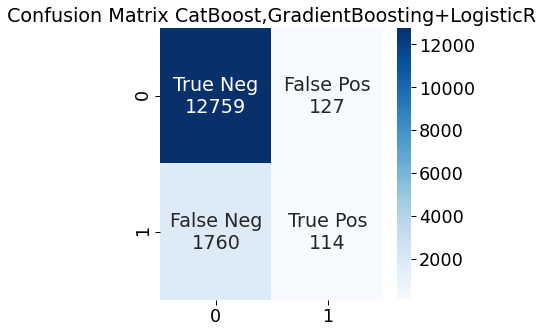

In [128]:
plt.figure(figsize=[5, 5])
plt.title('Confusion Matrix CatBoost,GradientBoosting+LogisticR')
    
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_SC).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
            zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_SC), annot=labels, fmt='', cmap='Blues')

### AdaBoostClassifier

In [129]:
from sklearn.ensemble import AdaBoostClassifier

ad = AdaBoostClassifier(n_estimators=100, random_state=0)
ad.fit(X_train, y_train)

y_pred_ad = clf.predict(X_test)
y_score_ad = clf.predict_proba(X_test)[:,1]

print('roc-auc:', roc_auc_score(y_test, y_score_ad))
print('precision:', precision_score(y_test, y_pred_ad))
print('accuracy:', accuracy_score(y_test, y_pred_ad))
print('recall:', recall_score(y_test, y_pred_ad))
print('f1:', f1_score(y_test, y_pred_ad))
print('logloss:', log_loss(y_test, y_pred_ad))

roc-auc: 0.7447427494467121
precision: 0.4730290456431535
accuracy: 0.8721544715447155
recall: 0.060832443970117396
f1: 0.1078014184397163
logloss: 4.415635000411253


# Несбалансированность

In [101]:
# Запись метрик в таблицу
best_cb = CatBoostClassifier(**cb_params)

best_cb.fit(X_train, y_train)

y_pred_cb = best_cb.predict(X_test)
y_score_cb = best_cb.predict_proba(X_test)[:,1]

lst_cb = [] 
lst_1 = zip(*[iter(lst_cb)]*6)

lst_cb.append(roc_auc_score(y_test, probs))
lst_cb.append(accuracy_score(y_test, y_pred))
lst_cb.append(precision_score(y_test, y_pred, zero_division=0))
lst_cb.append(recall_score(y_test, y_pred, zero_division=0))
lst_cb.append(f1_score(y_test, y_pred, zero_division=0))
lst_cb.append(log_loss(y_test, y_pred))

df1 = pd.DataFrame(list(lst_1), columns=cols)

0:	learn: 0.6562792	total: 11.7ms	remaining: 4.08s
1:	learn: 0.6232155	total: 23ms	remaining: 4s
2:	learn: 0.5940063	total: 35.1ms	remaining: 4.06s
3:	learn: 0.5671203	total: 45.8ms	remaining: 3.96s
4:	learn: 0.5441709	total: 56.7ms	remaining: 3.91s
5:	learn: 0.5230385	total: 68.5ms	remaining: 3.92s
6:	learn: 0.5035230	total: 81.4ms	remaining: 3.99s
7:	learn: 0.4881912	total: 92.4ms	remaining: 3.95s
8:	learn: 0.4747613	total: 104ms	remaining: 3.95s
9:	learn: 0.4609842	total: 115ms	remaining: 3.9s
10:	learn: 0.4502544	total: 126ms	remaining: 3.87s
11:	learn: 0.4401094	total: 136ms	remaining: 3.82s
12:	learn: 0.4307143	total: 146ms	remaining: 3.78s
13:	learn: 0.4225785	total: 157ms	remaining: 3.77s
14:	learn: 0.4158507	total: 173ms	remaining: 3.85s
15:	learn: 0.4099358	total: 185ms	remaining: 3.86s
16:	learn: 0.4042792	total: 196ms	remaining: 3.84s
17:	learn: 0.3995778	total: 208ms	remaining: 3.83s
18:	learn: 0.3949067	total: 219ms	remaining: 3.81s
19:	learn: 0.3910066	total: 231ms	remai

169:	learn: 0.3386670	total: 1.98s	remaining: 2.1s
170:	learn: 0.3386395	total: 1.99s	remaining: 2.09s
171:	learn: 0.3386126	total: 2.01s	remaining: 2.08s
172:	learn: 0.3385852	total: 2.02s	remaining: 2.06s
173:	learn: 0.3385457	total: 2.03s	remaining: 2.05s
174:	learn: 0.3385096	total: 2.04s	remaining: 2.04s
175:	learn: 0.3384930	total: 2.05s	remaining: 2.03s
176:	learn: 0.3384574	total: 2.06s	remaining: 2.02s
177:	learn: 0.3384315	total: 2.08s	remaining: 2.01s
178:	learn: 0.3383999	total: 2.09s	remaining: 2s
179:	learn: 0.3383799	total: 2.1s	remaining: 1.98s
180:	learn: 0.3383536	total: 2.11s	remaining: 1.97s
181:	learn: 0.3383291	total: 2.12s	remaining: 1.96s
182:	learn: 0.3383039	total: 2.13s	remaining: 1.95s
183:	learn: 0.3382814	total: 2.15s	remaining: 1.94s
184:	learn: 0.3382533	total: 2.16s	remaining: 1.93s
185:	learn: 0.3382219	total: 2.17s	remaining: 1.91s
186:	learn: 0.3382008	total: 2.18s	remaining: 1.9s
187:	learn: 0.3381742	total: 2.19s	remaining: 1.89s
188:	learn: 0.3381

337:	learn: 0.3347086	total: 3.94s	remaining: 140ms
338:	learn: 0.3346861	total: 3.95s	remaining: 128ms
339:	learn: 0.3346589	total: 3.96s	remaining: 116ms
340:	learn: 0.3346255	total: 3.97s	remaining: 105ms
341:	learn: 0.3345885	total: 3.98s	remaining: 93.2ms
342:	learn: 0.3345729	total: 4s	remaining: 81.5ms
343:	learn: 0.3345551	total: 4.01s	remaining: 69.9ms
344:	learn: 0.3345272	total: 4.02s	remaining: 58.2ms
345:	learn: 0.3345020	total: 4.03s	remaining: 46.6ms
346:	learn: 0.3344794	total: 4.04s	remaining: 35ms
347:	learn: 0.3344653	total: 4.06s	remaining: 23.3ms
348:	learn: 0.3344404	total: 4.07s	remaining: 11.7ms
349:	learn: 0.3344101	total: 4.08s	remaining: 0us


In [ ]:
# !pip install imblearn

In [102]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [103]:
from collections import Counter

X = df.drop('default', axis=1)
y = df['default']

print('Original dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 64427, 1: 9372})


In [104]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

print('Resampled dataset shape {}'.format(Counter(y_ros)))

Resampled dataset shape Counter({0: 64427, 1: 64427})


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, stratify=y_ros, 
                                                    shuffle=True, random_state=RANDOM_SEED)

cb_params = {'depth': 4, 'early_stopping_rounds': 10, 
             'iterations': 350, 'l2_leaf_reg': 7, 'learning_rate': 0.05}

best_cb_ros = CatBoostClassifier(**cb_params)

best_cb_ros.fit(X_train, y_train)

y_pred_cb = best_cb_ros.predict(X_test)
y_score_cb = best_cb_ros.predict_proba(X_test)[:,1]

# Запись метрик в таблицу
lst_cb_ros = [] 
lst_2 = zip(*[iter(lst_cb_ros)]*6)

lst_cb_ros.append(roc_auc_score(y_test, y_score_cb))
lst_cb_ros.append(accuracy_score(y_test, y_pred_cb))
lst_cb_ros.append(precision_score(y_test, y_pred_cb, zero_division=0))
lst_cb_ros.append(recall_score(y_test, y_pred_cb, zero_division=0))
lst_cb_ros.append(f1_score(y_test, y_pred_cb, zero_division=0))
lst_cb_ros.append(log_loss(y_test, y_pred_cb))

df2 = pd.DataFrame(list(lst_2), columns=cols)

0:	learn: 0.6880041	total: 18.5ms	remaining: 6.45s
1:	learn: 0.6828899	total: 37.6ms	remaining: 6.55s
2:	learn: 0.6781902	total: 54.1ms	remaining: 6.26s
3:	learn: 0.6739921	total: 67.7ms	remaining: 5.86s
4:	learn: 0.6705400	total: 81.8ms	remaining: 5.64s
5:	learn: 0.6673262	total: 96.6ms	remaining: 5.54s
6:	learn: 0.6640136	total: 112ms	remaining: 5.49s
7:	learn: 0.6612392	total: 127ms	remaining: 5.41s
8:	learn: 0.6587008	total: 143ms	remaining: 5.43s
9:	learn: 0.6562660	total: 161ms	remaining: 5.48s
10:	learn: 0.6540235	total: 178ms	remaining: 5.49s
11:	learn: 0.6519403	total: 193ms	remaining: 5.44s
12:	learn: 0.6496058	total: 212ms	remaining: 5.48s
13:	learn: 0.6473848	total: 231ms	remaining: 5.54s
14:	learn: 0.6455979	total: 249ms	remaining: 5.55s
15:	learn: 0.6437579	total: 267ms	remaining: 5.58s
16:	learn: 0.6422835	total: 283ms	remaining: 5.55s
17:	learn: 0.6407685	total: 302ms	remaining: 5.56s
18:	learn: 0.6391235	total: 320ms	remaining: 5.57s
19:	learn: 0.6379098	total: 339ms	r

169:	learn: 0.5955866	total: 2.79s	remaining: 2.95s
170:	learn: 0.5955445	total: 2.8s	remaining: 2.93s
171:	learn: 0.5954815	total: 2.82s	remaining: 2.92s
172:	learn: 0.5954191	total: 2.84s	remaining: 2.9s
173:	learn: 0.5953466	total: 2.85s	remaining: 2.89s
174:	learn: 0.5952471	total: 2.87s	remaining: 2.87s
175:	learn: 0.5951924	total: 2.89s	remaining: 2.85s
176:	learn: 0.5951024	total: 2.9s	remaining: 2.84s
177:	learn: 0.5950379	total: 2.92s	remaining: 2.82s
178:	learn: 0.5949932	total: 2.94s	remaining: 2.8s
179:	learn: 0.5949393	total: 2.95s	remaining: 2.79s
180:	learn: 0.5948572	total: 2.96s	remaining: 2.77s
181:	learn: 0.5947896	total: 2.98s	remaining: 2.75s
182:	learn: 0.5947323	total: 3s	remaining: 2.73s
183:	learn: 0.5946732	total: 3.02s	remaining: 2.72s
184:	learn: 0.5946221	total: 3.03s	remaining: 2.71s
185:	learn: 0.5945278	total: 3.05s	remaining: 2.69s
186:	learn: 0.5944498	total: 3.07s	remaining: 2.67s
187:	learn: 0.5943813	total: 3.08s	remaining: 2.66s
188:	learn: 0.59430

328:	learn: 0.5856049	total: 5.45s	remaining: 348ms
329:	learn: 0.5855602	total: 5.47s	remaining: 331ms
330:	learn: 0.5855075	total: 5.48s	remaining: 315ms
331:	learn: 0.5854371	total: 5.5s	remaining: 298ms
332:	learn: 0.5853863	total: 5.51s	remaining: 281ms
333:	learn: 0.5853339	total: 5.53s	remaining: 265ms
334:	learn: 0.5852894	total: 5.54s	remaining: 248ms
335:	learn: 0.5852250	total: 5.55s	remaining: 231ms
336:	learn: 0.5851697	total: 5.57s	remaining: 215ms
337:	learn: 0.5851244	total: 5.58s	remaining: 198ms
338:	learn: 0.5850695	total: 5.6s	remaining: 182ms
339:	learn: 0.5850148	total: 5.61s	remaining: 165ms
340:	learn: 0.5849753	total: 5.62s	remaining: 148ms
341:	learn: 0.5849133	total: 5.64s	remaining: 132ms
342:	learn: 0.5848544	total: 5.65s	remaining: 115ms
343:	learn: 0.5847829	total: 5.67s	remaining: 98.8ms
344:	learn: 0.5847211	total: 5.68s	remaining: 82.4ms
345:	learn: 0.5846421	total: 5.7s	remaining: 65.9ms
346:	learn: 0.5845842	total: 5.71s	remaining: 49.4ms
347:	learn:

In [106]:
best_cb_ros = CatBoostClassifier(**cb_params)

best_cb_ros.fit(X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6880041	total: 14.8ms	remaining: 5.15s
1:	learn: 0.6828899	total: 30.5ms	remaining: 5.31s
2:	learn: 0.6781902	total: 46.1ms	remaining: 5.33s
3:	learn: 0.6739921	total: 59.4ms	remaining: 5.14s
4:	learn: 0.6705400	total: 73.6ms	remaining: 5.08s
5:	learn: 0.6673262	total: 89.3ms	remaining: 5.12s
6:	learn: 0.6640136	total: 102ms	remaining: 5s
7:	learn: 0.6612392	total: 115ms	remaining: 4.9s
8:	learn: 0.6587008	total: 128ms	remaining: 4.87s
9:	learn: 0.6562660	total: 146ms	remaining: 4.95s
10:	learn: 0.6540235	total: 159ms	remaining: 4.9s
11:	learn: 0.6519403	total: 174ms	remaining: 4.89s
12:	learn: 0.6496058	total: 193ms	remaining: 5s
13:	learn: 0.6473848	total: 209ms	remaining: 5.02s
14:	learn: 0.6455979	total: 223ms	remaining: 4.99s
15:	learn: 0.6437579	total: 239ms	remaining: 4.99s
16:	learn: 0.6422835	total: 254ms	remaining: 4.97s
17:	learn: 0.6407685	total: 269ms	remaining: 4.96s
18:	learn: 0.6391235	total: 284ms	remaining: 4.95s
19:	learn: 0.6379098	total: 299ms	remaining

164:	learn: 0.5959592	total: 2.61s	remaining: 2.93s
165:	learn: 0.5959079	total: 2.63s	remaining: 2.91s
166:	learn: 0.5958392	total: 2.65s	remaining: 2.9s
167:	learn: 0.5957892	total: 2.66s	remaining: 2.88s
168:	learn: 0.5956818	total: 2.68s	remaining: 2.87s
169:	learn: 0.5955866	total: 2.7s	remaining: 2.86s
170:	learn: 0.5955445	total: 2.71s	remaining: 2.84s
171:	learn: 0.5954815	total: 2.73s	remaining: 2.83s
172:	learn: 0.5954191	total: 2.75s	remaining: 2.81s
173:	learn: 0.5953466	total: 2.77s	remaining: 2.8s
174:	learn: 0.5952471	total: 2.78s	remaining: 2.78s
175:	learn: 0.5951924	total: 2.8s	remaining: 2.77s
176:	learn: 0.5951024	total: 2.81s	remaining: 2.75s
177:	learn: 0.5950379	total: 2.83s	remaining: 2.73s
178:	learn: 0.5949932	total: 2.84s	remaining: 2.72s
179:	learn: 0.5949393	total: 2.86s	remaining: 2.7s
180:	learn: 0.5948572	total: 2.88s	remaining: 2.69s
181:	learn: 0.5947896	total: 2.89s	remaining: 2.67s
182:	learn: 0.5947323	total: 2.92s	remaining: 2.66s
183:	learn: 0.594

332:	learn: 0.5853863	total: 5.42s	remaining: 277ms
333:	learn: 0.5853339	total: 5.44s	remaining: 261ms
334:	learn: 0.5852894	total: 5.46s	remaining: 244ms
335:	learn: 0.5852250	total: 5.47s	remaining: 228ms
336:	learn: 0.5851697	total: 5.49s	remaining: 212ms
337:	learn: 0.5851244	total: 5.5s	remaining: 195ms
338:	learn: 0.5850695	total: 5.52s	remaining: 179ms
339:	learn: 0.5850148	total: 5.54s	remaining: 163ms
340:	learn: 0.5849753	total: 5.55s	remaining: 147ms
341:	learn: 0.5849133	total: 5.57s	remaining: 130ms
342:	learn: 0.5848544	total: 5.59s	remaining: 114ms
343:	learn: 0.5847829	total: 5.6s	remaining: 97.7ms
344:	learn: 0.5847211	total: 5.62s	remaining: 81.5ms
345:	learn: 0.5846421	total: 5.63s	remaining: 65.2ms
346:	learn: 0.5845842	total: 5.65s	remaining: 48.9ms
347:	learn: 0.5845664	total: 5.67s	remaining: 32.6ms
348:	learn: 0.5845101	total: 5.68s	remaining: 16.3ms
349:	learn: 0.5844556	total: 5.7s	remaining: 0us


In [107]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

print('Resampled dataset shape {}'.format(Counter(y_rus)))

Resampled dataset shape Counter({0: 9372, 1: 9372})


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, stratify=y_rus, 
                                                    shuffle=True, random_state=RANDOM_SEED)

best_cb_rus = CatBoostClassifier(**cb_params)

best_cb_rus.fit(X_train, y_train)

y_pred_cb = best_cb_rus.predict(X_test)
y_score_cb = best_cb_rus.predict_proba(X_test)[:,1]

# Запись метрик в таблицу
lst_cb_rus = [] 
lst_3 = zip(*[iter(lst_cb_rus)]*6)

lst_cb_rus.append(roc_auc_score(y_test, y_score_cb))
lst_cb_rus.append(accuracy_score(y_test, y_pred_cb))
lst_cb_rus.append(precision_score(y_test, y_pred_cb, zero_division=0))
lst_cb_rus.append(recall_score(y_test, y_pred_cb, zero_division=0))
lst_cb_rus.append(f1_score(y_test, y_pred_cb, zero_division=0))
lst_cb_rus.append(log_loss(y_test, y_pred_cb))

df3 = pd.DataFrame(list(lst_3), columns=cols)

0:	learn: 0.6876942	total: 5.54ms	remaining: 1.93s
1:	learn: 0.6826755	total: 11.8ms	remaining: 2.05s
2:	learn: 0.6782443	total: 18.8ms	remaining: 2.17s
3:	learn: 0.6742410	total: 25.7ms	remaining: 2.22s
4:	learn: 0.6703410	total: 31.9ms	remaining: 2.2s
5:	learn: 0.6672089	total: 38.3ms	remaining: 2.2s
6:	learn: 0.6640477	total: 44.5ms	remaining: 2.18s
7:	learn: 0.6617435	total: 51.9ms	remaining: 2.22s
8:	learn: 0.6594000	total: 58.1ms	remaining: 2.2s
9:	learn: 0.6571092	total: 63.8ms	remaining: 2.17s
10:	learn: 0.6549865	total: 70ms	remaining: 2.16s
11:	learn: 0.6525194	total: 77.6ms	remaining: 2.19s
12:	learn: 0.6506009	total: 83.5ms	remaining: 2.16s
13:	learn: 0.6489365	total: 89.9ms	remaining: 2.16s
14:	learn: 0.6469328	total: 96.1ms	remaining: 2.15s
15:	learn: 0.6451304	total: 103ms	remaining: 2.15s
16:	learn: 0.6436060	total: 108ms	remaining: 2.11s
17:	learn: 0.6420764	total: 116ms	remaining: 2.14s
18:	learn: 0.6406949	total: 123ms	remaining: 2.15s
19:	learn: 0.6393693	total: 131

185:	learn: 0.5959110	total: 1.29s	remaining: 1.14s
186:	learn: 0.5957938	total: 1.3s	remaining: 1.13s
187:	learn: 0.5957094	total: 1.3s	remaining: 1.12s
188:	learn: 0.5956504	total: 1.31s	remaining: 1.12s
189:	learn: 0.5955840	total: 1.32s	remaining: 1.11s
190:	learn: 0.5955169	total: 1.32s	remaining: 1.1s
191:	learn: 0.5954456	total: 1.33s	remaining: 1.09s
192:	learn: 0.5953554	total: 1.34s	remaining: 1.09s
193:	learn: 0.5952120	total: 1.34s	remaining: 1.08s
194:	learn: 0.5950851	total: 1.35s	remaining: 1.07s
195:	learn: 0.5949835	total: 1.36s	remaining: 1.07s
196:	learn: 0.5949072	total: 1.36s	remaining: 1.06s
197:	learn: 0.5948118	total: 1.37s	remaining: 1.05s
198:	learn: 0.5946836	total: 1.38s	remaining: 1.05s
199:	learn: 0.5945819	total: 1.39s	remaining: 1.04s
200:	learn: 0.5944500	total: 1.4s	remaining: 1.03s
201:	learn: 0.5944006	total: 1.4s	remaining: 1.03s
202:	learn: 0.5943142	total: 1.41s	remaining: 1.02s
203:	learn: 0.5941794	total: 1.42s	remaining: 1.01s
204:	learn: 0.594

# Лучшая модель

In [109]:
result = pd.concat([df1, df2, df3], ignore_index=True)
result = result.rename(index={0: 'CatBoost',
                             1: 'CatBoost Over',
                             2: 'CatBoost Under'})
data = result.T

def highlight_max(x, color):
    return np.where(x == np.nanmax(x.to_numpy()), f"color: {color};", None)

data.style.format('{:.4f}').apply(highlight_max, color='blue', axis=1) 

**BEST MODEL** - CatBoost OverSampler

**BEST SCORE** =>  Roc-Auc = 0.7541

 ## Графики

In [112]:
# CatBoost OverSampler

X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, stratify=y_ros, 
                                                    shuffle=True, random_state=RANDOM_SEED)

cb_params = {'depth': 4, 'early_stopping_rounds': 10, 
             'iterations': 350, 'l2_leaf_reg': 7, 'learning_rate': 0.05}

best_cb_ros = CatBoostClassifier(**cb_params)

best_cb_ros.fit(X_train, y_train)

y_pred_cb = best_cb_ros.predict(X_test)
y_score_cb = best_cb_ros.predict_proba(X_test)[:,1]

0:	learn: 0.6880041	total: 15.4ms	remaining: 5.38s
1:	learn: 0.6828899	total: 31.7ms	remaining: 5.52s
2:	learn: 0.6781902	total: 47ms	remaining: 5.44s
3:	learn: 0.6739921	total: 60.5ms	remaining: 5.23s
4:	learn: 0.6705400	total: 74.1ms	remaining: 5.11s
5:	learn: 0.6673262	total: 88.2ms	remaining: 5.06s
6:	learn: 0.6640136	total: 103ms	remaining: 5.06s
7:	learn: 0.6612392	total: 120ms	remaining: 5.11s
8:	learn: 0.6587008	total: 165ms	remaining: 6.26s
9:	learn: 0.6562660	total: 182ms	remaining: 6.18s
10:	learn: 0.6540235	total: 198ms	remaining: 6.11s
11:	learn: 0.6519403	total: 214ms	remaining: 6.02s
12:	learn: 0.6496058	total: 234ms	remaining: 6.07s
13:	learn: 0.6473848	total: 250ms	remaining: 5.99s
14:	learn: 0.6455979	total: 266ms	remaining: 5.93s
15:	learn: 0.6437579	total: 282ms	remaining: 5.89s
16:	learn: 0.6422835	total: 299ms	remaining: 5.85s
17:	learn: 0.6407685	total: 316ms	remaining: 5.82s
18:	learn: 0.6391235	total: 332ms	remaining: 5.79s
19:	learn: 0.6379098	total: 348ms	rem

170:	learn: 0.5955445	total: 2.85s	remaining: 2.98s
171:	learn: 0.5954815	total: 2.86s	remaining: 2.96s
172:	learn: 0.5954191	total: 2.88s	remaining: 2.95s
173:	learn: 0.5953466	total: 2.9s	remaining: 2.93s
174:	learn: 0.5952471	total: 2.92s	remaining: 2.92s
175:	learn: 0.5951924	total: 2.93s	remaining: 2.9s
176:	learn: 0.5951024	total: 2.94s	remaining: 2.88s
177:	learn: 0.5950379	total: 2.96s	remaining: 2.86s
178:	learn: 0.5949932	total: 2.98s	remaining: 2.84s
179:	learn: 0.5949393	total: 2.99s	remaining: 2.82s
180:	learn: 0.5948572	total: 3s	remaining: 2.81s
181:	learn: 0.5947896	total: 3.02s	remaining: 2.79s
182:	learn: 0.5947323	total: 3.04s	remaining: 2.77s
183:	learn: 0.5946732	total: 3.05s	remaining: 2.75s
184:	learn: 0.5946221	total: 3.06s	remaining: 2.73s
185:	learn: 0.5945278	total: 3.08s	remaining: 2.72s
186:	learn: 0.5944498	total: 3.1s	remaining: 2.7s
187:	learn: 0.5943813	total: 3.12s	remaining: 2.69s
188:	learn: 0.5943065	total: 3.13s	remaining: 2.67s
189:	learn: 0.59424

339:	learn: 0.5850148	total: 5.69s	remaining: 167ms
340:	learn: 0.5849753	total: 5.71s	remaining: 151ms
341:	learn: 0.5849133	total: 5.73s	remaining: 134ms
342:	learn: 0.5848544	total: 5.75s	remaining: 117ms
343:	learn: 0.5847829	total: 5.76s	remaining: 101ms
344:	learn: 0.5847211	total: 5.78s	remaining: 83.8ms
345:	learn: 0.5846421	total: 5.8s	remaining: 67ms
346:	learn: 0.5845842	total: 5.82s	remaining: 50.3ms
347:	learn: 0.5845664	total: 5.83s	remaining: 33.5ms
348:	learn: 0.5845101	total: 5.84s	remaining: 16.7ms
349:	learn: 0.5844556	total: 5.86s	remaining: 0us


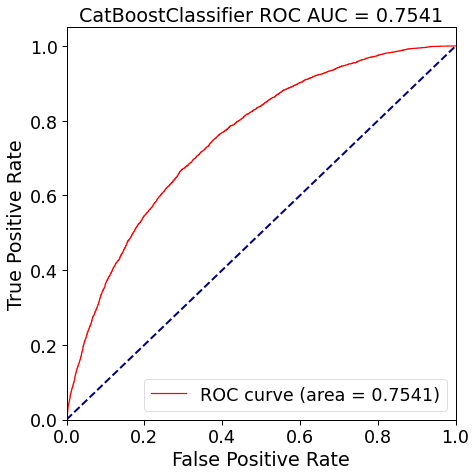

In [113]:
plt.figure(figsize=[7, 7])

fpr, tpr, thresholds = roc_curve(y_test, y_score_cb)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
name = 'CatBoostClassifier'
num = float('{:.4f}'.format(roc_auc))
    
plt.title(F"{name} ROC AUC = {num}")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

<AxesSubplot:>

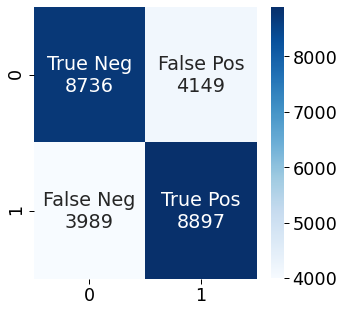

In [114]:
plt.figure(figsize=[5, 5])

sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_cb).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_cb), annot=labels, fmt='', cmap='Blues')

In [115]:
# Первые 10 главных признаков:
model = best_cb_ros

feat_names = X_test.columns
results = permutation_importance(model, X_test, y_test, scoring="roc_auc", random_state=RANDOM_SEED)
importance = results.importances_mean

feat_imp = pd.Series(importance, feat_names)
feat_imp.sort_values(ascending=False, inplace=True)

feat_imp.head(10)

score_bki          0.073990
region_rating      0.029170
home_address_2     0.020016
work_address_3     0.013604
sna_4              0.011243
bki_request_cnt    0.009592
decline_app_cnt    0.009209
education_2        0.008473
app_passed_days    0.005819
sex                0.005725
dtype: float64

# Дополнительно. Выбор порога

In [116]:
y_score_cb = best_cb_ros.predict_proba(X_test)[:,1]
y_score_cb

array([0.15022324, 0.0893969 , 0.40049105, ..., 0.35243513, 0.08896788,
       0.77436641])

In [130]:
result = pd.DataFrame(y_score_cb)
result = result.rename(columns={0: 'probs'})
result

probs
0      0.150223
1      0.089397
2      0.400491
3      0.638844
4      0.247808
...         ...
25766  0.185692
25767  0.162280
25768  0.352435
25769  0.088968
25770  0.774366

[25771 rows x 1 columns]

In [166]:
default = []

for i in result['probs']:
    if i >= 0.675:
        default.append(1)
    else:
        default.append(0)

result['default'] = default
result

probs  default
0      0.150223        0
1      0.089397        0
2      0.400491        0
3      0.638844        0
4      0.247808        0
...         ...      ...
25766  0.185692        0
25767  0.162280        0
25768  0.352435        0
25769  0.088968        0
25770  0.774366        1

[25771 rows x 2 columns]

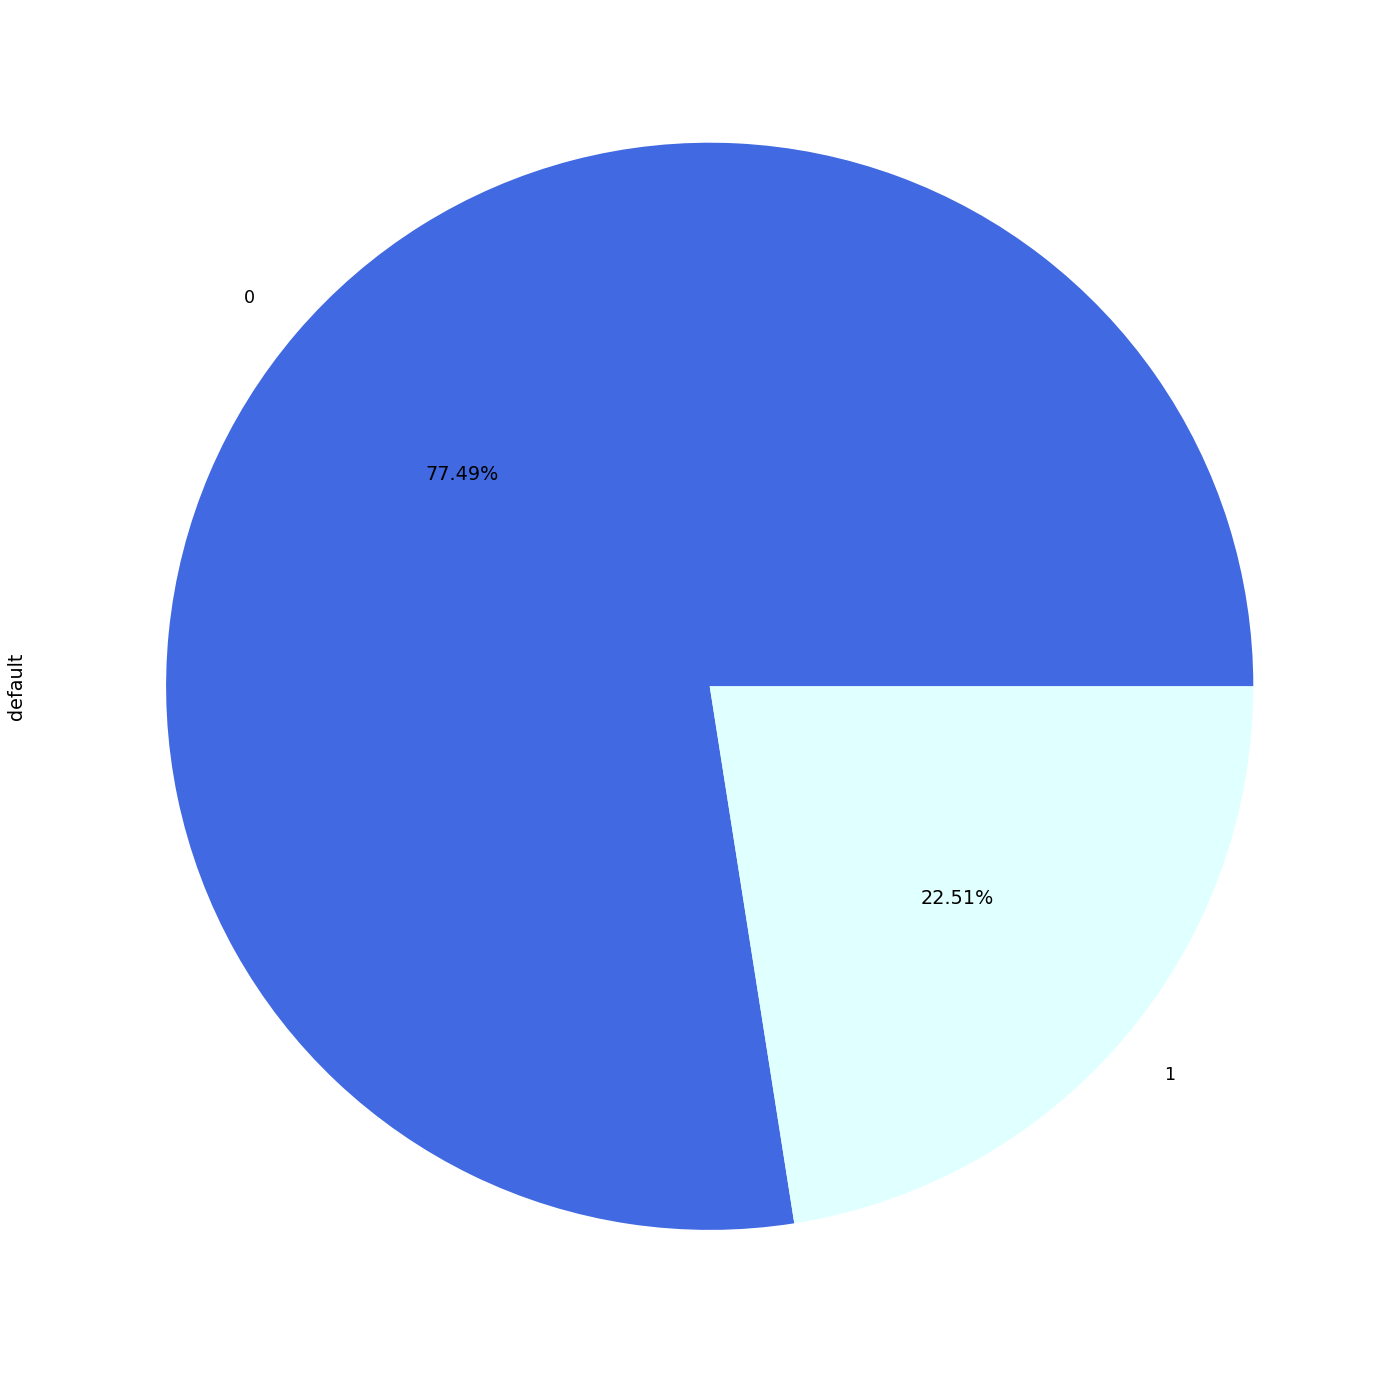

In [168]:
pd.Series(result['default']).value_counts().plot.pie( autopct = "%.2f%%", colors = ['royalblue','lightcyan'] )
plt.show()

In [136]:
res = pd.DataFrame(result)
res.to_excel("Result_file.xlsx")

In [ ]:
# y_pred = best_model.predict_proba(X_test)
# results_df = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred[:,1]})
# results_df.to_csv('submission.csv', index=False)
# results_df